## Fitting Sigmoid to empirical NN
### Manually selecting bin size

In [1]:
# 4.26 commit this version

In [1]:
# 9 Species: AT, CE, DM, ...
# 8 Classes: ER, ERDD, GEO, GEOGD ...(each with ~500 data points)
# normalization is done on each species seperetaly.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit
from scipy.special import erf
from sklearn.preprocessing import MinMaxScaler
from matplotlib.ticker import FormatStrFormatter

### normalization on AT,CE

In [34]:
Classes = ['ER', 'ERDD', 'GEO', 'GEOGD', 'HGG', 'SF', 'SFDD', 'Sticky','Original']
Species = ["AT", "CE", "DM", "EC", "HS", "MM", "RN", "SC", "SP"]
data_locations = [r"D:\file\Research\P-value\data\AT"+c for c in classes]
data_locations_CE = [r"D:\file\Research\P-value\data\CE"+c for c in classes]

['D:\\file\\Research\\P-value\\data\\ATER', 'D:\\file\\Research\\P-value\\data\\ATERDD', 'D:\\file\\Research\\P-value\\data\\ATGEO', 'D:\\file\\Research\\P-value\\data\\ATGEOGD', 'D:\\file\\Research\\P-value\\data\\ATHGG', 'D:\\file\\Research\\P-value\\data\\ATSF', 'D:\\file\\Research\\P-value\\data\\ATSFDD', 'D:\\file\\Research\\P-value\\data\\ATSticky', 'D:\\file\\Research\\P-value\\data\\ATOriginal']


In [20]:
def combine_data(data_location,classes):
    df_comb = pd.DataFrame()
    i = 0
    for protein_file in data_location:
        df = pd.read_csv(protein_file, header = None, sep = ' ')
        df['class'] = classes[i]
        df_comb = pd.concat([df, df_comb])
        i += 1
    return df_comb

def create_combined_df(data_locations, classes):
    df_comb = combine_data(data_locations,classes)
    df_class = df_comb['class']
    df_comb = df_comb.drop("class", axis = 1)
    df_comb = pd.DataFrame(MinMaxScaler().fit_transform(df_comb))
    df_comb['class'] = df_class.reset_index(drop = True)
    return df_comb

In [4]:
# Creating combined DataFrames for AT and CE datasets
df_comb = create_combined_df(data_locations, classes)
df_CE = create_combined_df(data_locations_CE, classes)

In [38]:
# return normalized data_frame for specified species 
def data_frame(species):
    loc = [r"D:\file\Research\P-value\data\{}".format(species) + c for c in Classes]
    df_comb = combine_data(loc,classes)
    df_class = df_comb['class']
    df_comb = df_comb.drop("class", axis = 1)
    df_comb = pd.DataFrame(MinMaxScaler().fit_transform(df_comb))
    df_comb['class'] = df_class.reset_index(drop = True)
    return df_comb

In [11]:
# calling data(data_frame, class_name) return Species-Class empirical data as an array
def data(dataframe, class_name):
    return dataframe[dataframe['class']==class_name].drop("class",axis=1).to_numpy()

### helper functions

In [6]:
# calculating empirical data's shortest(NN) distance 
# real data is high-dimensional data points
def data_distance(data):
    shortest_distance = [0]*len(data)
    for i in range(len(data)):
        x = np.delete(data,i,0)
        temp = (x-data[i])**2
        d = np.sqrt(np.sum(temp,axis=1))
        shortest_distance[i] = d.min()
    
    return np.array(shortest_distance)   # return an array of real data's NN distance


# plotting empirical data's NN hist
def plot_data_distance(D, title):
    """
    D: an array of real data' NN distance
    """
    f, ax = plt.subplots(1,1, figsize = (6,4))
    ax.hist(D,edgecolor='white',bins=100)   ## consider specifying <bins>
    ax.set_title(title)
    plt.show()
    return


# generate empirical CDF manually, satisfying:
# 1. F(x<=0) = 0
# 2. F(x_1) = 1/(n+1)
# 3. F(x_n/2) = 0.5
# 4. F(x_n) = n/(n+1)
# 5. F(x) < 1 for all x.
def empirical_CDF(data,title):
    '''
    return x,y data of CDF 
    '''    
    #print("data len: ",len(sort_data))
    x = np.concatenate(([0],np.sort(data)))
    #print("x len : ",len(x))
    #print("first: ", x[0], "\nlast: ",x[-1])
    
    y = np.zeros((x.shape))
    for i in range(1,len(x)):
        y[i] = i/len(x)
    
    return x,y

# Determines the appropriate p0 value based on the p_control value
def get_p0(data_NN, x_scale_factor, p_control):
    if p_control == "Gompertz":
        return [1,1]
    elif p_control == "Weight":
        return [np.median(data_NN)/x_scale_factor,1,0.5]
    else:
        return [np.median(data_NN)/x_scale_factor,1] # this is initial guess for sigmoid parameters

# curve_fit()
def auto_curve_fit(data_NN, x, y, x_scale_factor, func,s, p_control=None):
    '''
    data_NN: array empirical data_distance for calculating median
    x,y: from CDF
    s: sigma in curve_fit(), for weighting
    '''
    p0 = get_p0(data_NN, x_scale_factor, p_control)
    popt, pcov = curve_fit(f=func, xdata=x/x_scale_factor, ydata=y, p0=p0,method='lm')

    # parameters yielded by Curve_fit: x0, k
    print("curve_fit parameter on "+str(func)[9:-22]+": ", popt)
    return popt

# Sets up the title, scales, and scatter plots for axes
def plot_setup(ax, x, y ,name):
    ax[0].set_title('1-y(p_value) of '+name)
    ax[0].set_yscale('log')
    ax[0].scatter(x,1-y, color='b',s=10)
    ax[1].set_title('y of '+name)
    ax[1].scatter(x,y, color='b',s=10)

# plot fitted sigmoid and empirical curve in 1-y and y: i.e. y-axis = p-value and CDF
def sigmoids_for_class(data, name, factor, func_list, color_list, binning=False):
    if binning:
        x,y = binning_xy(data_binning(data))
    else:
        x,y = empirical_CDF(data, name)
    
    # axis[0] = 1-y = p_value (on log space)
    # axis[1] = y = CDF
    f,ax = plt.subplots(1,2,figsize=(16,6))
    plot_setup(ax, x, y, name)
    
    print("For ",name," :")

    # Loops through list of functions and applies corresponding curve fit
    for i in range(len(func_list)):
        try:
            if i == 7:
                p = auto_curve_fit(data,x,y,factor,func_list[i],s=y,p_control="Gompertz")       # 4.26: weighted s=y disabled for now
            elif i == 6:
                p = auto_curve_fit(data,x,y,factor,func_list[i],s=y,p_control="Weight")
            else:
                p = auto_curve_fit(data,x,y,factor,func_list[i],s=y)
        except RuntimeError:
            print("error in ",str(func_list[i])[9:-22])
            continue
        y2 = func_list[i](x/factor, *p)
        ax[0].plot(x, 1-y2, color=color_list[i], label=str(func_list[i])[9:-22])
        ax[1].plot(x, y2, color=color_list[i], label=str(func_list[i])[9:-22])
    
    ax[0].legend(loc='lower left')
    ax[1].legend(loc='lower left')
    plt.show()

### Sigmoid functions

In [7]:
# 4.11 Adjust range to (0,1)

def logistic(x,x0, k):
    m = (1/ (1 + np.exp(-k*(x-x0))))      
    return m

def tanh(x, x0, k): 
    m = (1+np.tanh(k*(x-x0)))/2
    return m

def arctan(x, x0, k):
    m = (1+(2/np.pi)*np.arctan(k*(x-x0)))/2
    return m

def GD(x, x0, k):
    m = (1+(4/np.pi)*np.arctan(np.tanh(k*(x-x0))))/2
    return m

def ERF(x, x0, k):
    m = (1+erf(k*(x-x0)))/2
    return m

def algebra(x, x0, k):
    m = (1+x/((1+abs(x)**k)**(1/k)))/2
    return m

def arctan_GD(x,x0,k, w):
    m = w*GD(x,x0,k)+(1-w)*arctan(x,x0,k)
    return m

def Gompertz(x,b,c):
    m = np.e**(-np.e**(b-c*x))
    return m

### Fitting on All points without binning

In [8]:
classes = ['ER', 'ERDD', 'GEO', 'GEOGD', 'HGG', 'SF', 'SFDD', 'Sticky','Original']
factors_AT = [1e-5,  1e-2,   1e-4,   1e-3,   1e-2,  1e-4, 1e-2,   1e-3]
colors = ['g','r','c','m','y','k','brown','gray']
functions = [logistic, tanh, arctan, GD, ERF, algebra, arctan_GD, Gompertz]

For  ER  :
curve_fit parameter on  logistic :  [5.01019699 0.63931604]
curve_fit parameter on  tanh :  [5.01019521 0.31965852]
curve_fit parameter on  arctan :  [4.9315695  0.66176824]
curve_fit parameter on  GD :  [4.99858203 0.26140507]
curve_fit parameter on  ERF :  [5.02452782 0.27073493]
curve_fit parameter on  algebra :  [4.74320923 0.24683585]
curve_fit parameter on  arctan_GD :  [ 4.96754038  1.173988   -0.60411277]
curve_fit parameter on  Gompertz :  [1.75786268 0.43324337]


C:\Users\SHIQIJ~1\AppData\Local\Temp/ipykernel_3572/217763432.py:24: RuntimeWarning: divide by zero encountered in power
  m = (1+x/((1+abs(x)**k)**(1/k)))/2
C:\Users\SHIQIJ~1\AppData\Local\Temp/ipykernel_3572/217763432.py:24: RuntimeWarning: invalid value encountered in true_divide
  m = (1+x/((1+abs(x)**k)**(1/k)))/2
D:\anaconda\anaconda\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


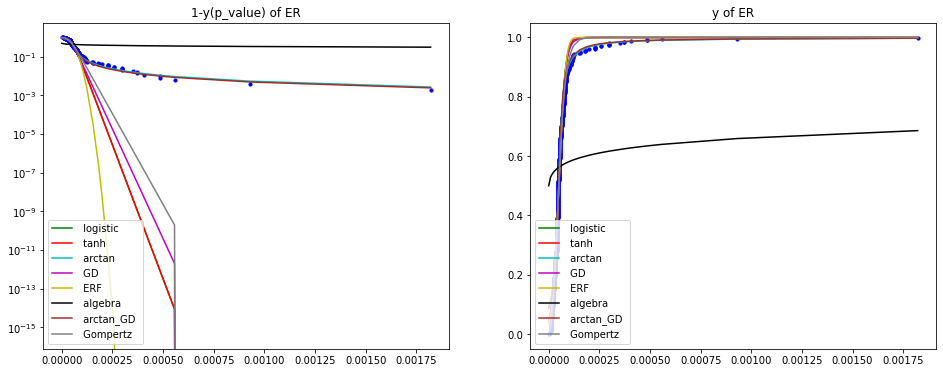

For  ERDD  :
curve_fit parameter on  logistic :  [1.05927601 2.72239646]
curve_fit parameter on  tanh :  [1.05927603 1.36119758]
curve_fit parameter on  arctan :  [1.04166089 2.69013301]
curve_fit parameter on  GD :  [1.05639975 1.10582799]
curve_fit parameter on  ERF :  [1.06344078 1.16179339]
curve_fit parameter on  algebra :  [1.01217827 0.36077615]
curve_fit parameter on  arctan_GD :  [1.05411789 1.187677   0.90007104]
curve_fit parameter on  Gompertz :  [1.58329448 1.90085267]


C:\Users\SHIQIJ~1\AppData\Local\Temp/ipykernel_3572/217763432.py:24: RuntimeWarning: divide by zero encountered in power
  m = (1+x/((1+abs(x)**k)**(1/k)))/2
C:\Users\SHIQIJ~1\AppData\Local\Temp/ipykernel_3572/217763432.py:24: RuntimeWarning: invalid value encountered in true_divide
  m = (1+x/((1+abs(x)**k)**(1/k)))/2
D:\anaconda\anaconda\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


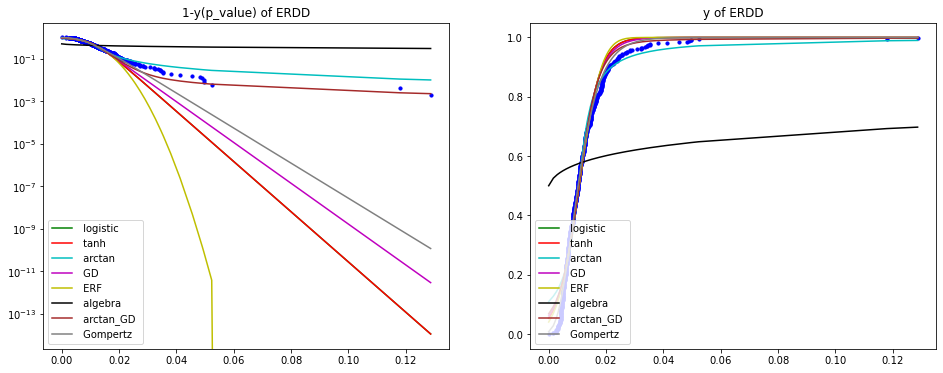

For  GEO  :
curve_fit parameter on  logistic :  [2.23131802 1.45325018]
curve_fit parameter on  tanh :  [2.23131428 0.72663001]
curve_fit parameter on  arctan :  [2.18763034 1.43353787]
curve_fit parameter on  GD :  [2.22536583 0.58884726]
curve_fit parameter on  ERF :  [2.23897623 0.62255387]
curve_fit parameter on  algebra :  [2.07712928 0.27920832]
curve_fit parameter on  arctan_GD :  [2.21017483 0.73690297 0.70316769]
curve_fit parameter on  Gompertz :  [1.83358288 1.01109907]


C:\Users\SHIQIJ~1\AppData\Local\Temp/ipykernel_3572/217763432.py:24: RuntimeWarning: divide by zero encountered in power
  m = (1+x/((1+abs(x)**k)**(1/k)))/2
C:\Users\SHIQIJ~1\AppData\Local\Temp/ipykernel_3572/217763432.py:24: RuntimeWarning: invalid value encountered in true_divide
  m = (1+x/((1+abs(x)**k)**(1/k)))/2
D:\anaconda\anaconda\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


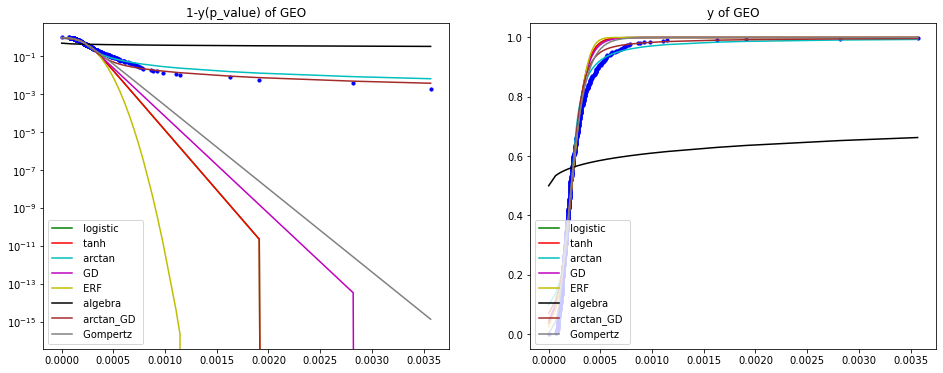

For  GEOGD  :
curve_fit parameter on  logistic :  [0.41592654 4.80376309]
curve_fit parameter on  tanh :  [0.41592611 2.40188789]
curve_fit parameter on  arctan :  [0.39851997 4.58004858]
curve_fit parameter on  GD :  [0.41366408 1.9344383 ]
curve_fit parameter on  ERF :  [0.41895869 2.07007359]
curve_fit parameter on  algebra :  [0.35420422 0.66767855]
curve_fit parameter on  arctan_GD :  [0.39927522 3.84098601 0.17554037]
curve_fit parameter on  Gompertz :  [0.99437282 3.39693702]


D:\anaconda\anaconda\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


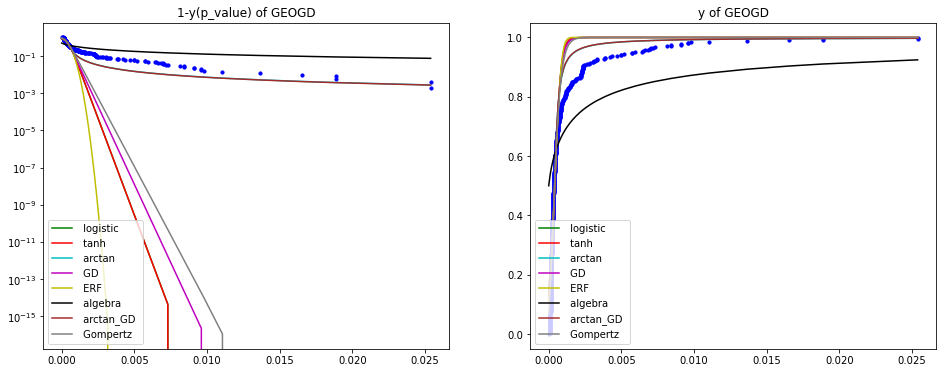

For  HGG  :
curve_fit parameter on  logistic :  [9.8439015  0.25848108]
curve_fit parameter on  tanh :  [9.84394079 0.12923882]
curve_fit parameter on  arctan :  [9.46561202 0.26217161]
curve_fit parameter on  GD :  [9.7885904  0.10504069]
curve_fit parameter on  ERF :  [9.92224306 0.11001518]
curve_fit parameter on  algebra :  [8.94144704 0.22188734]
curve_fit parameter on  arctan_GD :  [ 9.70014547  0.66168816 -1.12816861]
curve_fit parameter on  Gompertz :  [1.38823933 0.18390258]


C:\Users\SHIQIJ~1\AppData\Local\Temp/ipykernel_3572/217763432.py:24: RuntimeWarning: divide by zero encountered in power
  m = (1+x/((1+abs(x)**k)**(1/k)))/2
C:\Users\SHIQIJ~1\AppData\Local\Temp/ipykernel_3572/217763432.py:24: RuntimeWarning: invalid value encountered in true_divide
  m = (1+x/((1+abs(x)**k)**(1/k)))/2
D:\anaconda\anaconda\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


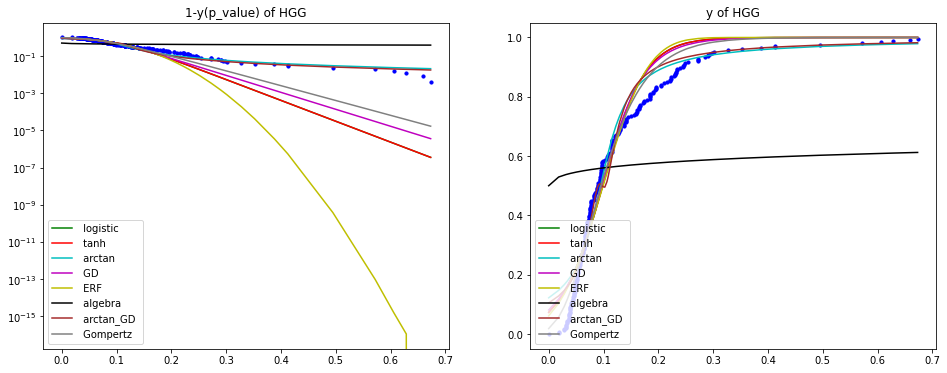

For  SF  :
curve_fit parameter on  logistic :  [2.91621671 1.54410037]
curve_fit parameter on  tanh :  [2.91621514 0.77205075]
curve_fit parameter on  arctan :  [2.88233441 1.52801738]
curve_fit parameter on  GD :  [2.91107066 0.62702766]
curve_fit parameter on  ERF :  [2.92303736 0.65946336]
curve_fit parameter on  algebra :  [2.82972287 0.23538203]
curve_fit parameter on  arctan_GD :  [2.90997015 0.63945519 0.97189539]
curve_fit parameter on  Gompertz :  [2.72942207 1.08312589]


C:\Users\SHIQIJ~1\AppData\Local\Temp/ipykernel_3572/217763432.py:24: RuntimeWarning: divide by zero encountered in power
  m = (1+x/((1+abs(x)**k)**(1/k)))/2
C:\Users\SHIQIJ~1\AppData\Local\Temp/ipykernel_3572/217763432.py:24: RuntimeWarning: invalid value encountered in true_divide
  m = (1+x/((1+abs(x)**k)**(1/k)))/2
D:\anaconda\anaconda\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


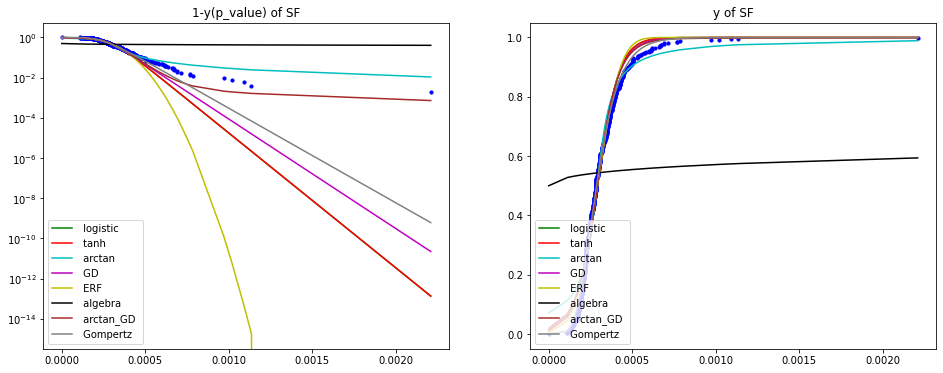

For  SFDD  :
curve_fit parameter on  logistic :  [1.6739215  1.76134158]
curve_fit parameter on  tanh :  [1.67391232 0.88068919]
curve_fit parameter on  arctan :  [1.62544171 1.77613981]
curve_fit parameter on  GD :  [1.66648145 0.71660845]
curve_fit parameter on  ERF :  [1.68414598 0.74923596]
curve_fit parameter on  algebra :  [1.55198565 0.31595582]
curve_fit parameter on  arctan_GD :  [ 1.65649778  3.96163708 -0.92405749]
curve_fit parameter on  Gompertz :  [1.64090647 1.22864676]


C:\Users\SHIQIJ~1\AppData\Local\Temp/ipykernel_3572/217763432.py:24: RuntimeWarning: divide by zero encountered in power
  m = (1+x/((1+abs(x)**k)**(1/k)))/2
C:\Users\SHIQIJ~1\AppData\Local\Temp/ipykernel_3572/217763432.py:24: RuntimeWarning: invalid value encountered in true_divide
  m = (1+x/((1+abs(x)**k)**(1/k)))/2
D:\anaconda\anaconda\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


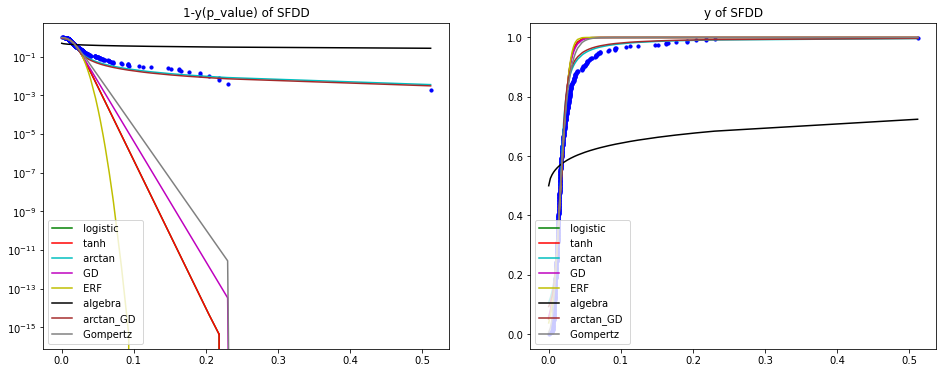

For  Sticky  :
curve_fit parameter on  logistic :  [5.72785809 0.94982721]
curve_fit parameter on  tanh :  [5.72786237 0.47491125]
curve_fit parameter on  arctan :  [5.66467309 0.94527715]
curve_fit parameter on  GD :  [5.7185246  0.38590835]
curve_fit parameter on  ERF :  [5.73990646 0.4054232 ]
curve_fit parameter on  algebra :  [5.49479545 0.19825999]
curve_fit parameter on  arctan_GD :  [5.71498191 0.39985065 0.95002077]
curve_fit parameter on  Gompertz :  [3.39558209 0.6675235 ]


C:\Users\SHIQIJ~1\AppData\Local\Temp/ipykernel_3572/217763432.py:24: RuntimeWarning: divide by zero encountered in power
  m = (1+x/((1+abs(x)**k)**(1/k)))/2
C:\Users\SHIQIJ~1\AppData\Local\Temp/ipykernel_3572/217763432.py:24: RuntimeWarning: invalid value encountered in true_divide
  m = (1+x/((1+abs(x)**k)**(1/k)))/2
D:\anaconda\anaconda\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


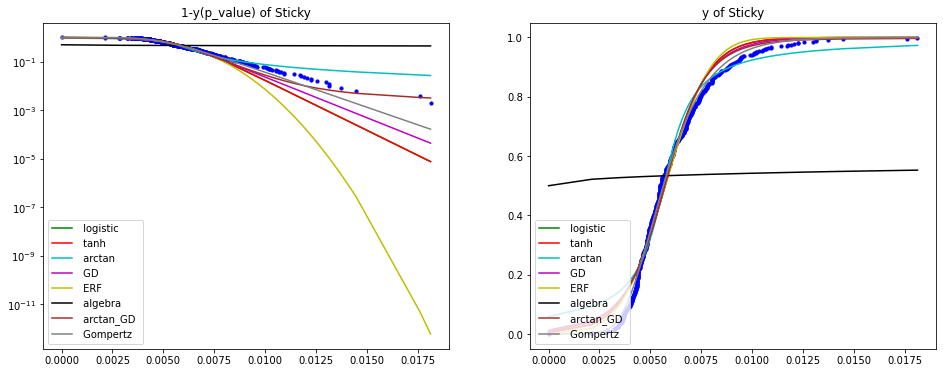

In [12]:
# Plotting fittings for all classes of AT apecies
for i in range(len(classes[:-1])):
    data_i = data_distance(data(df_comb,classes[:-1][i]))
    sigmoids_for_class(data_i, classes[:-1][i], factors_AT[i], functions, colors)

In [13]:
factors_CE = [1e-4, 1e-2, 1e-3, 1e-2,1e-1, 1e-4, 1e-1, 1e-4]

For  ER  :
curve_fit parameter on  logistic :  [1.94606213 1.81560264]
curve_fit parameter on  tanh :  [1.94606109 0.90780356]
curve_fit parameter on  arctan :  [1.92554653 1.84634992]
curve_fit parameter on  GD :  [1.94274263 0.74108489]
curve_fit parameter on  ERF :  [1.95088804 0.76944669]
curve_fit parameter on  algebra :  [1.8709861  0.28815412]
curve_fit parameter on  arctan_GD :  [1.93702551 0.87978063 0.7766376 ]
curve_fit parameter on  Gompertz :  [1.98391685 1.23381394]


C:\Users\SHIQIJ~1\AppData\Local\Temp/ipykernel_3572/217763432.py:24: RuntimeWarning: divide by zero encountered in power
  m = (1+x/((1+abs(x)**k)**(1/k)))/2
C:\Users\SHIQIJ~1\AppData\Local\Temp/ipykernel_3572/217763432.py:24: RuntimeWarning: invalid value encountered in true_divide
  m = (1+x/((1+abs(x)**k)**(1/k)))/2
D:\anaconda\anaconda\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


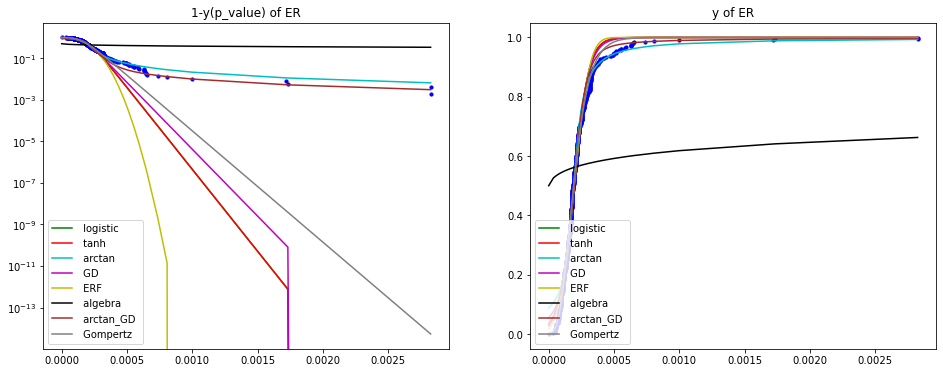

For  ERDD  :
curve_fit parameter on  logistic :  [1.12616432 3.99340048]
curve_fit parameter on  tanh :  [1.12616442 1.99669952]
curve_fit parameter on  arctan :  [1.11156876 3.96434666]
curve_fit parameter on  GD :  [1.12404433 1.62186182]
curve_fit parameter on  ERF :  [1.12902684 1.7038601 ]
curve_fit parameter on  algebra :  [1.08467194 0.30205569]
curve_fit parameter on  arctan_GD :  [1.1195791  1.97094562 0.74217289]
curve_fit parameter on  Gompertz :  [2.69934083 2.76997435]


C:\Users\SHIQIJ~1\AppData\Local\Temp/ipykernel_3572/217763432.py:24: RuntimeWarning: divide by zero encountered in power
  m = (1+x/((1+abs(x)**k)**(1/k)))/2
C:\Users\SHIQIJ~1\AppData\Local\Temp/ipykernel_3572/217763432.py:24: RuntimeWarning: invalid value encountered in true_divide
  m = (1+x/((1+abs(x)**k)**(1/k)))/2
D:\anaconda\anaconda\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


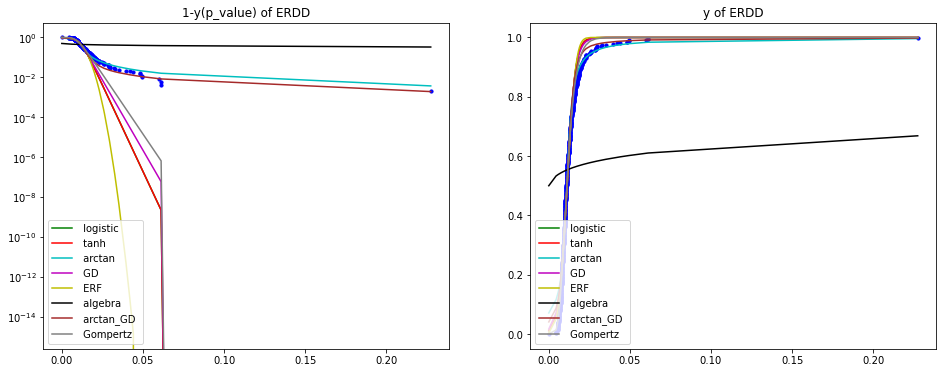

For  GEO  :
curve_fit parameter on  logistic :  [1.67382321 2.78055501]
curve_fit parameter on  tanh :  [1.67382322 1.39027732]
curve_fit parameter on  arctan :  [1.66044839 2.74387975]
curve_fit parameter on  GD :  [1.67203869 1.12859645]
curve_fit parameter on  ERF :  [1.67617152 1.18746551]
curve_fit parameter on  algebra :  [1.6242431  0.26798898]
curve_fit parameter on  arctan_GD :  [1.67051126 1.21253376 0.8994181 ]
curve_fit parameter on  Gompertz :  [2.78536019 1.91606474]


C:\Users\SHIQIJ~1\AppData\Local\Temp/ipykernel_3572/217763432.py:24: RuntimeWarning: divide by zero encountered in power
  m = (1+x/((1+abs(x)**k)**(1/k)))/2
C:\Users\SHIQIJ~1\AppData\Local\Temp/ipykernel_3572/217763432.py:24: RuntimeWarning: invalid value encountered in true_divide
  m = (1+x/((1+abs(x)**k)**(1/k)))/2
D:\anaconda\anaconda\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


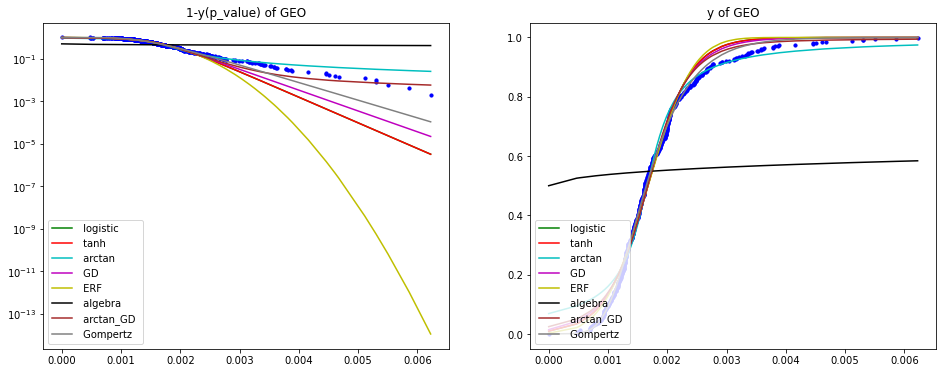

For  GEOGD  :
curve_fit parameter on  logistic :  [0.29490803 7.75814042]
curve_fit parameter on  tanh :  [0.29490921 3.87902334]
curve_fit parameter on  arctan :  [0.27843769 7.90380023]
curve_fit parameter on  GD :  [0.29283136 3.14207303]
curve_fit parameter on  ERF :  [0.29773893 3.31491548]
curve_fit parameter on  algebra :  [0.24724461 3.04096133]
curve_fit parameter on  arctan_GD :  [ 0.29506843 22.09716848 -1.4045109 ]
curve_fit parameter on  Gompertz :  [1.23844122 5.64889883]


D:\anaconda\anaconda\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


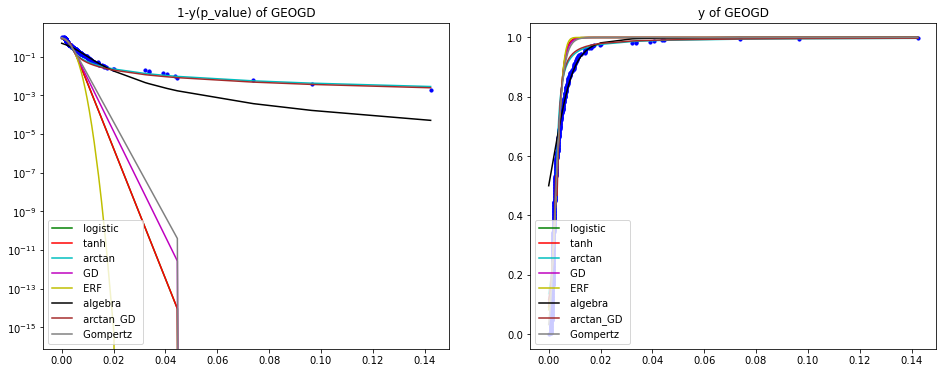

For  HGG  :
curve_fit parameter on  logistic :  [0.49047975 4.53901087]
curve_fit parameter on  tanh :  [0.49048164 2.26947972]
curve_fit parameter on  arctan :  [0.45946001 4.66386372]
curve_fit parameter on  GD :  [0.4867633  1.83754941]
curve_fit parameter on  ERF :  [0.49551134 1.93985614]
curve_fit parameter on  algebra :  [0.40294287 0.57946243]
curve_fit parameter on  arctan_GD :  [0.46070551 3.94516354 0.16414252]
curve_fit parameter on  Gompertz :  [1.20607326 3.33476332]


D:\anaconda\anaconda\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


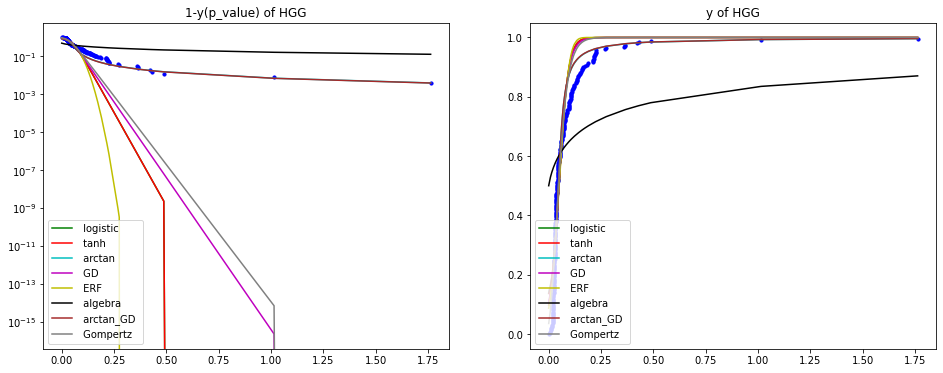

For  SF  :
curve_fit parameter on  logistic :  [9.44660321 0.55979228]
curve_fit parameter on  tanh :  [9.4466019  0.27989618]
curve_fit parameter on  arctan :  [9.36503726 0.55993844]
curve_fit parameter on  GD :  [9.43518287 0.22765541]
curve_fit parameter on  ERF :  [9.46118399 0.23842467]
curve_fit parameter on  algebra :  [9.20819632 0.19056114]
curve_fit parameter on  arctan_GD :  [ 9.42293395  1.19555264 -0.84402286]
curve_fit parameter on  Gompertz :  [3.21352999 0.38419889]


C:\Users\SHIQIJ~1\AppData\Local\Temp/ipykernel_3572/217763432.py:24: RuntimeWarning: divide by zero encountered in power
  m = (1+x/((1+abs(x)**k)**(1/k)))/2
C:\Users\SHIQIJ~1\AppData\Local\Temp/ipykernel_3572/217763432.py:24: RuntimeWarning: invalid value encountered in true_divide
  m = (1+x/((1+abs(x)**k)**(1/k)))/2
D:\anaconda\anaconda\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


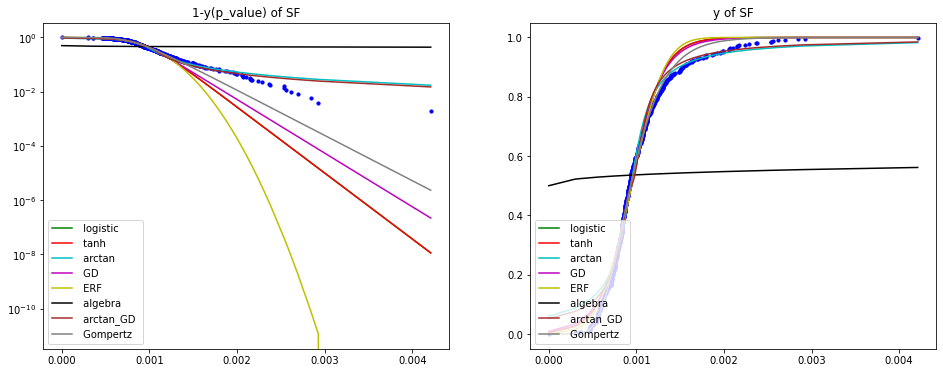

For  SFDD  :
curve_fit parameter on  logistic :  [ 0.23673612 11.65286499]
curve_fit parameter on  tanh :  [0.23673607 5.8264371 ]
curve_fit parameter on  arctan :  [ 0.22901712 11.6447054 ]
curve_fit parameter on  GD :  [0.23560146 4.72482547]
curve_fit parameter on  ERF :  [0.23841346 4.96935401]
curve_fit parameter on  algebra :  [ 0.21892582 10.78660079]
curve_fit parameter on  arctan_GD :  [0.22954376 8.86509579 0.27276383]
curve_fit parameter on  Gompertz :  [1.52828905 8.21670885]


D:\anaconda\anaconda\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


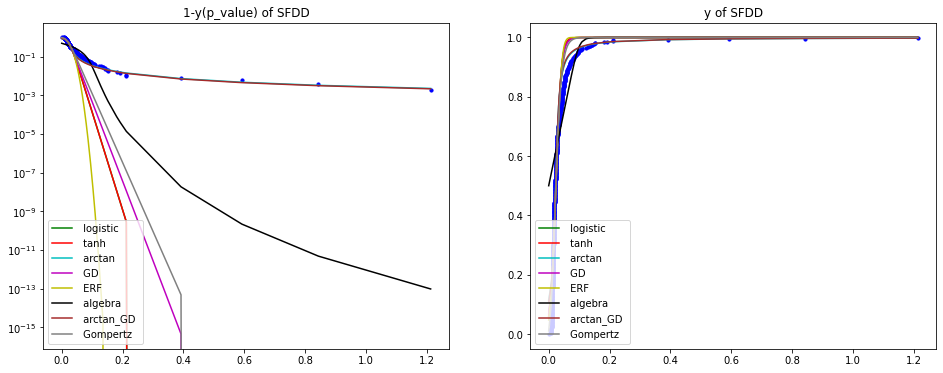

For  Sticky  :
curve_fit parameter on  logistic :  [7.99465705e+01 7.55061503e-02]
curve_fit parameter on  tanh :  [7.99465658e+01 3.77530566e-02]
curve_fit parameter on  arctan :  [7.95860654e+01 7.49588673e-02]
curve_fit parameter on  GD :  [7.98959136e+01 3.06980529e-02]
curve_fit parameter on  ERF :  [8.00128222e+01 3.21993518e-02]
curve_fit parameter on  algebra :  [78.50832208  0.1433607 ]
curve_fit parameter on  arctan_GD :  [79.76383095  0.1584869  -0.8358784 ]
curve_fit parameter on  Gompertz :  [2.11976164 1.        ]


C:\Users\SHIQIJ~1\AppData\Local\Temp/ipykernel_3572/217763432.py:24: RuntimeWarning: divide by zero encountered in power
  m = (1+x/((1+abs(x)**k)**(1/k)))/2
C:\Users\SHIQIJ~1\AppData\Local\Temp/ipykernel_3572/217763432.py:24: RuntimeWarning: invalid value encountered in true_divide
  m = (1+x/((1+abs(x)**k)**(1/k)))/2
D:\anaconda\anaconda\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
D:\anaconda\anaconda\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


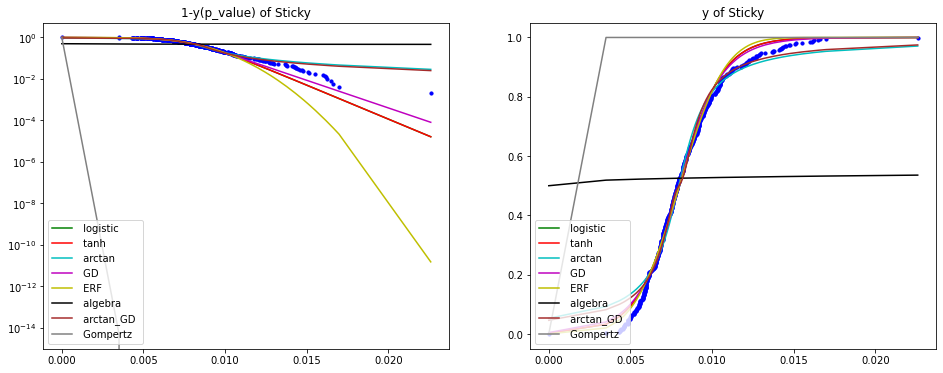

In [14]:
for i in range(len(classes[:-1])):
    data_i = data_distance(data(df_CE,classes[:-1][i]))
    sigmoids_for_class(data_i, classes[:-1][i], factors_CE[i], functions, colors)

### Binning

In [15]:
# binning first, add (0,0) at the front later when calculate y

def data_binning(data):
    
    x = np.sort(data) 
    N = len(x)                   # e.g N = 500, sqrt(500)=22.3
    lower = int(np.floor(np.sqrt(N))) # 22
    upper = int(np.ceil(np.sqrt(N)))  # 23 as total #of bin
    
    if lower*upper >= N:
        small_bin_num = int(lower*upper - N)  # 22*23 - 500 = 6
        small_bin_size = int(lower - 1)  # 21
        large_bin_size = lower
    else: # HGG -> sqrt(252) = 15.8
        small_bin_num = int(upper**2 - N) # 16*16-252 =4
        small_bin_size = lower  # 15
        large_bin_size = upper
    
    large_bin_num = int(upper - small_bin_num) # 23-6 = 17

    # small_bin_size*small_bin_num + lower*large_bin_num = N

    bin_count = [large_bin_size]*large_bin_num + [small_bin_size]*small_bin_num  # [22..*17, 21..*6,]
    print("items in each bin: ", bin_count)
    binned_data = []
    i = 0
    for count in bin_count:
        binned_data.append(np.mean(x[i:i+count]))
        i += count
    
    return binned_data


def binning_xy(binned_data):
    x = np.concatenate(([0],binned_data))
    y = np.zeros((x.shape))
    
    for i in range(1,len(x)):
        y[i] = i/len(x)
        
    return x,y
 

#### AT

items in each bin:  [22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 21, 21, 21, 21, 21, 21, 21]
For  ER  :
curve_fit parameter on  logistic :  [5.07797398 0.59115369]
curve_fit parameter on  tanh :  [5.07796948 0.29557785]
curve_fit parameter on  arctan :  [4.99318686 0.60992837]
curve_fit parameter on  GD :  [5.06607858 0.24153901]
curve_fit parameter on  ERF :  [5.09204204 0.25064859]
curve_fit parameter on  algebra :  [4.74320923 0.24428437]
curve_fit parameter on  arctan_GD :  [ 5.04102127  1.1190459  -0.64914887]
curve_fit parameter on  Gompertz :  [1.60688364 0.39740493]


C:\Users\SHIQIJ~1\AppData\Local\Temp/ipykernel_3572/217763432.py:24: RuntimeWarning: divide by zero encountered in power
  m = (1+x/((1+abs(x)**k)**(1/k)))/2
C:\Users\SHIQIJ~1\AppData\Local\Temp/ipykernel_3572/217763432.py:24: RuntimeWarning: invalid value encountered in true_divide
  m = (1+x/((1+abs(x)**k)**(1/k)))/2
D:\anaconda\anaconda\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


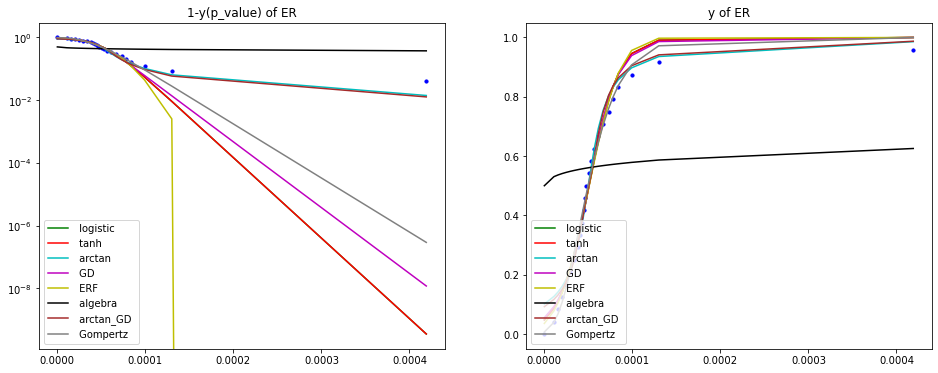

items in each bin:  [22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 21, 21, 21, 21, 21, 21]
For  ERDD  :
curve_fit parameter on  logistic :  [1.07512038 2.53863779]
curve_fit parameter on  tanh :  [1.07512033 1.26931841]
curve_fit parameter on  arctan :  [1.05559788 2.51593788]
curve_fit parameter on  GD :  [1.07188823 1.03250419]
curve_fit parameter on  ERF :  [1.07969008 1.08162588]
curve_fit parameter on  algebra :  [1.01217827 0.35372926]
curve_fit parameter on  arctan_GD :  [1.07007499 1.08833565 0.92572509]
curve_fit parameter on  Gompertz :  [1.46803305 1.76338188]


C:\Users\SHIQIJ~1\AppData\Local\Temp/ipykernel_3572/217763432.py:24: RuntimeWarning: divide by zero encountered in power
  m = (1+x/((1+abs(x)**k)**(1/k)))/2
C:\Users\SHIQIJ~1\AppData\Local\Temp/ipykernel_3572/217763432.py:24: RuntimeWarning: invalid value encountered in true_divide
  m = (1+x/((1+abs(x)**k)**(1/k)))/2
D:\anaconda\anaconda\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


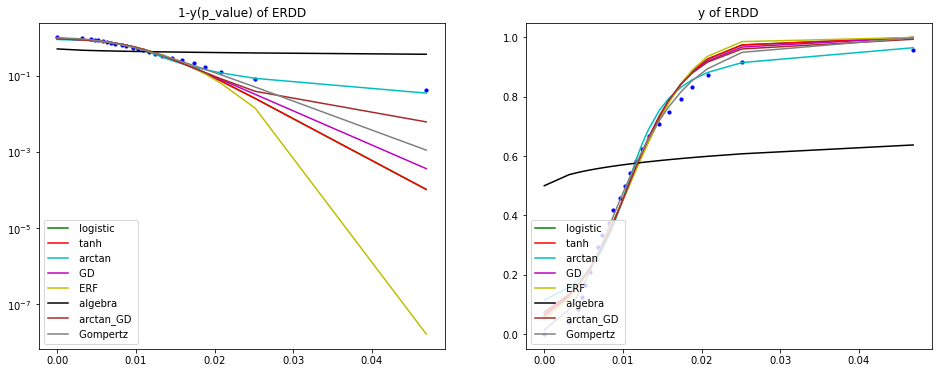

items in each bin:  [22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 21, 21, 21, 21, 21, 21, 21]
For  GEO  :
curve_fit parameter on  logistic :  [2.26613235 1.33951129]
curve_fit parameter on  tanh :  [2.26612946 0.66975909]
curve_fit parameter on  arctan :  [2.21920906 1.32532057]
curve_fit parameter on  GD :  [2.2596074  0.54340802]
curve_fit parameter on  ERF :  [2.27449656 0.57284214]
curve_fit parameter on  algebra :  [2.07712928 0.27606388]
curve_fit parameter on  arctan_GD :  [2.244768   0.66605842 0.72993856]
curve_fit parameter on  Gompertz :  [1.68669987 0.9294231 ]


C:\Users\SHIQIJ~1\AppData\Local\Temp/ipykernel_3572/217763432.py:24: RuntimeWarning: divide by zero encountered in power
  m = (1+x/((1+abs(x)**k)**(1/k)))/2
C:\Users\SHIQIJ~1\AppData\Local\Temp/ipykernel_3572/217763432.py:24: RuntimeWarning: invalid value encountered in true_divide
  m = (1+x/((1+abs(x)**k)**(1/k)))/2
D:\anaconda\anaconda\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


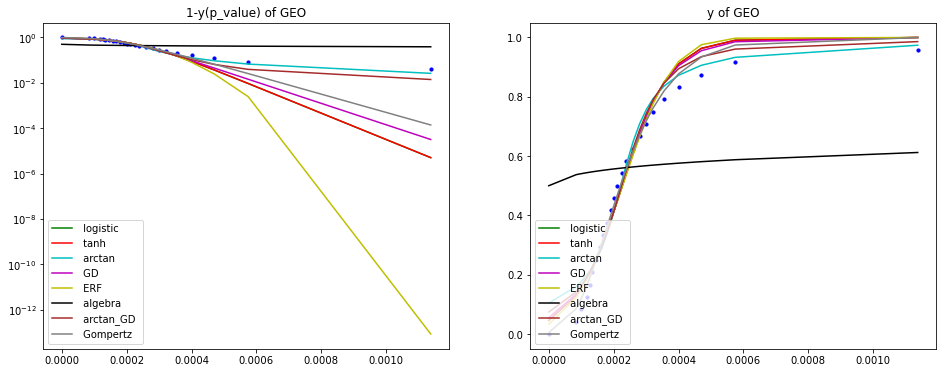

items in each bin:  [22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 21, 21, 21, 21, 21, 21]
For  GEOGD  :
curve_fit parameter on  logistic :  [0.42812433 4.533013  ]
curve_fit parameter on  tanh :  [0.42812349 2.26651672]
curve_fit parameter on  arctan :  [0.40922295 4.32666737]
curve_fit parameter on  GD :  [0.42569694 1.82663962]
curve_fit parameter on  ERF :  [0.43140924 1.95184289]
curve_fit parameter on  algebra :  [0.35420422 0.62215232]
curve_fit parameter on  arctan_GD :  [0.41069824 3.40099086 0.24135329]
curve_fit parameter on  Gompertz :  [0.93631761 3.15798872]


D:\anaconda\anaconda\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


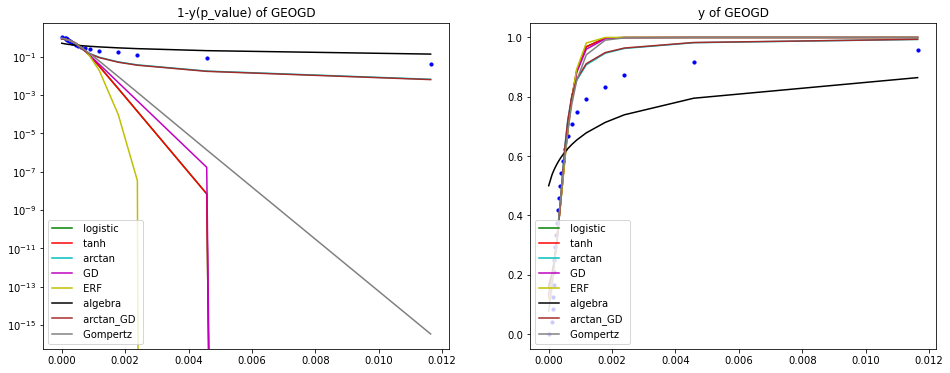

items in each bin:  [16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 15, 15, 15, 15, 15]
For  HGG  :
curve_fit parameter on  logistic :  [10.20956289  0.229996  ]
curve_fit parameter on  tanh :  [10.20960343  0.11499672]
curve_fit parameter on  arctan :  [9.7574221  0.23562532]
curve_fit parameter on  GD :  [10.13871432  0.09382883]
curve_fit parameter on  ERF :  [10.31128284  0.09734595]
curve_fit parameter on  algebra :  [8.94144704 0.21813791]
curve_fit parameter on  arctan_GD :  [ 9.91023035  0.55689289 -1.00435192]
curve_fit parameter on  Gompertz :  [1.23253636 0.1620233 ]


C:\Users\SHIQIJ~1\AppData\Local\Temp/ipykernel_3572/217763432.py:24: RuntimeWarning: divide by zero encountered in power
  m = (1+x/((1+abs(x)**k)**(1/k)))/2
C:\Users\SHIQIJ~1\AppData\Local\Temp/ipykernel_3572/217763432.py:24: RuntimeWarning: invalid value encountered in true_divide
  m = (1+x/((1+abs(x)**k)**(1/k)))/2
D:\anaconda\anaconda\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


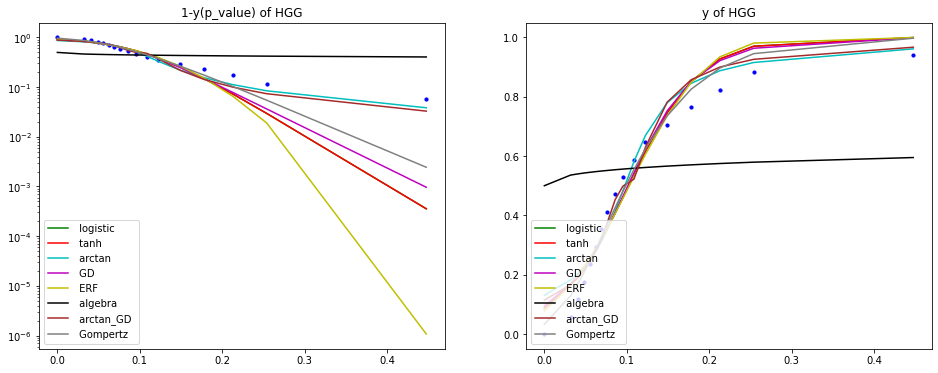

items in each bin:  [22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 21, 21, 21, 21, 21, 21, 21]
For  SF  :
curve_fit parameter on  logistic :  [2.94451734 1.42403876]
curve_fit parameter on  tanh :  [2.94451701 0.71201998]
curve_fit parameter on  arctan :  [2.90944193 1.40479058]
curve_fit parameter on  GD :  [2.93918755 0.57791483]
curve_fit parameter on  ERF :  [2.95158669 0.60839849]
curve_fit parameter on  algebra :  [2.82972287 0.23294768]
curve_fit parameter on  arctan_GD :  [2.93596461 0.61251131 0.91761018]
curve_fit parameter on  Gompertz :  [2.52030312 1.00044091]


C:\Users\SHIQIJ~1\AppData\Local\Temp/ipykernel_3572/217763432.py:24: RuntimeWarning: divide by zero encountered in power
  m = (1+x/((1+abs(x)**k)**(1/k)))/2
C:\Users\SHIQIJ~1\AppData\Local\Temp/ipykernel_3572/217763432.py:24: RuntimeWarning: invalid value encountered in true_divide
  m = (1+x/((1+abs(x)**k)**(1/k)))/2
D:\anaconda\anaconda\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


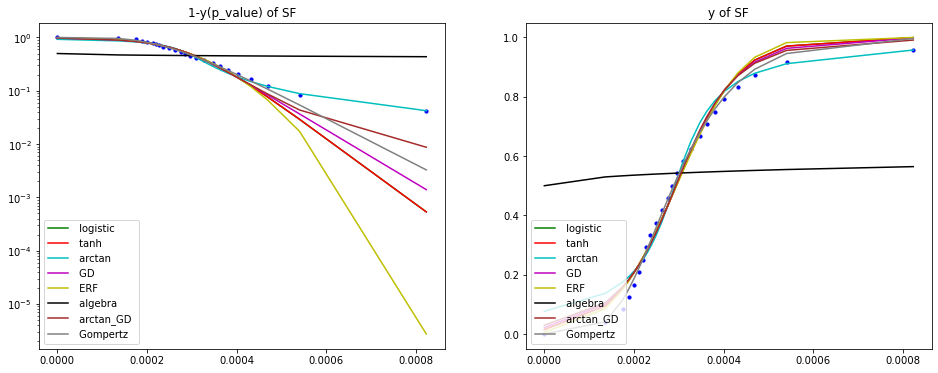

items in each bin:  [22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 21, 21, 21, 21, 21, 21]
For  SFDD  :
curve_fit parameter on  logistic :  [1.70428983 1.61822203]
curve_fit parameter on  tanh :  [1.70428487 0.80911912]
curve_fit parameter on  arctan :  [1.65056355 1.63632572]
curve_fit parameter on  GD :  [1.69621794 0.65862933]
curve_fit parameter on  ERF :  [1.7147492  0.68895094]
curve_fit parameter on  algebra :  [1.55198565 0.31085823]
curve_fit parameter on  arctan_GD :  [1.66479037 1.01722504 0.47517044]
curve_fit parameter on  Gompertz :  [1.49559298 1.11968089]


C:\Users\SHIQIJ~1\AppData\Local\Temp/ipykernel_3572/217763432.py:24: RuntimeWarning: divide by zero encountered in power
  m = (1+x/((1+abs(x)**k)**(1/k)))/2
C:\Users\SHIQIJ~1\AppData\Local\Temp/ipykernel_3572/217763432.py:24: RuntimeWarning: invalid value encountered in true_divide
  m = (1+x/((1+abs(x)**k)**(1/k)))/2
D:\anaconda\anaconda\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


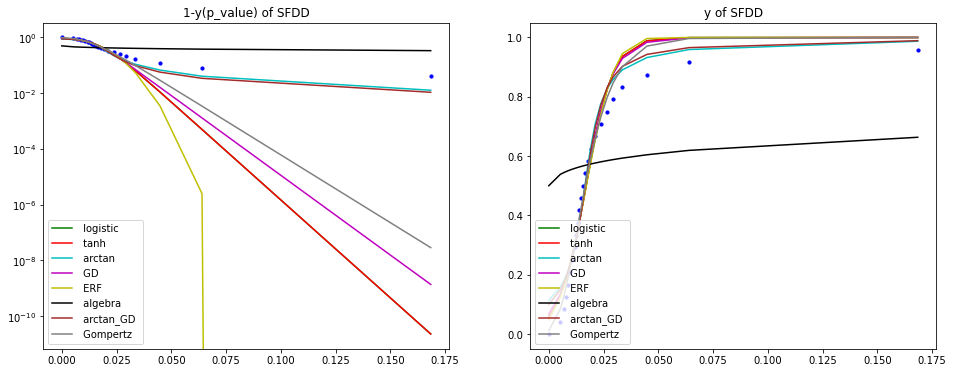

items in each bin:  [22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 21, 21, 21, 21, 21, 21, 21]
For  Sticky  :
curve_fit parameter on  logistic :  [5.77496183 0.87224034]
curve_fit parameter on  tanh :  [5.77496269 0.43611979]
curve_fit parameter on  arctan :  [5.71007098 0.86372475]
curve_fit parameter on  GD :  [5.76554603 0.35385547]
curve_fit parameter on  ERF :  [5.78707774 0.37286559]
curve_fit parameter on  algebra :  [5.49479545 0.19621065]
curve_fit parameter on  arctan_GD :  [5.75745789 0.38391713 0.88647097]
curve_fit parameter on  Gompertz :  [3.1220332  0.61408322]


C:\Users\SHIQIJ~1\AppData\Local\Temp/ipykernel_3572/217763432.py:24: RuntimeWarning: divide by zero encountered in power
  m = (1+x/((1+abs(x)**k)**(1/k)))/2
C:\Users\SHIQIJ~1\AppData\Local\Temp/ipykernel_3572/217763432.py:24: RuntimeWarning: invalid value encountered in true_divide
  m = (1+x/((1+abs(x)**k)**(1/k)))/2
D:\anaconda\anaconda\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


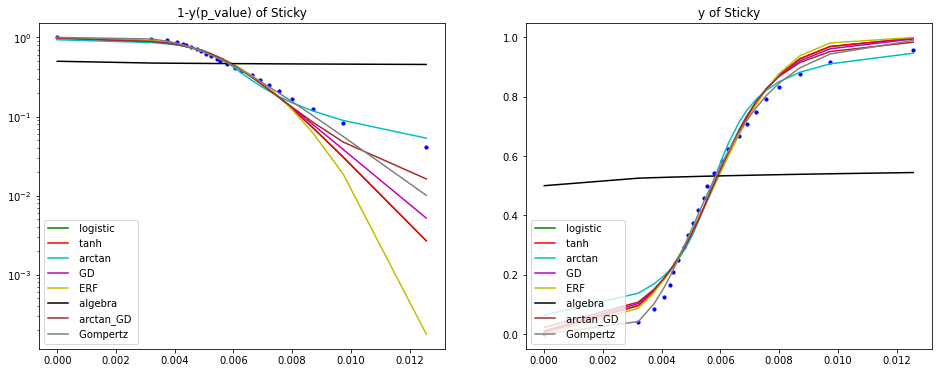

In [16]:
# Plotting fittings for all classes of AT species with binning
for i in range(len(classes[:-1])):
    data_i = data_distance(data(df_comb,classes[:-1][i]))
    sigmoids_for_class(data_i, classes[:-1][i], factors[i], functions, colors,binning=True)

#### CE

items in each bin:  [22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 21, 21, 21, 21, 21, 21]
For  ER  :
curve_fit parameter on  logistic :  [19.67974268  0.16737684]
curve_fit parameter on  tanh :  [19.67973911  0.08368848]
curve_fit parameter on  arctan :  [19.44032271  0.17071112]
curve_fit parameter on  GD :  [19.64117604  0.06834422]
curve_fit parameter on  ERF :  [19.73146082  0.07098059]
curve_fit parameter on  algebra :  [18.70986096  0.19060088]
curve_fit parameter on  arctan_GD :  [19.58060229  0.08023494  0.79057039]
curve_fit parameter on  Gompertz :  [1.82153756 0.11364527]


C:\Users\SHIQIJ~1\AppData\Local\Temp/ipykernel_3572/217763432.py:24: RuntimeWarning: divide by zero encountered in power
  m = (1+x/((1+abs(x)**k)**(1/k)))/2
C:\Users\SHIQIJ~1\AppData\Local\Temp/ipykernel_3572/217763432.py:24: RuntimeWarning: invalid value encountered in true_divide
  m = (1+x/((1+abs(x)**k)**(1/k)))/2
D:\anaconda\anaconda\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
C:\Users\SHIQIJ~1\AppData\Local\Temp/ipykernel_3572/217763432.py:32: RuntimeWarning: overflow encountered in power
  m = np.e**(-np.e**(b-c*x))


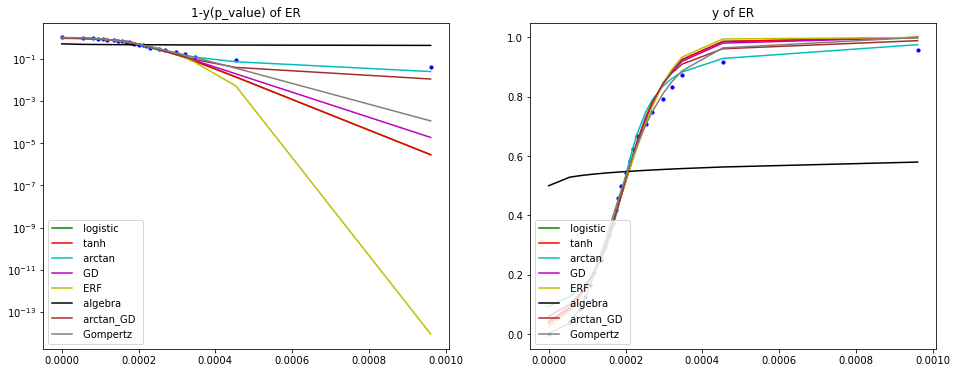

items in each bin:  [22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 21, 21, 21, 21, 21, 21]
For  ERDD  :
curve_fit parameter on  logistic :  [1.13746416 3.65241728]
curve_fit parameter on  tanh :  [1.13746436 1.82620707]
curve_fit parameter on  arctan :  [1.12137361 3.63648897]
curve_fit parameter on  GD :  [1.13507385 1.48355731]
curve_fit parameter on  ERF :  [1.14063739 1.55858245]
curve_fit parameter on  algebra :  [1.08467194 0.29971512]
curve_fit parameter on  arctan_GD :  [ 1.1314702   8.24133632 -0.92805654]
curve_fit parameter on  Gompertz :  [2.47720747 2.54474602]


C:\Users\SHIQIJ~1\AppData\Local\Temp/ipykernel_3572/217763432.py:24: RuntimeWarning: divide by zero encountered in power
  m = (1+x/((1+abs(x)**k)**(1/k)))/2
C:\Users\SHIQIJ~1\AppData\Local\Temp/ipykernel_3572/217763432.py:24: RuntimeWarning: invalid value encountered in true_divide
  m = (1+x/((1+abs(x)**k)**(1/k)))/2
D:\anaconda\anaconda\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


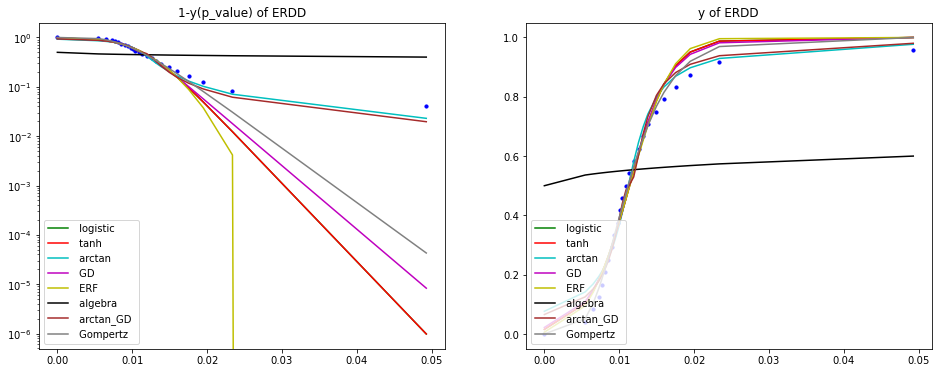

items in each bin:  [22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 21, 21, 21, 21, 21, 21, 21]
For  GEO  :
curve_fit parameter on  logistic :  [16.88124302  0.25628351]
curve_fit parameter on  tanh :  [16.88124501  0.12814173]
curve_fit parameter on  arctan :  [16.74470262  0.25281827]
curve_fit parameter on  GD :  [16.86262886  0.10398031]
curve_fit parameter on  ERF :  [16.90592968  0.10948613]
curve_fit parameter on  algebra :  [16.24243101  0.17940941]
curve_fit parameter on  arctan_GD :  [16.87418064  0.55172886 -0.87807211]
curve_fit parameter on  Gompertz :  [2.56485766 0.1766948 ]


C:\Users\SHIQIJ~1\AppData\Local\Temp/ipykernel_3572/217763432.py:24: RuntimeWarning: divide by zero encountered in power
  m = (1+x/((1+abs(x)**k)**(1/k)))/2
C:\Users\SHIQIJ~1\AppData\Local\Temp/ipykernel_3572/217763432.py:24: RuntimeWarning: invalid value encountered in true_divide
  m = (1+x/((1+abs(x)**k)**(1/k)))/2
D:\anaconda\anaconda\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
C:\Users\SHIQIJ~1\AppData\Local\Temp/ipykernel_3572/217763432.py:32: RuntimeWarning: overflow encountered in power
  m = np.e**(-np.e**(b-c*x))


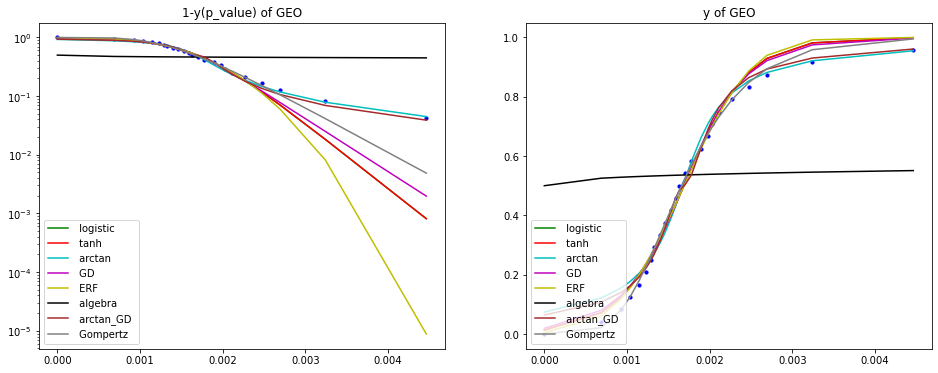

items in each bin:  [22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21]
For  GEOGD  :
curve_fit parameter on  logistic :  [3.03730585 0.7219329 ]
curve_fit parameter on  tanh :  [3.03734551 0.36095358]
curve_fit parameter on  arctan :  [2.86385915 0.73563421]
curve_fit parameter on  GD :  [3.01458182 0.29293635]
curve_fit parameter on  ERF :  [3.06808891 0.30794802]
curve_fit parameter on  algebra :  [2.47244613 0.28165942]
curve_fit parameter on  arctan_GD :  [ 3.03527655  2.06072871 -1.40539688]
curve_fit parameter on  Gompertz :  [1.14393898 0.51568285]


C:\Users\SHIQIJ~1\AppData\Local\Temp/ipykernel_3572/217763432.py:24: RuntimeWarning: divide by zero encountered in power
  m = (1+x/((1+abs(x)**k)**(1/k)))/2
C:\Users\SHIQIJ~1\AppData\Local\Temp/ipykernel_3572/217763432.py:24: RuntimeWarning: invalid value encountered in true_divide
  m = (1+x/((1+abs(x)**k)**(1/k)))/2
D:\anaconda\anaconda\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


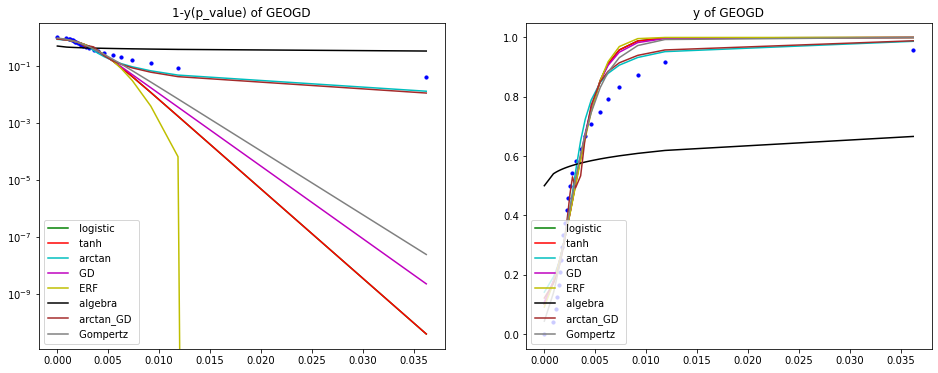

items in each bin:  [16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 15, 15, 15, 15, 15]
For  HGG  :
curve_fit parameter on  logistic :  [5.14559326 0.40368373]
curve_fit parameter on  tanh :  [5.14558677 0.2018425 ]
curve_fit parameter on  arctan :  [4.80252394 0.41307615]
curve_fit parameter on  GD :  [5.10262578 0.16373985]
curve_fit parameter on  ERF :  [5.20231142 0.17236596]
curve_fit parameter on  algebra :  [4.02942869 0.25351051]
curve_fit parameter on  arctan_GD :  [ 5.31104001  1.51273211 -2.16841937]
curve_fit parameter on  Gompertz :  [1.06478672 0.28954134]


C:\Users\SHIQIJ~1\AppData\Local\Temp/ipykernel_3572/217763432.py:24: RuntimeWarning: divide by zero encountered in power
  m = (1+x/((1+abs(x)**k)**(1/k)))/2
C:\Users\SHIQIJ~1\AppData\Local\Temp/ipykernel_3572/217763432.py:24: RuntimeWarning: invalid value encountered in true_divide
  m = (1+x/((1+abs(x)**k)**(1/k)))/2
D:\anaconda\anaconda\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


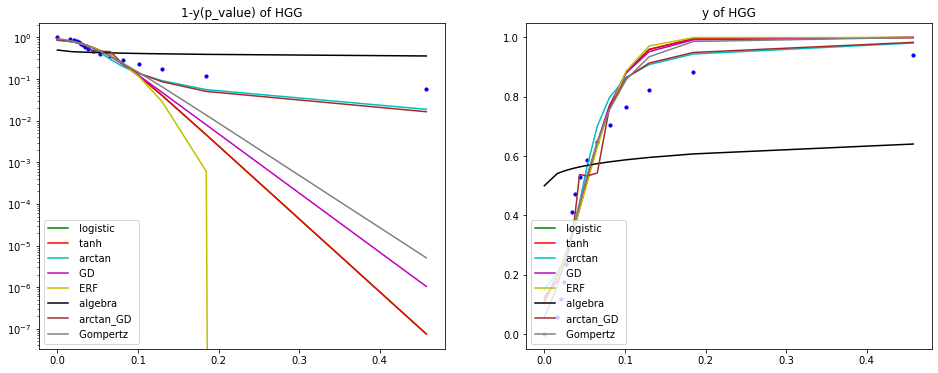

items in each bin:  [22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 21, 21, 21, 21, 21, 21, 21]
For  SF  :
curve_fit parameter on  logistic :  [9.52245516 0.51248981]
curve_fit parameter on  tanh :  [9.52245395 0.25624497]
curve_fit parameter on  arctan :  [9.43662909 0.5117897 ]
curve_fit parameter on  GD :  [9.51053361 0.2081854 ]
curve_fit parameter on  ERF :  [9.53743344 0.2186391 ]
curve_fit parameter on  algebra :  [9.20819632 0.18869462]
curve_fit parameter on  arctan_GD :  [ 9.49599293  1.0870769  -0.82860722]
curve_fit parameter on  Gompertz :  [2.94047753 0.3521497 ]


C:\Users\SHIQIJ~1\AppData\Local\Temp/ipykernel_3572/217763432.py:24: RuntimeWarning: divide by zero encountered in power
  m = (1+x/((1+abs(x)**k)**(1/k)))/2
C:\Users\SHIQIJ~1\AppData\Local\Temp/ipykernel_3572/217763432.py:24: RuntimeWarning: invalid value encountered in true_divide
  m = (1+x/((1+abs(x)**k)**(1/k)))/2
D:\anaconda\anaconda\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


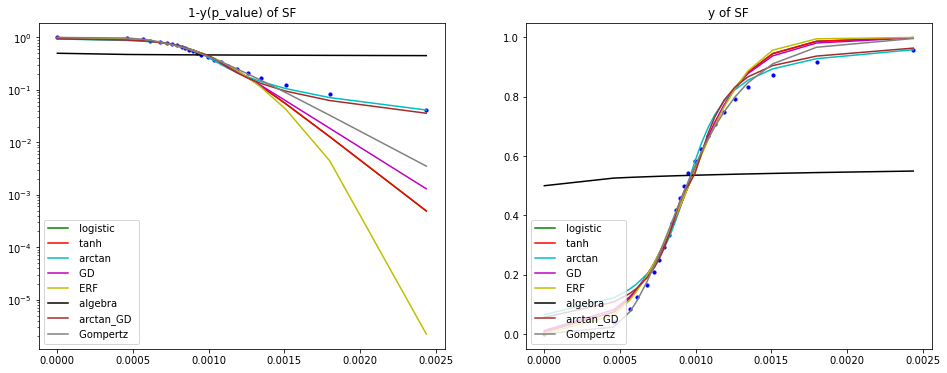

items in each bin:  [22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 21, 21, 21, 21, 21]
For  SFDD  :
curve_fit parameter on  logistic :  [2.41783943 1.06377599]
curve_fit parameter on  tanh :  [2.41783476 0.53189142]
curve_fit parameter on  arctan :  [2.32341499 1.08321449]
curve_fit parameter on  GD :  [2.40320202 0.43307304]
curve_fit parameter on  ERF :  [2.43897373 0.45138858]
curve_fit parameter on  algebra :  [2.18925823 0.28540336]
curve_fit parameter on  arctan_GD :  [2.33228759 0.78940948 0.31492124]
curve_fit parameter on  Gompertz :  [1.38934934 0.7458292 ]


C:\Users\SHIQIJ~1\AppData\Local\Temp/ipykernel_3572/217763432.py:24: RuntimeWarning: divide by zero encountered in power
  m = (1+x/((1+abs(x)**k)**(1/k)))/2
C:\Users\SHIQIJ~1\AppData\Local\Temp/ipykernel_3572/217763432.py:24: RuntimeWarning: invalid value encountered in true_divide
  m = (1+x/((1+abs(x)**k)**(1/k)))/2
D:\anaconda\anaconda\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


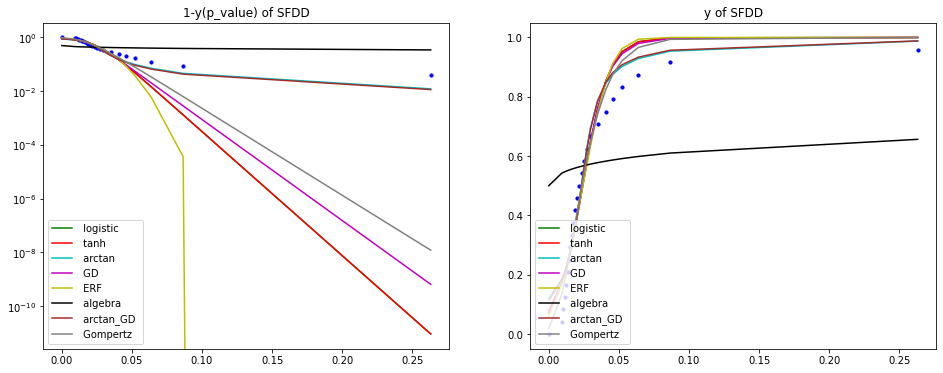

items in each bin:  [22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 21, 21, 21, 21, 21, 21, 21]
For  Sticky  :
curve_fit parameter on  logistic :  [8.04471967 0.6968473 ]
curve_fit parameter on  tanh :  [8.04471947 0.3484237 ]
curve_fit parameter on  arctan :  [8.00698699 0.68904584]
curve_fit parameter on  GD :  [8.03948343 0.28286389]
curve_fit parameter on  ERF :  [8.05156108 0.29770447]
curve_fit parameter on  algebra :  [7.85083221 0.18322561]
curve_fit parameter on  arctan_GD :  [8.03606495 0.29850525 0.92413823]
curve_fit parameter on  Gompertz :  [3.42949201 0.47877474]


C:\Users\SHIQIJ~1\AppData\Local\Temp/ipykernel_3572/217763432.py:24: RuntimeWarning: divide by zero encountered in power
  m = (1+x/((1+abs(x)**k)**(1/k)))/2
C:\Users\SHIQIJ~1\AppData\Local\Temp/ipykernel_3572/217763432.py:24: RuntimeWarning: invalid value encountered in true_divide
  m = (1+x/((1+abs(x)**k)**(1/k)))/2
D:\anaconda\anaconda\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


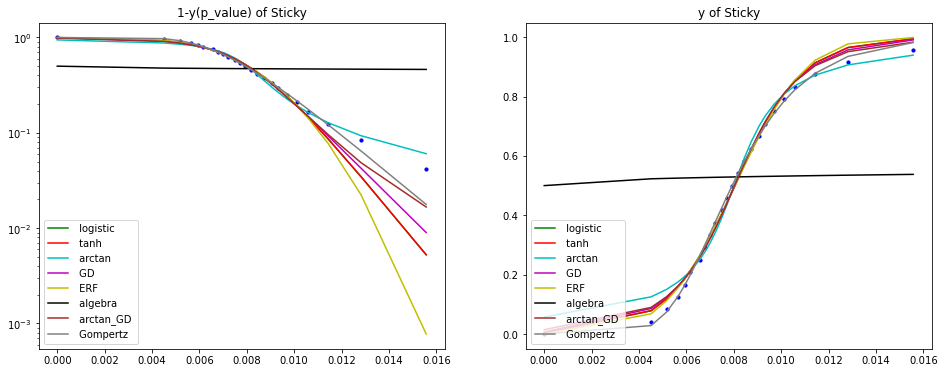

In [17]:
for i in range(len(classes[:-1])):
    data_i = data_distance(data(df_CE,classes[:-1][i]))
    sigmoids_for_class(data_i, classes[:-1][i], factors[i], functions, colors,binning=True)

#### DM

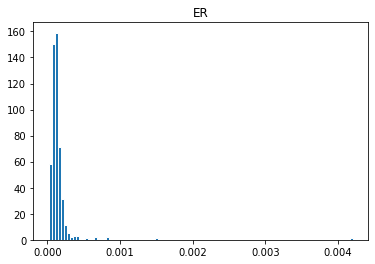

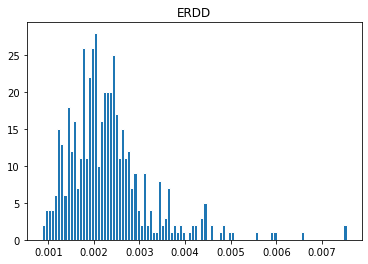

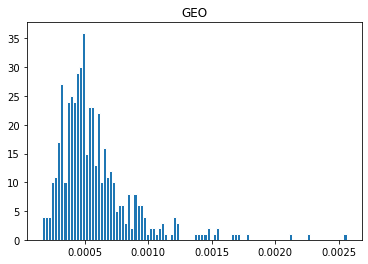

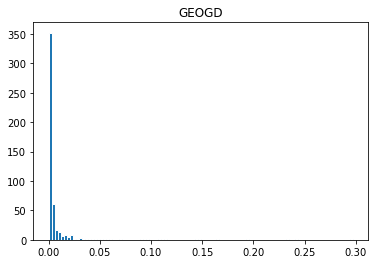

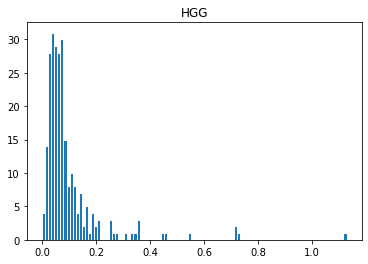

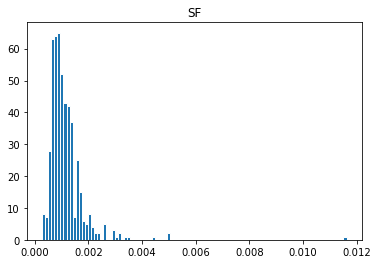

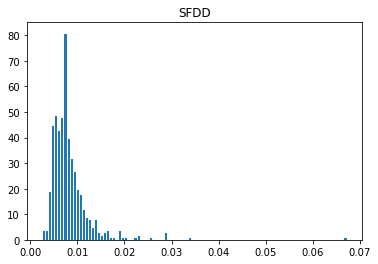

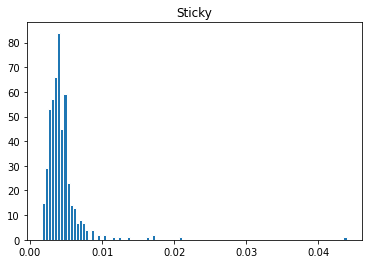

In [39]:
df_DM = data_frame("DM")
for c in classes[:-1]:
    plot_data_distance(data_distance(data(df_DM,c)), c)

In [40]:
factors_DM = [1e-4,1e-4,1e-4,1e-2,1e-1,1e-3,1e-3,1e-3]

items in each bin:  [22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 21, 21, 21, 21, 21, 21]
For  ER  :
curve_fit parameter on  logistic :  [1.12777593 3.21902618]
curve_fit parameter on  tanh :  [1.12777603 1.60951221]
curve_fit parameter on  arctan :  [1.11726746 3.23851936]
curve_fit parameter on  GD :  [1.12605607 1.31165343]
curve_fit parameter on  ERF :  [1.13019514 1.36745231]
curve_fit parameter on  algebra :  [1.10542107 0.3220979 ]
curve_fit parameter on  arctan_GD :  [1.1245133  1.42720416 0.88529334]
curve_fit parameter on  Gompertz :  [2.07253844 2.2083616 ]


C:\Users\SHIQIJ~1\AppData\Local\Temp/ipykernel_3572/217763432.py:24: RuntimeWarning: divide by zero encountered in power
  m = (1+x/((1+abs(x)**k)**(1/k)))/2
C:\Users\SHIQIJ~1\AppData\Local\Temp/ipykernel_3572/217763432.py:24: RuntimeWarning: invalid value encountered in true_divide
  m = (1+x/((1+abs(x)**k)**(1/k)))/2
D:\anaconda\anaconda\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


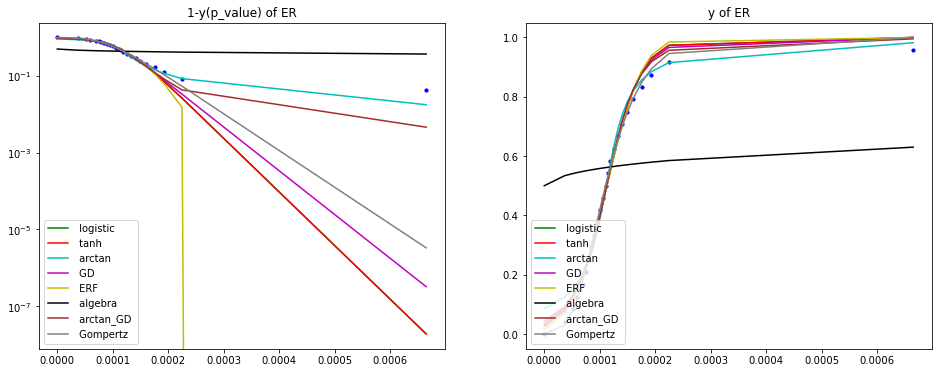

items in each bin:  [22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 21, 21, 21, 21, 21, 21]
For  ERDD  :
curve_fit parameter on  logistic :  [21.91957915  0.22752152]
curve_fit parameter on  tanh :  [21.91957931  0.11376075]
curve_fit parameter on  arctan :  [21.8842308   0.22503776]
curve_fit parameter on  GD :  [21.91561938  0.09239476]
curve_fit parameter on  ERF :  [21.92671647  0.0970626 ]
curve_fit parameter on  algebra :  [21.69148349  0.16867071]
curve_fit parameter on  arctan_GD :  [21.86095385  0.47932261 -0.81660227]
curve_fit parameter on  Gompertz :  [    2.23979697 -1887.23911997]


C:\Users\SHIQIJ~1\AppData\Local\Temp/ipykernel_3572/217763432.py:24: RuntimeWarning: divide by zero encountered in power
  m = (1+x/((1+abs(x)**k)**(1/k)))/2
C:\Users\SHIQIJ~1\AppData\Local\Temp/ipykernel_3572/217763432.py:24: RuntimeWarning: invalid value encountered in true_divide
  m = (1+x/((1+abs(x)**k)**(1/k)))/2
D:\anaconda\anaconda\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
C:\Users\SHIQIJ~1\AppData\Local\Temp/ipykernel_3572/217763432.py:32: RuntimeWarning: overflow encountered in power
  m = np.e**(-np.e**(b-c*x))
D:\anaconda\anaconda\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


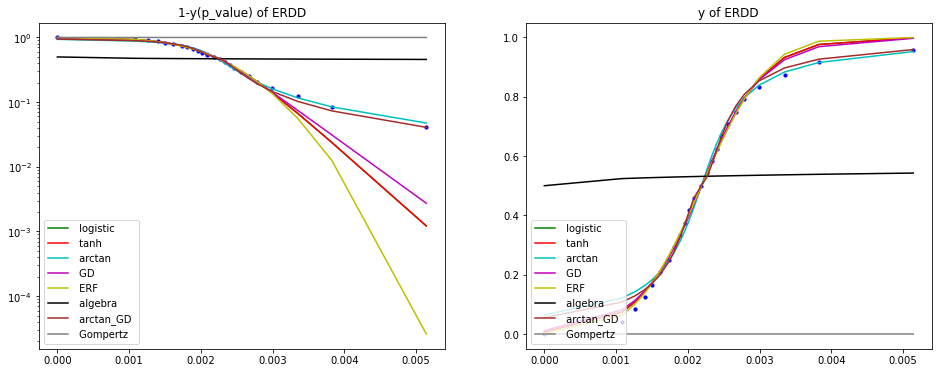

items in each bin:  [22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 21, 21, 21, 21, 21, 21]
For  GEO  :
curve_fit parameter on  logistic :  [5.22479527 0.76967766]
curve_fit parameter on  tanh :  [5.22479744 0.38483791]
curve_fit parameter on  arctan :  [5.15934205 0.77120717]
curve_fit parameter on  GD :  [5.21539456 0.31288037]
curve_fit parameter on  ERF :  [5.23718769 0.32805005]
curve_fit parameter on  algebra :  [4.9413454  0.21581665]
curve_fit parameter on  arctan_GD :  [5.19546546 0.38138859 0.7416034 ]
curve_fit parameter on  Gompertz :  [2.35567746 0.53021923]


C:\Users\SHIQIJ~1\AppData\Local\Temp/ipykernel_3572/217763432.py:24: RuntimeWarning: divide by zero encountered in power
  m = (1+x/((1+abs(x)**k)**(1/k)))/2
C:\Users\SHIQIJ~1\AppData\Local\Temp/ipykernel_3572/217763432.py:24: RuntimeWarning: invalid value encountered in true_divide
  m = (1+x/((1+abs(x)**k)**(1/k)))/2
D:\anaconda\anaconda\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


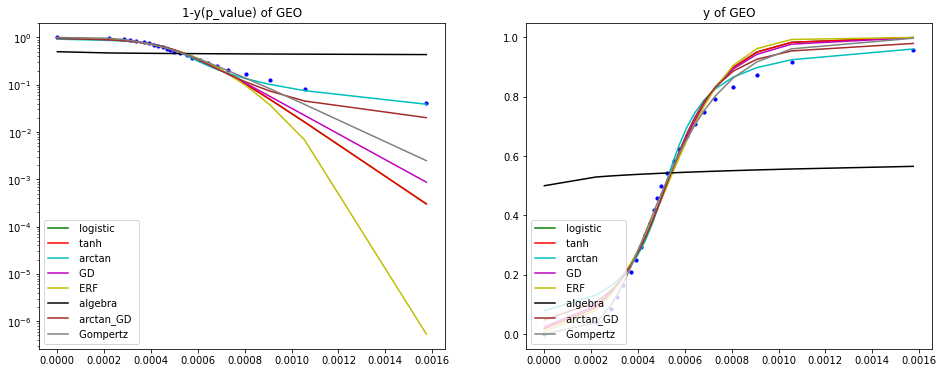

items in each bin:  [22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 21, 21, 21, 21, 21]
For  GEOGD  :
curve_fit parameter on  logistic :  [0.19314282 9.75701484]
curve_fit parameter on  tanh :  [0.19314275 4.87851112]
curve_fit parameter on  arctan :  [0.18265426 9.46285072]
curve_fit parameter on  GD :  [0.19172077 3.942679  ]
curve_fit parameter on  ERF :  [0.19523415 4.17568183]
curve_fit parameter on  algebra :  [0.15144217 1.71426716]
curve_fit parameter on  arctan_GD :  [0.18339459 7.48889287 0.23411845]
curve_fit parameter on  Gompertz :  [0.90943102 6.87368464]


D:\anaconda\anaconda\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


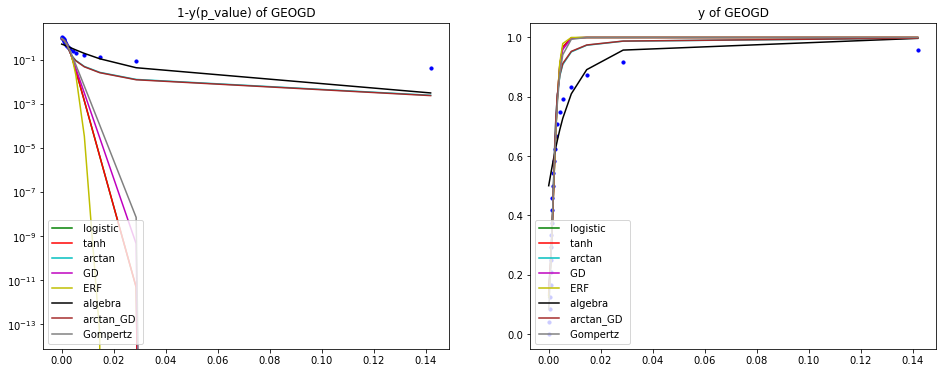

items in each bin:  [16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 15, 15, 15, 15, 15]
For  HGG  :
curve_fit parameter on  logistic :  [0.68568215 3.59665144]
curve_fit parameter on  tanh :  [0.68568211 1.79832599]
curve_fit parameter on  arctan :  [0.66947367 3.55228186]
curve_fit parameter on  GD :  [0.68339493 1.45931504]
curve_fit parameter on  ERF :  [0.68874772 1.53758006]
curve_fit parameter on  algebra :  [0.62189548 0.45273497]
curve_fit parameter on  arctan_GD :  [0.67472553 2.05532235 0.5653283 ]
curve_fit parameter on  Gompertz :  [1.25183432 2.42163072]


D:\anaconda\anaconda\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


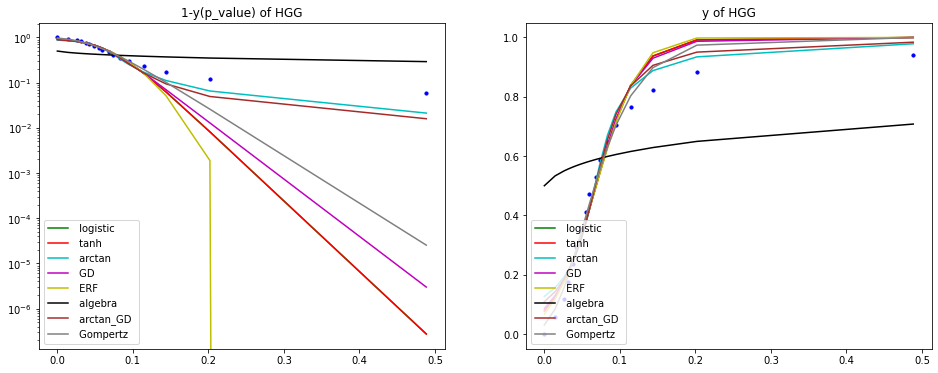

items in each bin:  [22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 21, 21, 21, 21, 21, 21]
For  SF  :
curve_fit parameter on  logistic :  [1.03094085 3.9289249 ]
curve_fit parameter on  tanh :  [1.03094038 1.96446607]
curve_fit parameter on  arctan :  [1.01912458 3.87724585]
curve_fit parameter on  GD :  [1.0292009 1.5950247]
curve_fit parameter on  ERF :  [1.03328914 1.67716967]
curve_fit parameter on  algebra :  [0.97814955 0.30733346]
curve_fit parameter on  arctan_GD :  [ 1.02646317  8.48563205 -0.88389486]
curve_fit parameter on  Gompertz :  [2.39901129 2.73629766]


C:\Users\SHIQIJ~1\AppData\Local\Temp/ipykernel_3572/217763432.py:24: RuntimeWarning: divide by zero encountered in power
  m = (1+x/((1+abs(x)**k)**(1/k)))/2
C:\Users\SHIQIJ~1\AppData\Local\Temp/ipykernel_3572/217763432.py:24: RuntimeWarning: invalid value encountered in true_divide
  m = (1+x/((1+abs(x)**k)**(1/k)))/2
D:\anaconda\anaconda\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


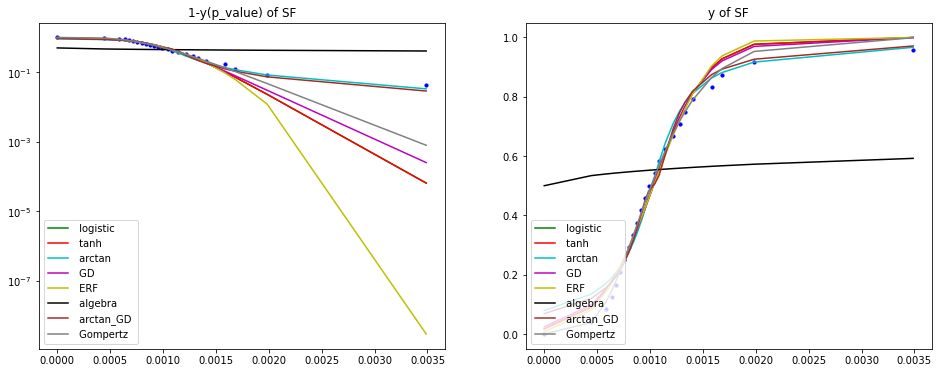

items in each bin:  [22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 21, 21, 21, 21, 21]
For  SFDD  :
curve_fit parameter on  logistic :  [7.52833314 0.62953471]
curve_fit parameter on  tanh :  [7.52833034 0.31476792]
curve_fit parameter on  arctan :  [7.46800479 0.64017698]
curve_fit parameter on  GD :  [7.51880832 0.25632842]
curve_fit parameter on  ERF :  [7.54146321 0.26800705]
curve_fit parameter on  algebra :  [7.36143389 0.19716456]
curve_fit parameter on  arctan_GD :  [ 7.47860664  1.05732622 -0.5211684 ]
curve_fit parameter on  Gompertz :  [2.8184253  0.42935864]


C:\Users\SHIQIJ~1\AppData\Local\Temp/ipykernel_3572/217763432.py:24: RuntimeWarning: divide by zero encountered in power
  m = (1+x/((1+abs(x)**k)**(1/k)))/2
C:\Users\SHIQIJ~1\AppData\Local\Temp/ipykernel_3572/217763432.py:24: RuntimeWarning: invalid value encountered in true_divide
  m = (1+x/((1+abs(x)**k)**(1/k)))/2
D:\anaconda\anaconda\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


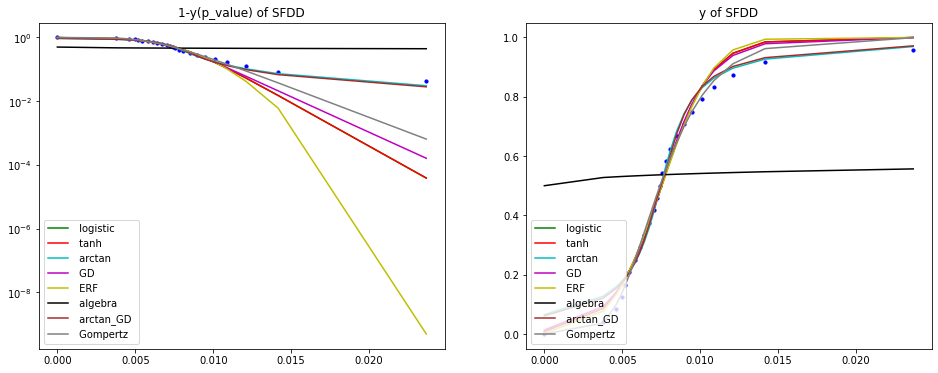

items in each bin:  [22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 21, 21, 21, 21, 21, 21]
For  Sticky  :
curve_fit parameter on  logistic :  [3.99292171 1.28224865]
curve_fit parameter on  tanh :  [3.99292157 0.64112449]
curve_fit parameter on  arctan :  [3.98213002 1.26218906]
curve_fit parameter on  GD :  [3.99153797 0.52031837]
curve_fit parameter on  ERF :  [3.99475793 0.54794225]
curve_fit parameter on  algebra :  [3.96235508 0.21545262]
curve_fit parameter on  arctan_GD :  [3.98956105 0.5735664  0.86374607]
curve_fit parameter on  Gompertz :  [3.060875   0.87155592]


C:\Users\SHIQIJ~1\AppData\Local\Temp/ipykernel_3572/217763432.py:24: RuntimeWarning: divide by zero encountered in power
  m = (1+x/((1+abs(x)**k)**(1/k)))/2
C:\Users\SHIQIJ~1\AppData\Local\Temp/ipykernel_3572/217763432.py:24: RuntimeWarning: invalid value encountered in true_divide
  m = (1+x/((1+abs(x)**k)**(1/k)))/2
D:\anaconda\anaconda\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


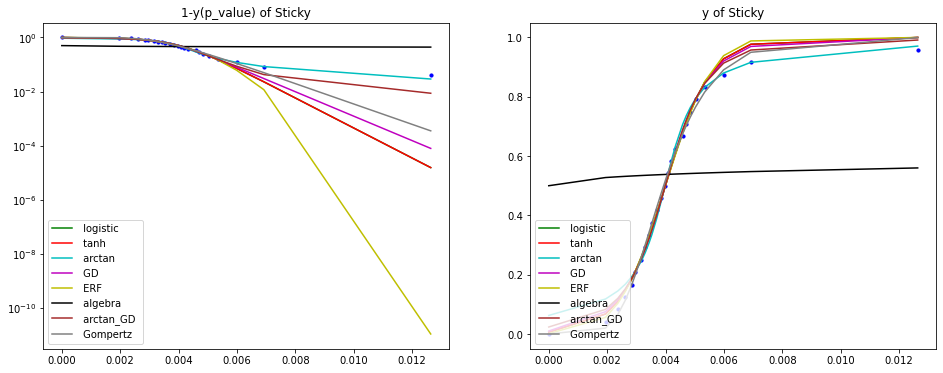

In [41]:
for i in range(len(classes[:-1])):
    data_i = data_distance(data(df_DM,classes[:-1][i]))
    sigmoids_for_class(data_i, classes[:-1][i], factors_DM[i], functions, colors,binning=True)

#### EC

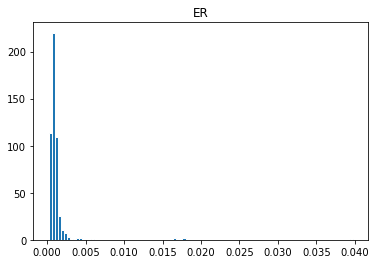

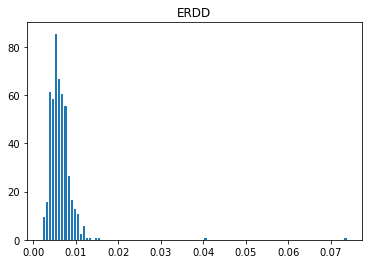

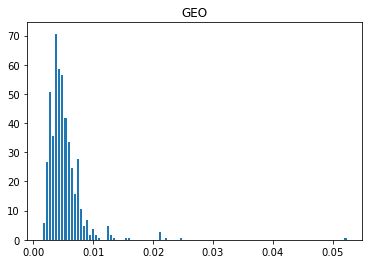

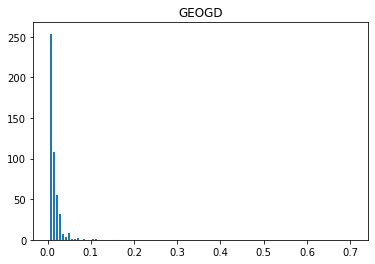

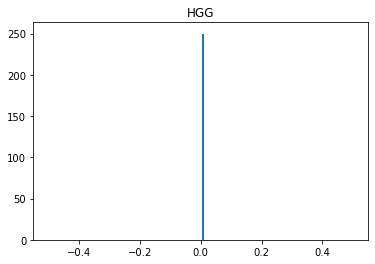

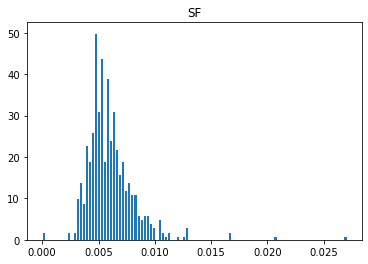

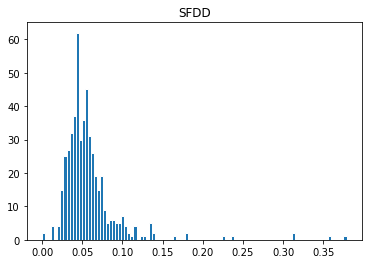

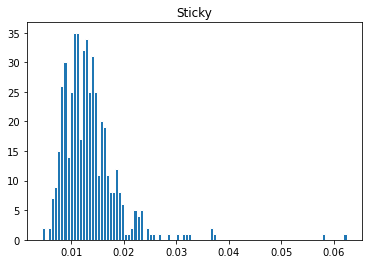

In [42]:
df_EC = data_frame("EC")
for c in classes[:-1]:
    plot_data_distance(data_distance(data(df_EC,c)), c)

In [43]:
factors_EC = [1e-3,1e-3,1e-3,1e-2,1e-2,1e-3,1e-2,1e-3]

items in each bin:  [22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 21, 21, 21, 21, 21, 21, 21, 21]
For  ER  :
curve_fit parameter on  logistic :  [0.827452   4.03788029]
curve_fit parameter on  tanh :  [0.82745199 2.01893894]
curve_fit parameter on  arctan :  [0.81549451 4.08313249]
curve_fit parameter on  GD :  [0.82572216 1.64546141]
curve_fit parameter on  ERF :  [0.82940436 1.71885843]
curve_fit parameter on  algebra :  [0.78199871 0.37287888]
curve_fit parameter on  arctan_GD :  [0.82568234 1.6494274  0.99659512]
curve_fit parameter on  Gompertz :  [1.88021199 2.78016305]


C:\Users\SHIQIJ~1\AppData\Local\Temp/ipykernel_3572/217763432.py:24: RuntimeWarning: divide by zero encountered in power
  m = (1+x/((1+abs(x)**k)**(1/k)))/2
C:\Users\SHIQIJ~1\AppData\Local\Temp/ipykernel_3572/217763432.py:24: RuntimeWarning: invalid value encountered in true_divide
  m = (1+x/((1+abs(x)**k)**(1/k)))/2
D:\anaconda\anaconda\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


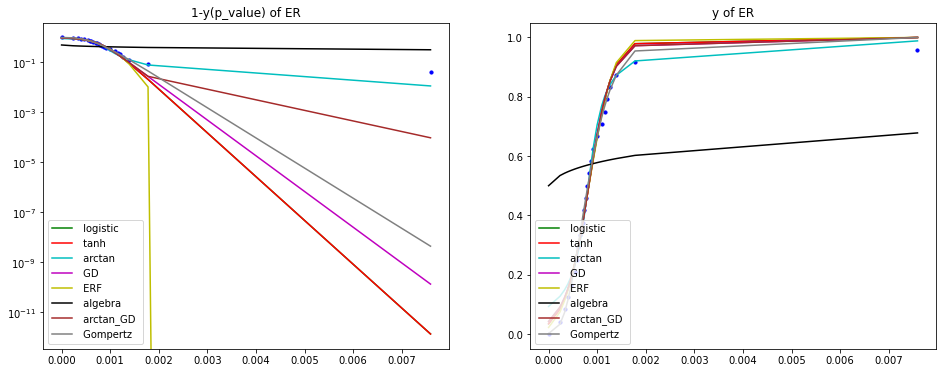

items in each bin:  [22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 21, 21, 21, 21, 21, 21]
For  ERDD  :
curve_fit parameter on  logistic :  [5.97154314 0.82571468]
curve_fit parameter on  tanh :  [5.97154331 0.41285734]
curve_fit parameter on  arctan :  [5.94378629 0.81471507]
curve_fit parameter on  GD :  [5.96752006 0.3355847 ]
curve_fit parameter on  ERF :  [5.97690698 0.3520493 ]
curve_fit parameter on  algebra :  [5.84411662 0.20025715]
curve_fit parameter on  arctan_GD :  [5.96707678 0.3391581  0.98459868]
curve_fit parameter on  Gompertz :  [2.96034188 0.56682061]


C:\Users\SHIQIJ~1\AppData\Local\Temp/ipykernel_3572/217763432.py:24: RuntimeWarning: divide by zero encountered in power
  m = (1+x/((1+abs(x)**k)**(1/k)))/2
C:\Users\SHIQIJ~1\AppData\Local\Temp/ipykernel_3572/217763432.py:24: RuntimeWarning: invalid value encountered in true_divide
  m = (1+x/((1+abs(x)**k)**(1/k)))/2
D:\anaconda\anaconda\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


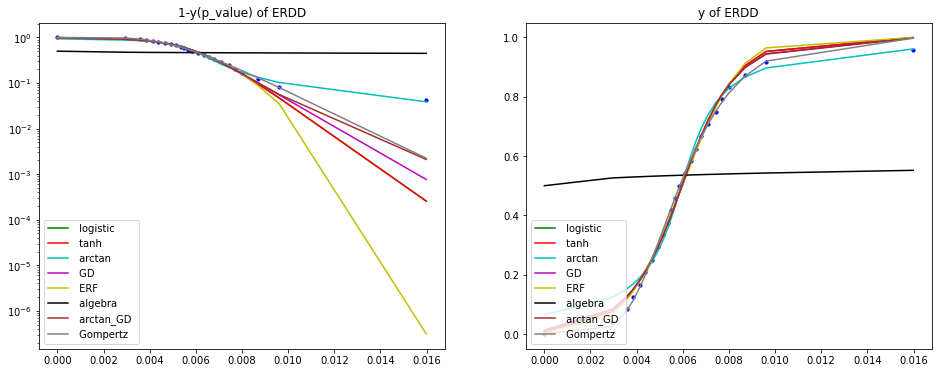

items in each bin:  [22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 21, 21, 21, 21, 21, 21]
For  GEO  :
curve_fit parameter on  logistic :  [4.6480302  0.85506682]
curve_fit parameter on  tanh :  [4.64803315 0.42753218]
curve_fit parameter on  arctan :  [4.59851512 0.85697524]
curve_fit parameter on  GD :  [4.63977055 0.34837561]
curve_fit parameter on  ERF :  [4.65967356 0.36327142]
curve_fit parameter on  algebra :  [4.50457213 0.22101517]
curve_fit parameter on  arctan_GD :  [4.63292752 0.37870296 0.88589145]
curve_fit parameter on  Gompertz :  [2.32847578 0.59146672]


C:\Users\SHIQIJ~1\AppData\Local\Temp/ipykernel_3572/217763432.py:24: RuntimeWarning: divide by zero encountered in power
  m = (1+x/((1+abs(x)**k)**(1/k)))/2
C:\Users\SHIQIJ~1\AppData\Local\Temp/ipykernel_3572/217763432.py:24: RuntimeWarning: invalid value encountered in true_divide
  m = (1+x/((1+abs(x)**k)**(1/k)))/2
D:\anaconda\anaconda\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


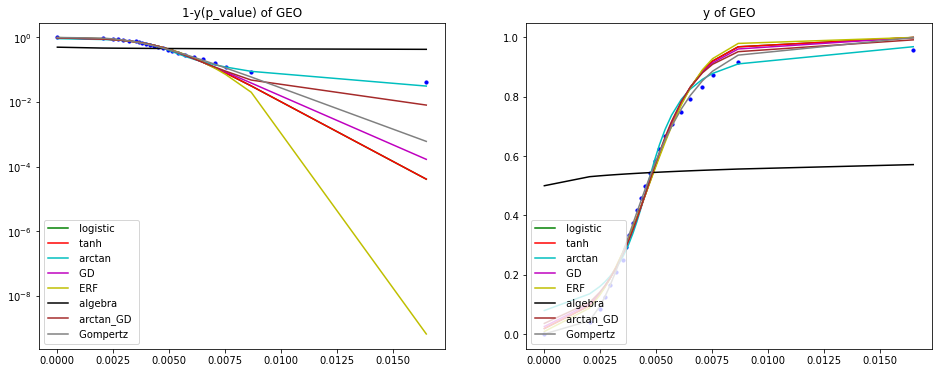

items in each bin:  [22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21]
For  GEOGD  :
curve_fit parameter on  logistic :  [1.0742005  2.07462082]
curve_fit parameter on  tanh :  [1.07419446 1.03732483]
curve_fit parameter on  arctan :  [1.03269533 2.0294058 ]
curve_fit parameter on  GD :  [1.06807022 0.84071209]
curve_fit parameter on  ERF :  [1.08304538 0.88581147]
curve_fit parameter on  algebra :  [0.87318957 0.37730049]
curve_fit parameter on  arctan_GD :  [ 1.04623231  5.35684586 -1.181506  ]
curve_fit parameter on  Gompertz :  [1.15995951 1.48062089]


C:\Users\SHIQIJ~1\AppData\Local\Temp/ipykernel_3572/217763432.py:24: RuntimeWarning: divide by zero encountered in power
  m = (1+x/((1+abs(x)**k)**(1/k)))/2
C:\Users\SHIQIJ~1\AppData\Local\Temp/ipykernel_3572/217763432.py:24: RuntimeWarning: invalid value encountered in true_divide
  m = (1+x/((1+abs(x)**k)**(1/k)))/2
D:\anaconda\anaconda\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


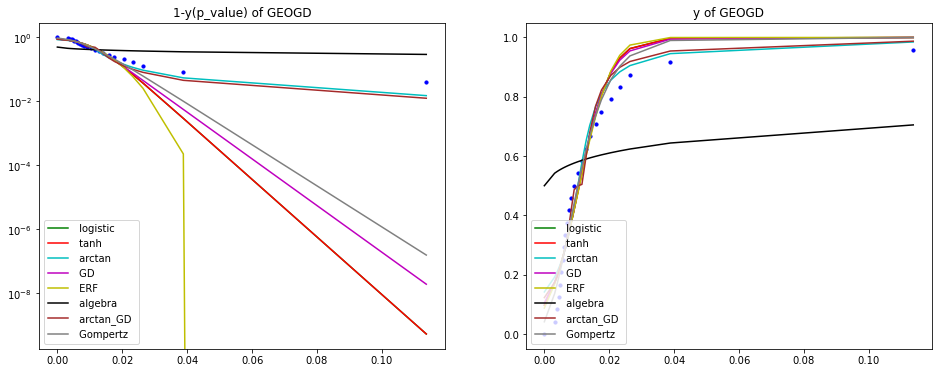

items in each bin:  [16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 15, 15, 15, 15, 15]
For  HGG  :
curve_fit parameter on  logistic :  [0.12061369 0.97593958]
curve_fit parameter on  tanh :  [0.06030684 0.97593958]
curve_fit parameter on  arctan :  [0.09447732 0.98078227]
curve_fit parameter on  GD :  [0.04538916 1.01928811]
curve_fit parameter on  ERF :  [0.05092246 1.02409032]
curve_fit parameter on  algebra :  [0. 1.]
curve_fit parameter on  arctan_GD :  [0.06270825 1.00026461 0.47584491]
curve_fit parameter on  Gompertz :  [-0.2826656  1.       ]


D:\anaconda\anaconda\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
D:\anaconda\anaconda\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


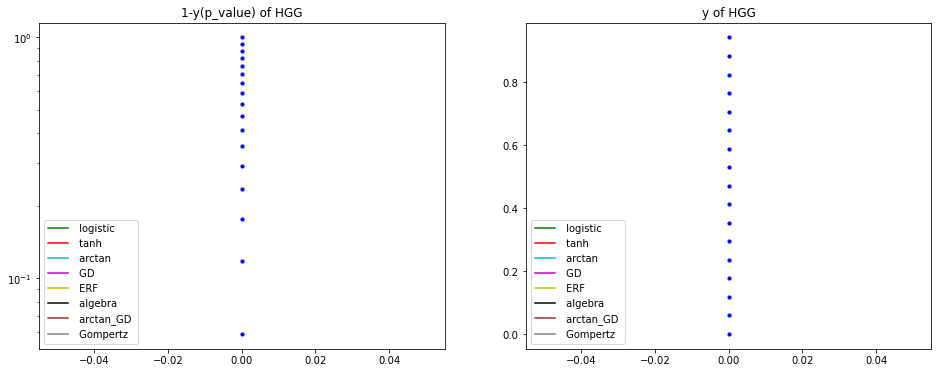

items in each bin:  [22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 21, 21, 21, 21, 21, 21, 21]
For  SF  :
curve_fit parameter on  logistic :  [5.75005223 0.93032016]
curve_fit parameter on  tanh :  [5.75005277 0.46515976]
curve_fit parameter on  arctan :  [5.71571859 0.9178888 ]
curve_fit parameter on  GD :  [5.74453697 0.37782011]
curve_fit parameter on  ERF :  [5.7577428  0.39667764]
curve_fit parameter on  algebra :  [5.63990983 0.19636965]
curve_fit parameter on  arctan_GD :  [5.74046445 0.4057609  0.90000538]
curve_fit parameter on  Gompertz :  [3.30757092 0.64849234]


C:\Users\SHIQIJ~1\AppData\Local\Temp/ipykernel_3572/217763432.py:24: RuntimeWarning: divide by zero encountered in power
  m = (1+x/((1+abs(x)**k)**(1/k)))/2
C:\Users\SHIQIJ~1\AppData\Local\Temp/ipykernel_3572/217763432.py:24: RuntimeWarning: invalid value encountered in true_divide
  m = (1+x/((1+abs(x)**k)**(1/k)))/2
D:\anaconda\anaconda\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


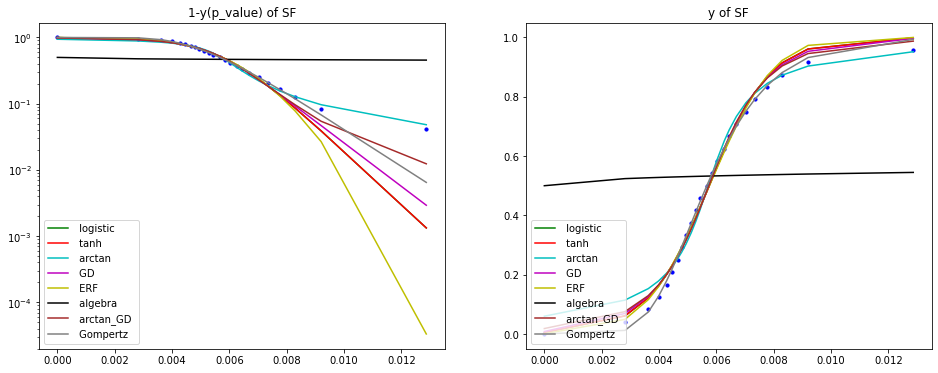

items in each bin:  [22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 21, 21, 21, 21, 21]
For  SFDD  :
curve_fit parameter on  logistic :  [5.16695992 0.81335829]
curve_fit parameter on  tanh :  [5.16696269 0.40667794]
curve_fit parameter on  arctan :  [5.12308456 0.80762999]
curve_fit parameter on  GD :  [5.16026107 0.33048868]
curve_fit parameter on  ERF :  [5.17586172 0.34691041]
curve_fit parameter on  algebra :  [5.03500266 0.21690658]
curve_fit parameter on  arctan_GD :  [5.14813804 0.39013359 0.77861538]
curve_fit parameter on  Gompertz :  [2.47639214 0.5596314 ]


C:\Users\SHIQIJ~1\AppData\Local\Temp/ipykernel_3572/217763432.py:24: RuntimeWarning: divide by zero encountered in power
  m = (1+x/((1+abs(x)**k)**(1/k)))/2
C:\Users\SHIQIJ~1\AppData\Local\Temp/ipykernel_3572/217763432.py:24: RuntimeWarning: invalid value encountered in true_divide
  m = (1+x/((1+abs(x)**k)**(1/k)))/2
D:\anaconda\anaconda\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


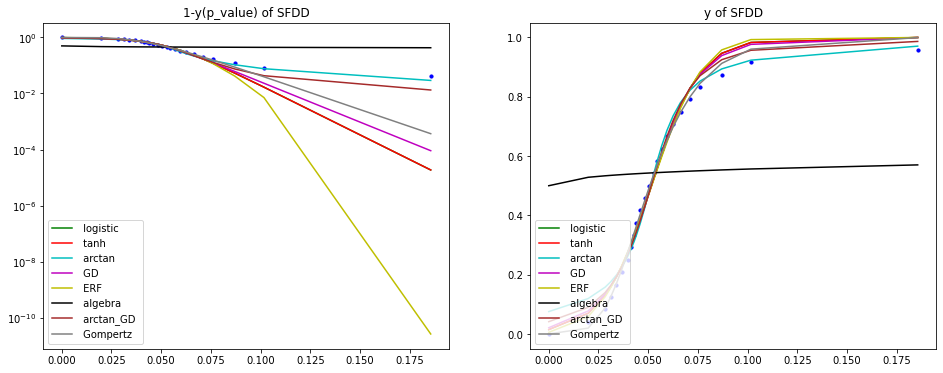

items in each bin:  [22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 21, 21, 21, 21, 21, 21]
For  Sticky  :
curve_fit parameter on  logistic :  [12.73198008  0.39461686]
curve_fit parameter on  tanh :  [12.73198204  0.19730819]
curve_fit parameter on  arctan :  [12.68657543  0.38968199]
curve_fit parameter on  GD :  [12.7242995   0.16032721]
curve_fit parameter on  ERF :  [12.74391129  0.16828674]
curve_fit parameter on  algebra :  [12.62301622  0.17858654]
curve_fit parameter on  arctan_GD :  [12.67944748  0.81343186 -0.80593993]
curve_fit parameter on  Gompertz :  [3.01604405 0.27012673]


C:\Users\SHIQIJ~1\AppData\Local\Temp/ipykernel_3572/217763432.py:24: RuntimeWarning: divide by zero encountered in power
  m = (1+x/((1+abs(x)**k)**(1/k)))/2
C:\Users\SHIQIJ~1\AppData\Local\Temp/ipykernel_3572/217763432.py:24: RuntimeWarning: invalid value encountered in true_divide
  m = (1+x/((1+abs(x)**k)**(1/k)))/2
D:\anaconda\anaconda\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
C:\Users\SHIQIJ~1\AppData\Local\Temp/ipykernel_3572/217763432.py:32: RuntimeWarning: overflow encountered in power
  m = np.e**(-np.e**(b-c*x))


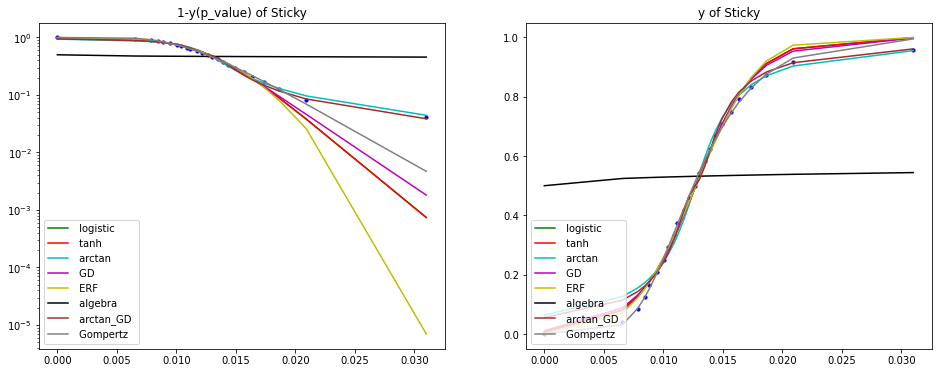

In [44]:
for i in range(len(classes[:-1])):
    data_i = data_distance(data(df_EC,classes[:-1][i]))
    sigmoids_for_class(data_i, classes[:-1][i], factors_EC[i], functions, colors,binning=True)

#### HS

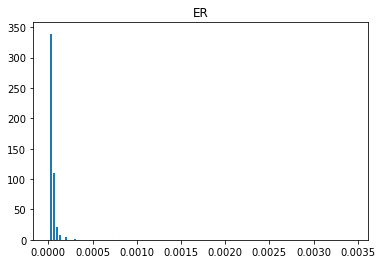

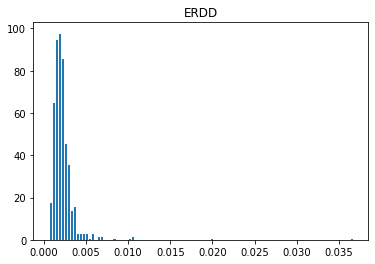

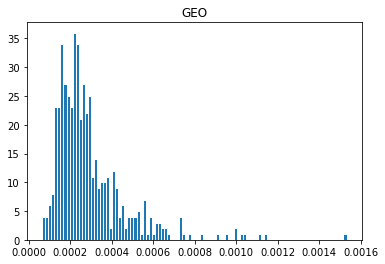

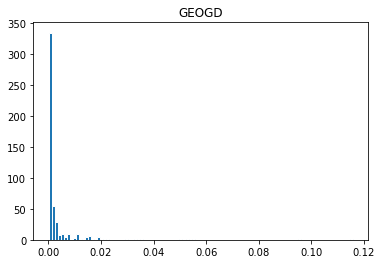

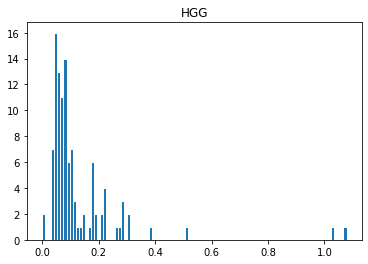

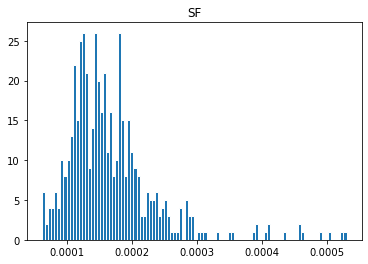

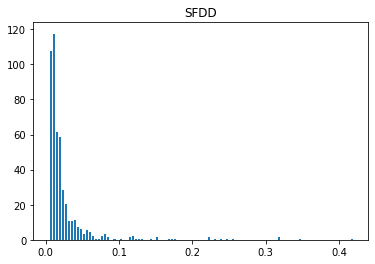

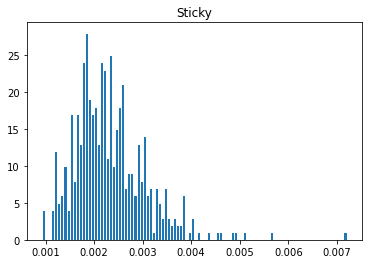

In [45]:
df_HS = data_frame("HS")
for c in classes[:-1]:
    plot_data_distance(data_distance(data(df_HS,c)), c)

In [46]:
factors_HS = [1e-4,1e-3,1e-4,1e-2,1e-2,1e-5,1e-2,1e-4]

items in each bin:  [22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 21, 21, 21, 21, 21, 21]
For  ER  :
curve_fit parameter on  logistic :  [ 0.29377203 10.28276769]
curve_fit parameter on  tanh :  [0.29377216 5.14137322]
curve_fit parameter on  arctan :  [ 0.28854931 10.22232021]
curve_fit parameter on  GD :  [0.29298464 4.17984732]
curve_fit parameter on  ERF :  [0.29482041 4.38301019]
curve_fit parameter on  algebra :  [0.28130741 0.87591896]
curve_fit parameter on  arctan_GD :  [0.29099413 5.34131594 0.68022092]
curve_fit parameter on  Gompertz :  [1.64842812 7.01825861]


D:\anaconda\anaconda\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


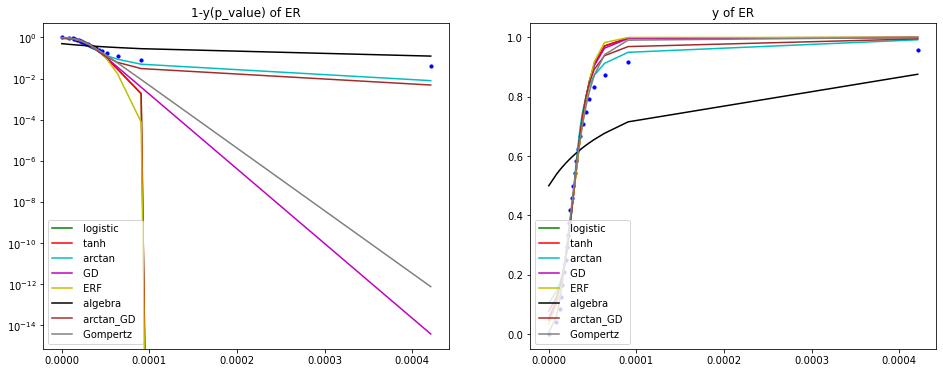

items in each bin:  [22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 21, 21, 21, 21, 21, 21]
For  ERDD  :
curve_fit parameter on  logistic :  [1.94698514 2.07382617]
curve_fit parameter on  tanh :  [1.94698504 1.0369128 ]
curve_fit parameter on  arctan :  [1.93592575 2.05268981]
curve_fit parameter on  GD :  [1.9451957  0.84302533]
curve_fit parameter on  ERF :  [1.94951516 0.88450775]
curve_fit parameter on  algebra :  [1.92121814 0.26542391]
curve_fit parameter on  arctan_GD :  [1.94399452 0.89245948 0.91979281]
curve_fit parameter on  Gompertz :  [2.33716127 1.41677062]


C:\Users\SHIQIJ~1\AppData\Local\Temp/ipykernel_3572/217763432.py:24: RuntimeWarning: divide by zero encountered in power
  m = (1+x/((1+abs(x)**k)**(1/k)))/2
C:\Users\SHIQIJ~1\AppData\Local\Temp/ipykernel_3572/217763432.py:24: RuntimeWarning: invalid value encountered in true_divide
  m = (1+x/((1+abs(x)**k)**(1/k)))/2
D:\anaconda\anaconda\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


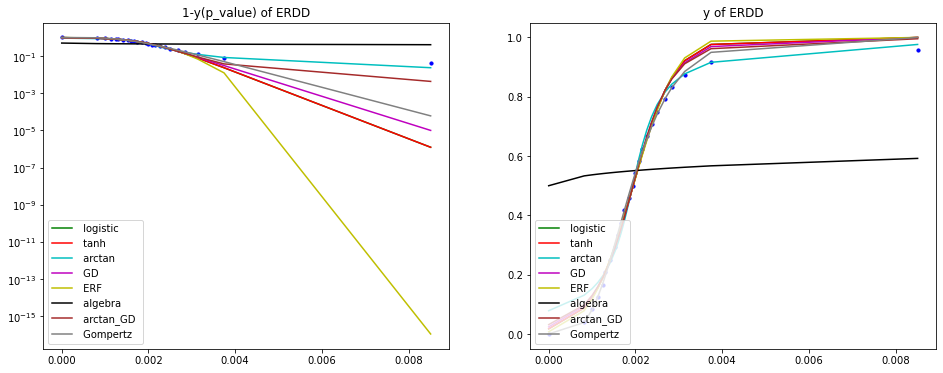

items in each bin:  [22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 21, 21, 21, 21, 21, 21]
For  GEO  :
curve_fit parameter on  logistic :  [2.57749858 1.35549696]
curve_fit parameter on  tanh :  [2.57749511 0.67775301]
curve_fit parameter on  arctan :  [2.53612473 1.36810554]
curve_fit parameter on  GD :  [2.57110711 0.55155123]
curve_fit parameter on  ERF :  [2.58632563 0.57697601]
curve_fit parameter on  algebra :  [2.46063473 0.25585904]
curve_fit parameter on  arctan_GD :  [2.55300461 0.72859726 0.65013794]
curve_fit parameter on  Gompertz :  [1.99332438 0.9338187 ]


C:\Users\SHIQIJ~1\AppData\Local\Temp/ipykernel_3572/217763432.py:24: RuntimeWarning: divide by zero encountered in power
  m = (1+x/((1+abs(x)**k)**(1/k)))/2
C:\Users\SHIQIJ~1\AppData\Local\Temp/ipykernel_3572/217763432.py:24: RuntimeWarning: invalid value encountered in true_divide
  m = (1+x/((1+abs(x)**k)**(1/k)))/2
D:\anaconda\anaconda\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


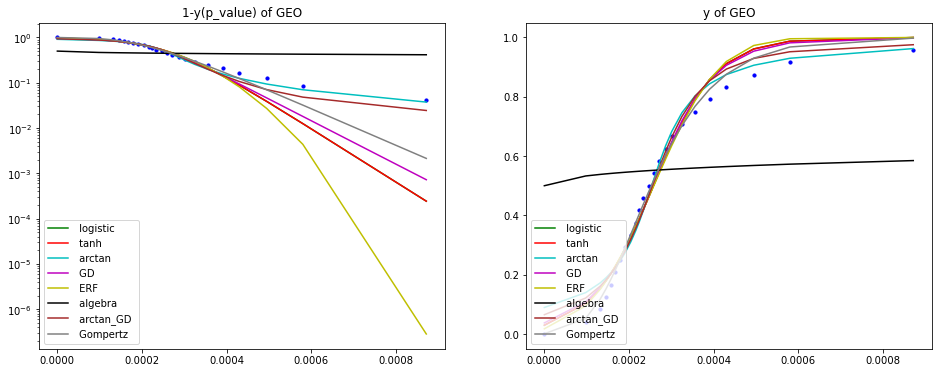

items in each bin:  [22, 22, 22, 22, 22, 22, 22, 22, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21]
For  GEOGD  :
curve_fit parameter on  logistic :  [ 0.08262321 21.10613057]
curve_fit parameter on  tanh :  [ 0.08262319 10.5530722 ]
curve_fit parameter on  arctan :  [ 0.07760785 20.46316263]
curve_fit parameter on  GD :  [0.08197964 8.51335664]
curve_fit parameter on  ERF :  [0.08357277 9.05441592]
curve_fit parameter on  algebra :  [0.05991658 3.96259964]
curve_fit parameter on  arctan_GD :  [ 0.0777488  17.30495573  0.16835552]
curve_fit parameter on  Gompertz :  [ 0.81877319 15.00340375]


D:\anaconda\anaconda\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


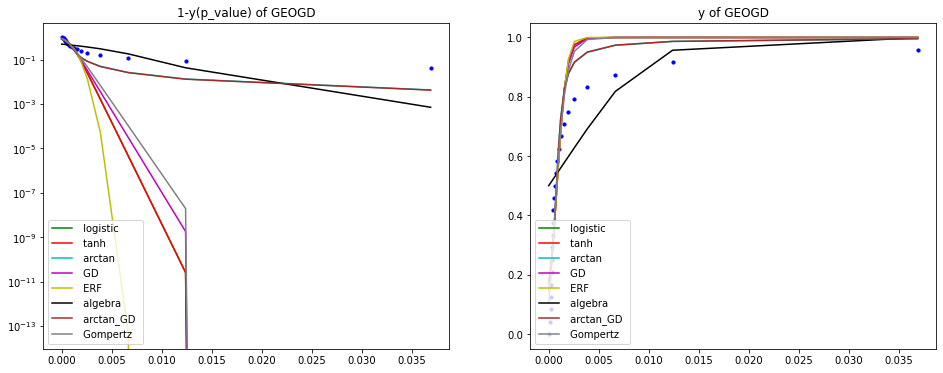

items in each bin:  [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 9]
For  HGG  :
curve_fit parameter on  logistic :  [8.80247453 0.28968778]
curve_fit parameter on  tanh :  [8.80248168 0.14484347]
curve_fit parameter on  arctan :  [8.44606489 0.30359415]
curve_fit parameter on  GD :  [8.73968513 0.11886023]
curve_fit parameter on  ERF :  [8.92022178 0.120445  ]
curve_fit parameter on  algebra :  [7.8882671  0.21998341]
curve_fit parameter on  arctan_GD :  [ 8.55317742  0.66362671 -0.86853363]
curve_fit parameter on  Gompertz :  [1.29644271 0.19072817]


C:\Users\SHIQIJ~1\AppData\Local\Temp/ipykernel_3572/217763432.py:24: RuntimeWarning: divide by zero encountered in power
  m = (1+x/((1+abs(x)**k)**(1/k)))/2
C:\Users\SHIQIJ~1\AppData\Local\Temp/ipykernel_3572/217763432.py:24: RuntimeWarning: invalid value encountered in true_divide
  m = (1+x/((1+abs(x)**k)**(1/k)))/2
D:\anaconda\anaconda\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


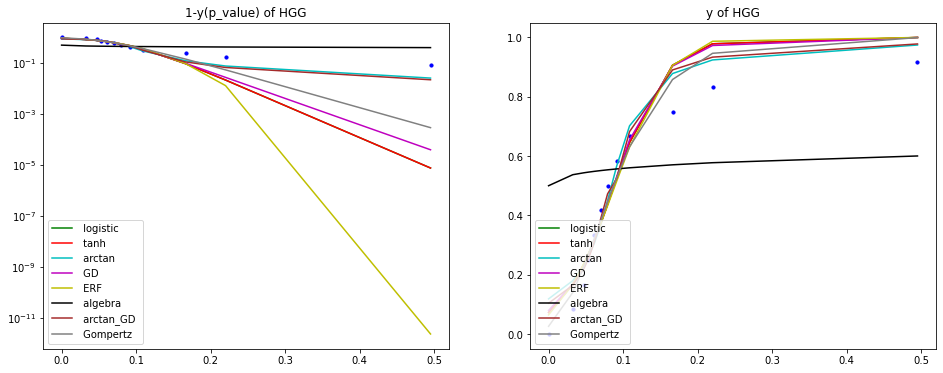

items in each bin:  [22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 21, 21, 21, 21, 21, 21]
For  SF  :
curve_fit parameter on  logistic :  [15.65693826  0.29756423]
curve_fit parameter on  tanh :  [15.65693949  0.1487821 ]
curve_fit parameter on  arctan :  [15.55433048  0.29165361]
curve_fit parameter on  GD :  [15.64229339  0.12065956]
curve_fit parameter on  ERF :  [15.67731387  0.12720783]
curve_fit parameter on  algebra :  [15.27366132  0.17723852]
curve_fit parameter on  arctan_GD :  [15.64018157  0.63453024 -0.87547481]
curve_fit parameter on  Gompertz :  [2.80019792 0.2058066 ]


C:\Users\SHIQIJ~1\AppData\Local\Temp/ipykernel_3572/217763432.py:24: RuntimeWarning: divide by zero encountered in power
  m = (1+x/((1+abs(x)**k)**(1/k)))/2
C:\Users\SHIQIJ~1\AppData\Local\Temp/ipykernel_3572/217763432.py:24: RuntimeWarning: invalid value encountered in true_divide
  m = (1+x/((1+abs(x)**k)**(1/k)))/2
D:\anaconda\anaconda\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
C:\Users\SHIQIJ~1\AppData\Local\Temp/ipykernel_3572/217763432.py:32: RuntimeWarning: overflow encountered in power
  m = np.e**(-np.e**(b-c*x))


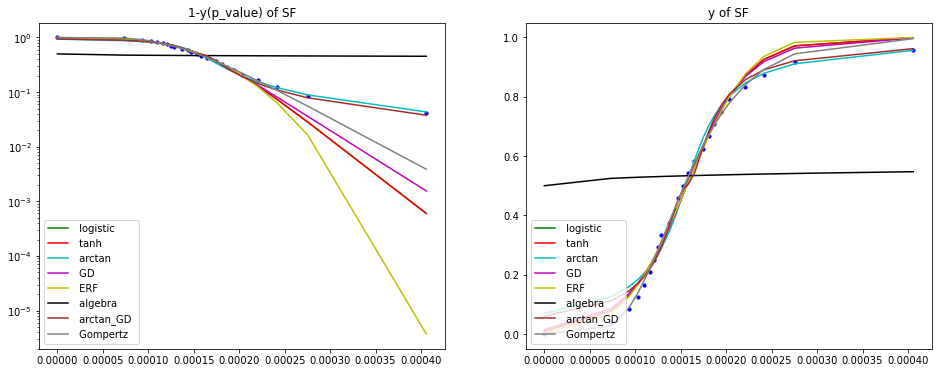

items in each bin:  [22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 21, 21, 21, 21, 21]
For  SFDD  :
curve_fit parameter on  logistic :  [1.55218681 1.53240734]
curve_fit parameter on  tanh :  [1.55217249 0.76622454]
curve_fit parameter on  arctan :  [1.50533174 1.47390007]
curve_fit parameter on  GD :  [1.54640995 0.61796891]
curve_fit parameter on  ERF :  [1.55953186 0.66018245]
curve_fit parameter on  algebra :  [1.32884581 0.33274621]
curve_fit parameter on  arctan_GD :  [ 1.51779371  3.71632277 -1.06968678]
curve_fit parameter on  Gompertz :  [1.22466994 1.05374767]


C:\Users\SHIQIJ~1\AppData\Local\Temp/ipykernel_3572/217763432.py:24: RuntimeWarning: divide by zero encountered in power
  m = (1+x/((1+abs(x)**k)**(1/k)))/2
C:\Users\SHIQIJ~1\AppData\Local\Temp/ipykernel_3572/217763432.py:24: RuntimeWarning: invalid value encountered in true_divide
  m = (1+x/((1+abs(x)**k)**(1/k)))/2
D:\anaconda\anaconda\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


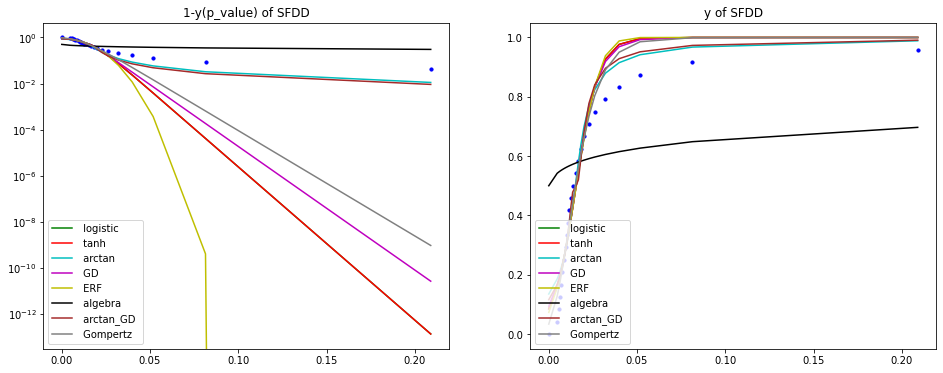

items in each bin:  [22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 21, 21, 21, 21, 21, 21, 21]
For  Sticky  :
curve_fit parameter on  logistic :  [22.50307317  0.23228464]
curve_fit parameter on  tanh :  [22.50307156  0.11614242]
curve_fit parameter on  arctan :  [22.3757955   0.23007731]
curve_fit parameter on  GD :  [22.48291214  0.09436641]
curve_fit parameter on  ERF :  [22.53050275  0.09910158]
curve_fit parameter on  algebra :  [21.94749696  0.1636066 ]
curve_fit parameter on  arctan_GD :  [22.42937068  0.48960691 -0.8400223 ]
curve_fit parameter on  Gompertz :  [ 2.23981342e+00 -3.57135555e+03]


C:\Users\SHIQIJ~1\AppData\Local\Temp/ipykernel_3572/217763432.py:24: RuntimeWarning: divide by zero encountered in power
  m = (1+x/((1+abs(x)**k)**(1/k)))/2
C:\Users\SHIQIJ~1\AppData\Local\Temp/ipykernel_3572/217763432.py:24: RuntimeWarning: invalid value encountered in true_divide
  m = (1+x/((1+abs(x)**k)**(1/k)))/2
D:\anaconda\anaconda\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
C:\Users\SHIQIJ~1\AppData\Local\Temp/ipykernel_3572/217763432.py:32: RuntimeWarning: overflow encountered in power
  m = np.e**(-np.e**(b-c*x))
D:\anaconda\anaconda\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


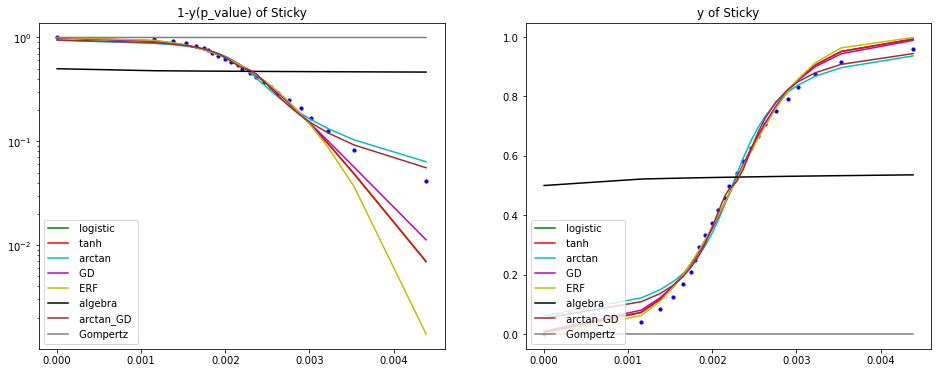

In [47]:
for i in range(len(classes[:-1])):
    data_i = data_distance(data(df_HS,classes[:-1][i]))
    sigmoids_for_class(data_i, classes[:-1][i], factors_HS[i], functions, colors,binning=True)

#### MM

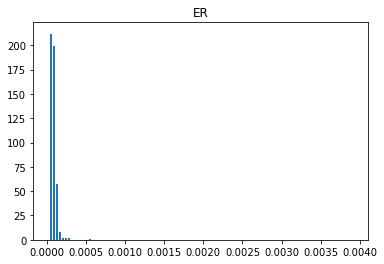

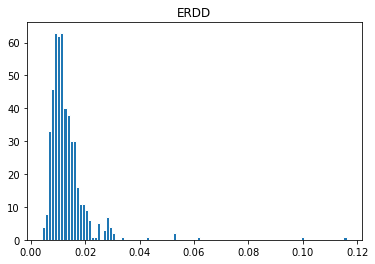

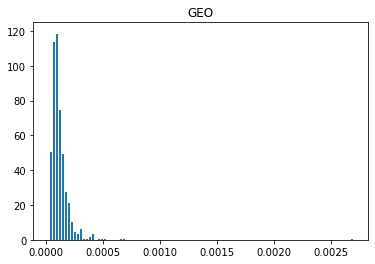

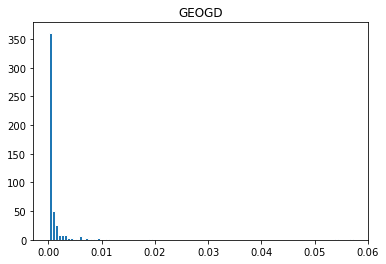

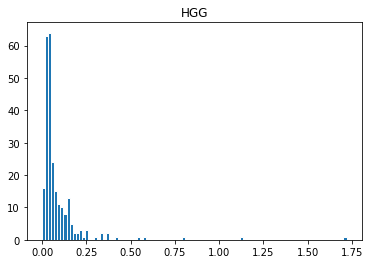

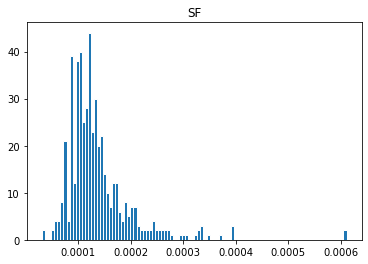

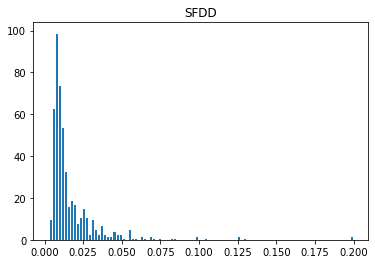

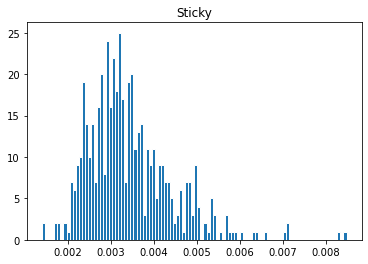

In [48]:
df_MM = data_frame("MM")
for c in classes[:-1]:
    plot_data_distance(data_distance(data(df_MM,c)), c)

In [49]:
factors_MM = [1e-4,1e-2,1e-4,1e-3,1e-2,1e-5,1e-3,1e-4]

items in each bin:  [22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21]
For  ER  :
curve_fit parameter on  logistic :  [0.63044306 6.32932541]
curve_fit parameter on  tanh :  [0.63044308 3.16466198]
curve_fit parameter on  arctan :  [0.62220886 6.35118285]
curve_fit parameter on  GD :  [0.62913933 2.57701552]
curve_fit parameter on  ERF :  [0.63224452 2.68960154]
curve_fit parameter on  algebra :  [0.59167325 0.02665893]
curve_fit parameter on  arctan_GD :  [0.62688665 3.05957815 0.77583159]
curve_fit parameter on  Gompertz :  [2.36195791 4.40616978]


D:\anaconda\anaconda\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


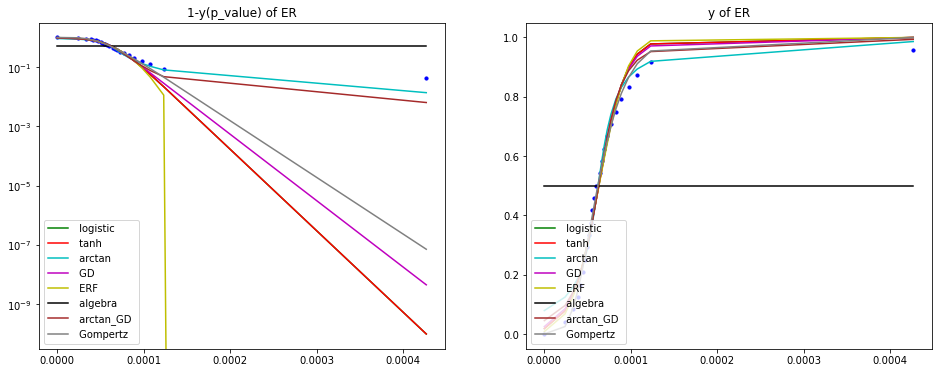

items in each bin:  [22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 21, 21, 21, 21, 21, 21]
For  ERDD  :
curve_fit parameter on  logistic :  [1.18653069 3.83952813]
curve_fit parameter on  tanh :  [1.18653074 1.91976375]
curve_fit parameter on  arctan :  [1.17327677 3.80887706]
curve_fit parameter on  GD :  [1.18457631 1.55880938]
curve_fit parameter on  ERF :  [1.18900495 1.64068585]
curve_fit parameter on  algebra :  [1.14147762 0.28512772]
curve_fit parameter on  arctan_GD :  [ 1.18160676  8.07676041 -0.84411034]
curve_fit parameter on  Gompertz :  [2.74845214 2.66990175]


C:\Users\SHIQIJ~1\AppData\Local\Temp/ipykernel_3572/217763432.py:24: RuntimeWarning: divide by zero encountered in power
  m = (1+x/((1+abs(x)**k)**(1/k)))/2
C:\Users\SHIQIJ~1\AppData\Local\Temp/ipykernel_3572/217763432.py:24: RuntimeWarning: invalid value encountered in true_divide
  m = (1+x/((1+abs(x)**k)**(1/k)))/2
D:\anaconda\anaconda\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


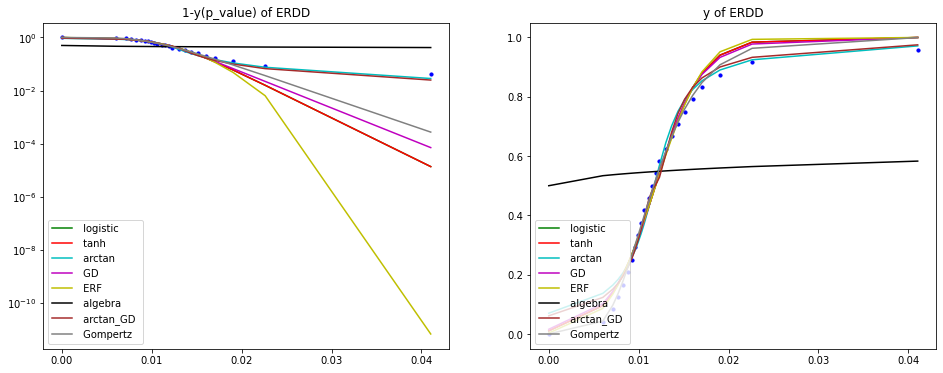

items in each bin:  [22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 21, 21, 21, 21, 21, 21]
For  GEO  :
curve_fit parameter on  logistic :  [0.98234841 3.07883918]
curve_fit parameter on  tanh :  [0.9823485  1.53941923]
curve_fit parameter on  arctan :  [0.96203423 3.07486587]
curve_fit parameter on  GD :  [0.97931815 1.25261527]
curve_fit parameter on  ERF :  [0.98636734 1.31057088]
curve_fit parameter on  algebra :  [0.9039141 0.3550139]
curve_fit parameter on  arctan_GD :  [ 0.97676462  7.07574775 -0.96558453]
curve_fit parameter on  Gompertz :  [1.68023519 2.13672474]


C:\Users\SHIQIJ~1\AppData\Local\Temp/ipykernel_3572/217763432.py:24: RuntimeWarning: divide by zero encountered in power
  m = (1+x/((1+abs(x)**k)**(1/k)))/2
C:\Users\SHIQIJ~1\AppData\Local\Temp/ipykernel_3572/217763432.py:24: RuntimeWarning: invalid value encountered in true_divide
  m = (1+x/((1+abs(x)**k)**(1/k)))/2
D:\anaconda\anaconda\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


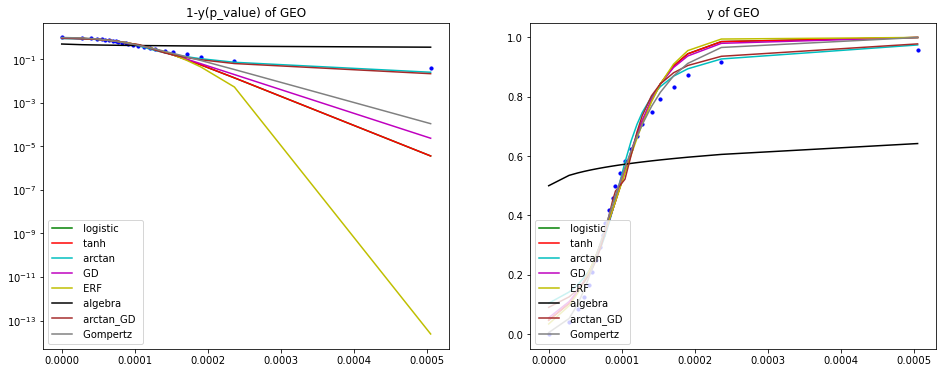

items in each bin:  [22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 21, 21, 21, 21, 21, 21, 21, 21, 21]
For  GEOGD  :
curve_fit parameter on  logistic :  [0.37194563 5.19543549]
curve_fit parameter on  tanh :  [0.37194692 2.59769664]
curve_fit parameter on  arctan :  [0.35642324 4.93287204]
curve_fit parameter on  GD :  [0.37019522 2.08868091]
curve_fit parameter on  ERF :  [0.37418519 2.24620154]
curve_fit parameter on  algebra :  [0.30115222 0.69149072]
curve_fit parameter on  arctan_GD :  [0.35777858 3.7897269  0.2667538 ]
curve_fit parameter on  Gompertz :  [0.92679155 3.60242052]


D:\anaconda\anaconda\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


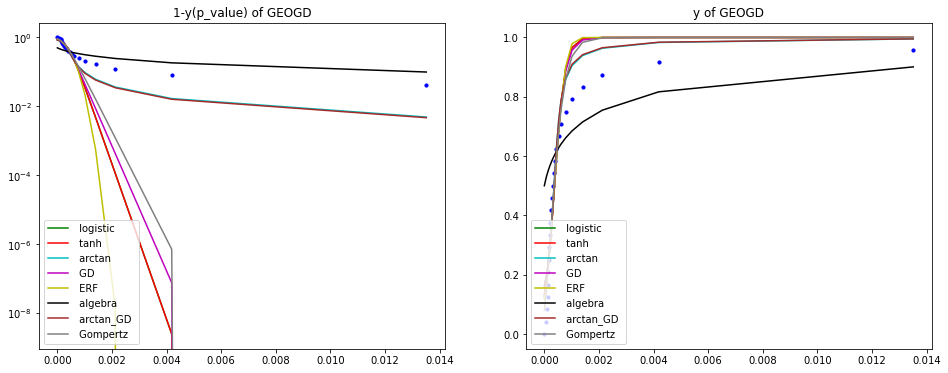

items in each bin:  [16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 15, 15, 15, 15, 15]
For  HGG  :
curve_fit parameter on  logistic :  [5.68610854 0.36780685]
curve_fit parameter on  tanh :  [5.68608557 0.18390538]
curve_fit parameter on  arctan :  [5.26457719 0.39667698]
curve_fit parameter on  GD :  [5.62879622 0.1502502 ]
curve_fit parameter on  ERF :  [5.75968199 0.15589364]
curve_fit parameter on  algebra :  [4.53783314 0.25204449]
curve_fit parameter on  arctan_GD :  [ 5.77069606  1.39388972 -1.9751211 ]
curve_fit parameter on  Gompertz :  [1.06012735 0.25931701]


C:\Users\SHIQIJ~1\AppData\Local\Temp/ipykernel_3572/217763432.py:24: RuntimeWarning: divide by zero encountered in power
  m = (1+x/((1+abs(x)**k)**(1/k)))/2
C:\Users\SHIQIJ~1\AppData\Local\Temp/ipykernel_3572/217763432.py:24: RuntimeWarning: invalid value encountered in true_divide
  m = (1+x/((1+abs(x)**k)**(1/k)))/2
D:\anaconda\anaconda\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


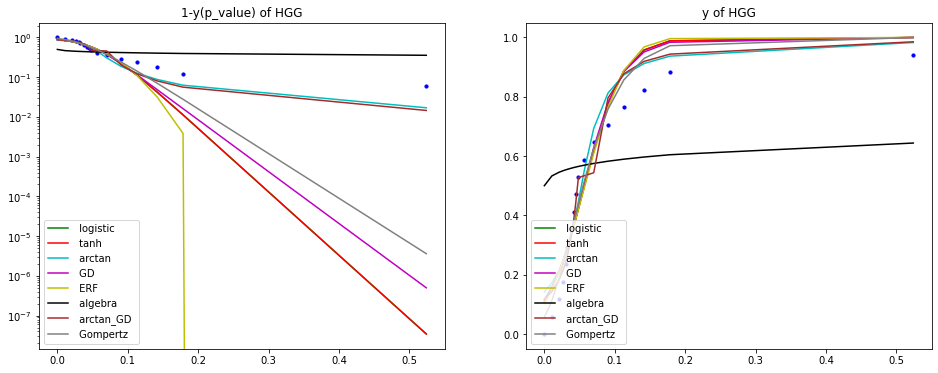

items in each bin:  [22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 21, 21, 21, 21, 21, 21]
For  SF  :
curve_fit parameter on  logistic :  [12.45751836  0.38669936]
curve_fit parameter on  tanh :  [12.45751756  0.19334977]
curve_fit parameter on  arctan :  [12.34054347  0.38748988]
curve_fit parameter on  GD :  [12.43950924  0.15716352]
curve_fit parameter on  ERF :  [12.48232965  0.1647906 ]
curve_fit parameter on  algebra :  [12.06433316  0.18291513]
curve_fit parameter on  arctan_GD :  [12.37598802  0.77098047 -0.73944914]
curve_fit parameter on  Gompertz :  [2.9105674  0.26673365]


C:\Users\SHIQIJ~1\AppData\Local\Temp/ipykernel_3572/217763432.py:24: RuntimeWarning: divide by zero encountered in power
  m = (1+x/((1+abs(x)**k)**(1/k)))/2
C:\Users\SHIQIJ~1\AppData\Local\Temp/ipykernel_3572/217763432.py:24: RuntimeWarning: invalid value encountered in true_divide
  m = (1+x/((1+abs(x)**k)**(1/k)))/2
D:\anaconda\anaconda\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
C:\Users\SHIQIJ~1\AppData\Local\Temp/ipykernel_3572/217763432.py:32: RuntimeWarning: overflow encountered in power
  m = np.e**(-np.e**(b-c*x))


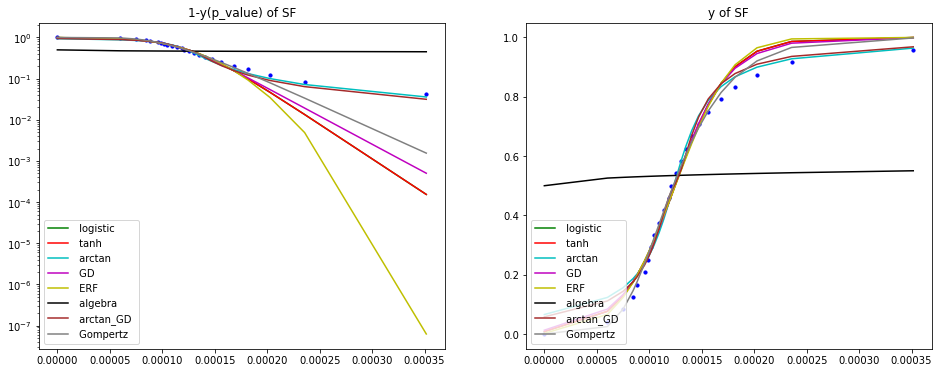

items in each bin:  [22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 21, 21, 21, 21, 21, 21]
For  SFDD  :
curve_fit parameter on  logistic :  [12.17813034  0.20949077]
curve_fit parameter on  tanh :  [12.17812174  0.10474564]
curve_fit parameter on  arctan :  [11.58645241  0.21721514]
curve_fit parameter on  GD :  [12.09608783  0.08523519]
curve_fit parameter on  ERF :  [12.2903024   0.08901016]
curve_fit parameter on  algebra :  [10.66932014  0.21162278]
curve_fit parameter on  arctan_GD :  [12.04184045  0.51808735 -1.0969837 ]
curve_fit parameter on  Gompertz :  [1.38621797 0.14767223]


C:\Users\SHIQIJ~1\AppData\Local\Temp/ipykernel_3572/217763432.py:24: RuntimeWarning: divide by zero encountered in power
  m = (1+x/((1+abs(x)**k)**(1/k)))/2
C:\Users\SHIQIJ~1\AppData\Local\Temp/ipykernel_3572/217763432.py:24: RuntimeWarning: invalid value encountered in true_divide
  m = (1+x/((1+abs(x)**k)**(1/k)))/2
D:\anaconda\anaconda\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
C:\Users\SHIQIJ~1\AppData\Local\Temp/ipykernel_3572/217763432.py:32: RuntimeWarning: overflow encountered in power
  m = np.e**(-np.e**(b-c*x))


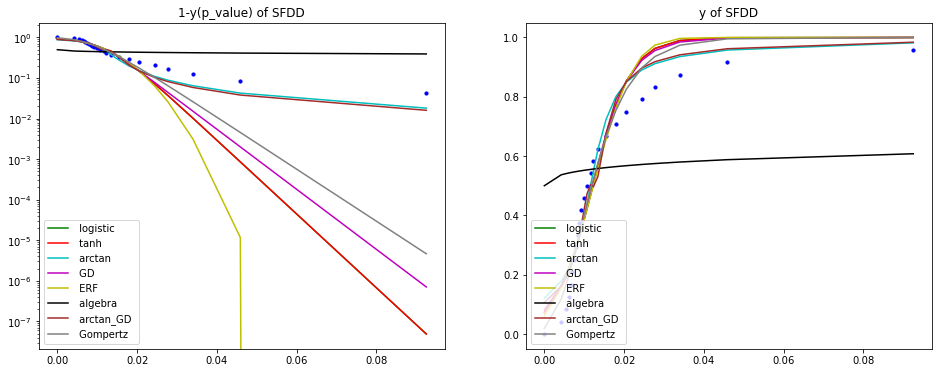

items in each bin:  [22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 21, 21, 21, 21, 21, 21]
For  Sticky  :
curve_fit parameter on  logistic :  [33.11671382  0.17934362]
curve_fit parameter on  tanh :  [33.11671123  0.08967186]
curve_fit parameter on  arctan :  [32.88556863  0.1811769 ]
curve_fit parameter on  GD :  [33.08127859  0.07302783]
curve_fit parameter on  ERF :  [33.16517498  0.07625645]
curve_fit parameter on  algebra :  [32.13957548  0.15293422]
curve_fit parameter on  arctan_GD :  [32.98325992  0.36044092 -0.74294622]
curve_fit parameter on  Gompertz :  [ 2.23982189e+00 -6.30291478e+06]


C:\Users\SHIQIJ~1\AppData\Local\Temp/ipykernel_3572/217763432.py:24: RuntimeWarning: divide by zero encountered in power
  m = (1+x/((1+abs(x)**k)**(1/k)))/2
C:\Users\SHIQIJ~1\AppData\Local\Temp/ipykernel_3572/217763432.py:24: RuntimeWarning: invalid value encountered in true_divide
  m = (1+x/((1+abs(x)**k)**(1/k)))/2
D:\anaconda\anaconda\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
C:\Users\SHIQIJ~1\AppData\Local\Temp/ipykernel_3572/217763432.py:32: RuntimeWarning: overflow encountered in power
  m = np.e**(-np.e**(b-c*x))
D:\anaconda\anaconda\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


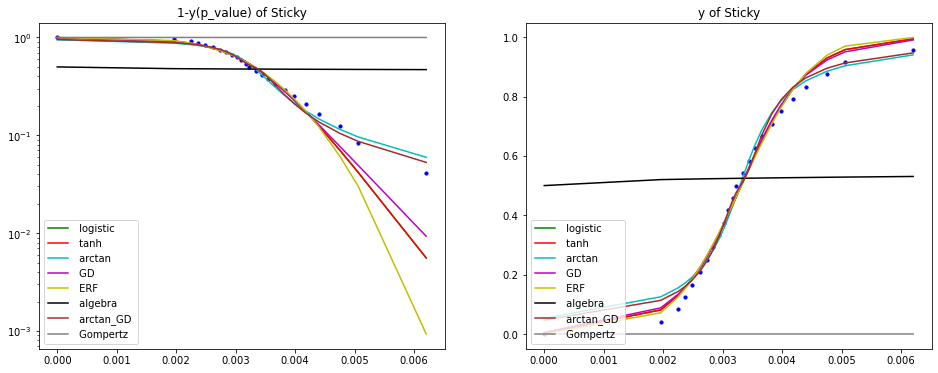

In [50]:
for i in range(len(classes[:-1])):
    data_i = data_distance(data(df_MM,classes[:-1][i]))
    sigmoids_for_class(data_i, classes[:-1][i], factors_MM[i], functions, colors,binning=True)

#### RN

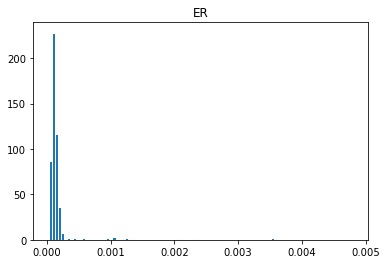

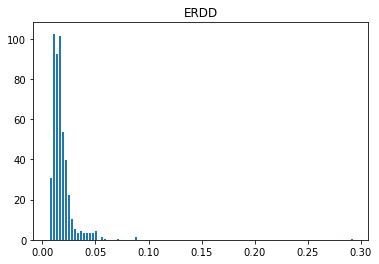

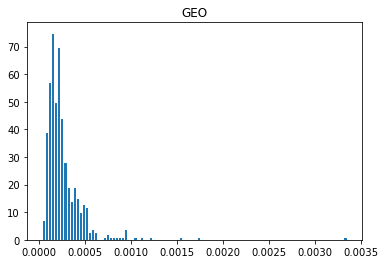

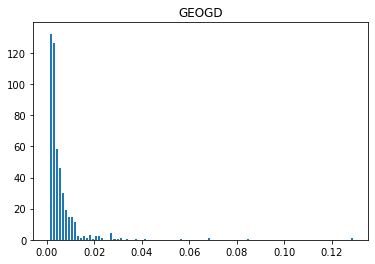

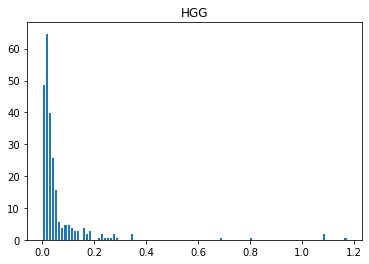

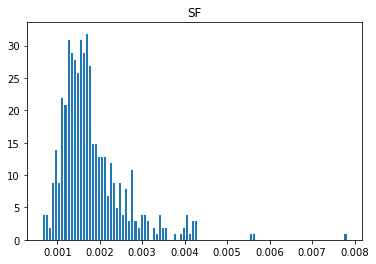

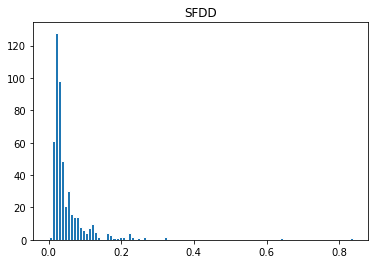

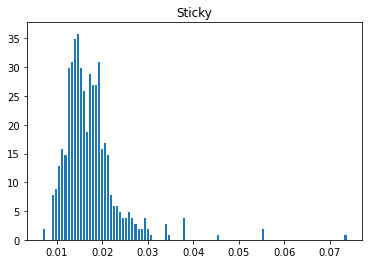

In [51]:
df_RN = data_frame("RN")
for c in classes[:-1]:
    plot_data_distance(data_distance(data(df_RN,c)), c)

In [52]:
factors_RN = [1e-4,1e-2,1e-4,1e-2,1e-1,1e-4,1e-2,1e-3]

items in each bin:  [22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 21, 21, 21, 21, 21, 21]
For  ER  :
curve_fit parameter on  logistic :  [1.12329647 3.63339681]
curve_fit parameter on  tanh :  [1.12329577 1.81670307]
curve_fit parameter on  arctan :  [1.10736155 3.5722698 ]
curve_fit parameter on  GD :  [1.12097767 1.47338773]
curve_fit parameter on  ERF :  [1.12623415 1.55437903]
curve_fit parameter on  algebra :  [1.07510956 0.31286367]
curve_fit parameter on  arctan_GD :  [ 1.11903551  8.46941839 -1.00058136]
curve_fit parameter on  Gompertz :  [2.4373575  2.54436236]


C:\Users\SHIQIJ~1\AppData\Local\Temp/ipykernel_3572/217763432.py:24: RuntimeWarning: divide by zero encountered in power
  m = (1+x/((1+abs(x)**k)**(1/k)))/2
C:\Users\SHIQIJ~1\AppData\Local\Temp/ipykernel_3572/217763432.py:24: RuntimeWarning: invalid value encountered in true_divide
  m = (1+x/((1+abs(x)**k)**(1/k)))/2
D:\anaconda\anaconda\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


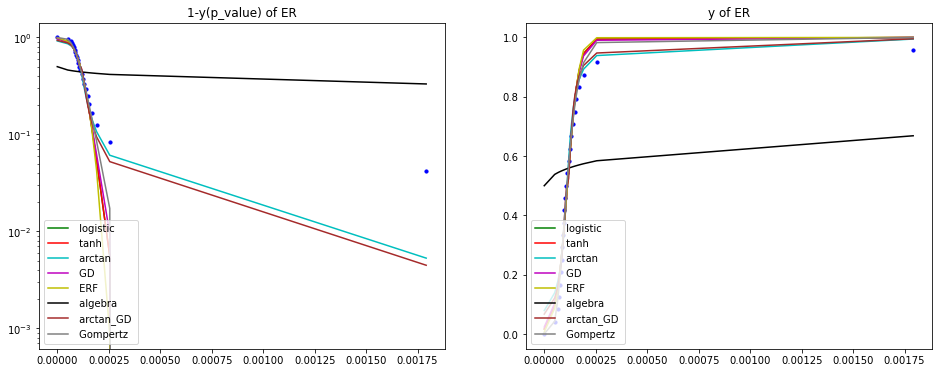

items in each bin:  [22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 21, 21, 21, 21, 21, 21]
For  ERDD  :
curve_fit parameter on  logistic :  [1.54342055 2.64790908]
curve_fit parameter on  tanh :  [1.54342054 1.32395429]
curve_fit parameter on  arctan :  [1.5233107  2.66652041]
curve_fit parameter on  GD :  [1.54046025 1.07666651]
curve_fit parameter on  ERF :  [1.54726185 1.12909236]
curve_fit parameter on  algebra :  [1.48783022 0.27991887]
curve_fit parameter on  arctan_GD :  [1.53351563 1.36317211 0.69394259]
curve_fit parameter on  Gompertz :  [2.39906856 1.82325074]


C:\Users\SHIQIJ~1\AppData\Local\Temp/ipykernel_3572/217763432.py:24: RuntimeWarning: divide by zero encountered in power
  m = (1+x/((1+abs(x)**k)**(1/k)))/2
C:\Users\SHIQIJ~1\AppData\Local\Temp/ipykernel_3572/217763432.py:24: RuntimeWarning: invalid value encountered in true_divide
  m = (1+x/((1+abs(x)**k)**(1/k)))/2
D:\anaconda\anaconda\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


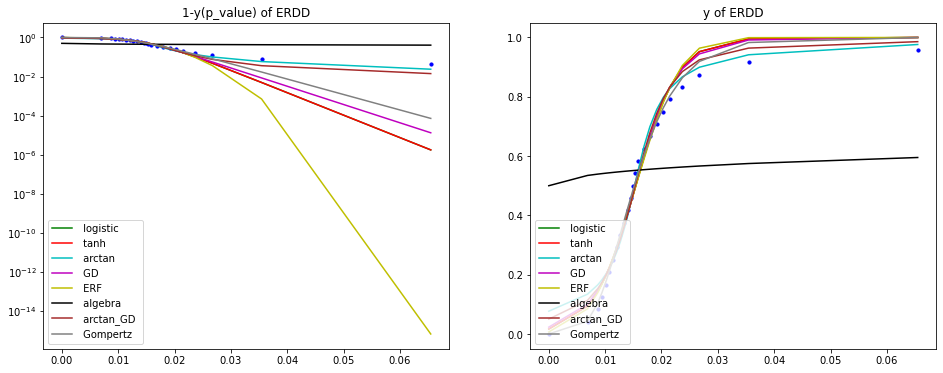

items in each bin:  [22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 21, 21, 21, 21, 21, 21]
For  GEO  :
curve_fit parameter on  logistic :  [2.23524784 1.32392941]
curve_fit parameter on  tanh :  [2.23524215 0.66197128]
curve_fit parameter on  arctan :  [2.18470785 1.34861737]
curve_fit parameter on  GD :  [2.2272018  0.53976905]
curve_fit parameter on  ERF :  [2.24693824 0.56139153]
curve_fit parameter on  algebra :  [2.09581158 0.27898559]
curve_fit parameter on  arctan_GD :  [2.20288956 0.73935185 0.6135896 ]
curve_fit parameter on  Gompertz :  [1.62804312 0.91376789]


C:\Users\SHIQIJ~1\AppData\Local\Temp/ipykernel_3572/217763432.py:24: RuntimeWarning: divide by zero encountered in power
  m = (1+x/((1+abs(x)**k)**(1/k)))/2
C:\Users\SHIQIJ~1\AppData\Local\Temp/ipykernel_3572/217763432.py:24: RuntimeWarning: invalid value encountered in true_divide
  m = (1+x/((1+abs(x)**k)**(1/k)))/2
D:\anaconda\anaconda\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


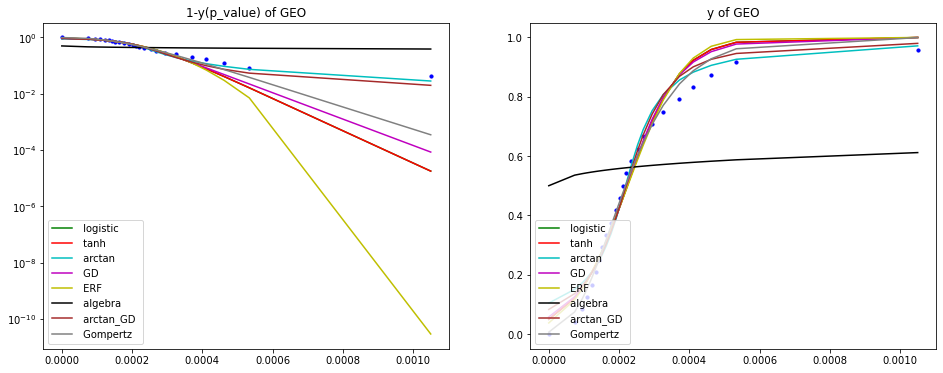

items in each bin:  [22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 21, 21, 21, 21, 21, 21]
For  GEOGD  :
curve_fit parameter on  logistic :  [0.36897219 5.70649229]
curve_fit parameter on  tanh :  [0.36897081 2.85327259]
curve_fit parameter on  arctan :  [0.35275062 5.57010804]
curve_fit parameter on  GD :  [0.36686608 2.30618424]
curve_fit parameter on  ERF :  [0.37171557 2.45033129]
curve_fit parameter on  algebra :  [0.31274868 0.7836751 ]
curve_fit parameter on  arctan_GD :  [0.35692047 3.53168213 0.46816825]
curve_fit parameter on  Gompertz :  [1.06700357 4.04469475]


D:\anaconda\anaconda\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


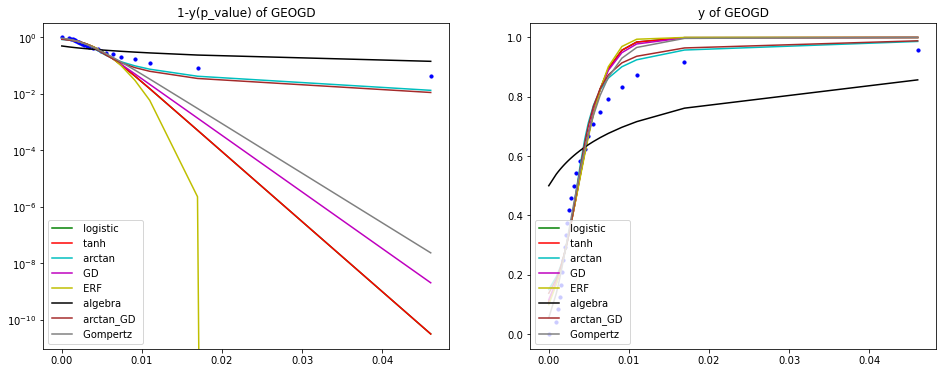

items in each bin:  [16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 15, 15, 15, 15, 15]
For  HGG  :
curve_fit parameter on  logistic :  [0.31125156 6.42278407]
curve_fit parameter on  tanh :  [0.31125196 3.21138284]
curve_fit parameter on  arctan :  [0.30157333 6.03061899]
curve_fit parameter on  GD :  [0.31016955 2.58215303]
curve_fit parameter on  ERF :  [0.31252578 2.78149959]
curve_fit parameter on  algebra :  [0.25967481 0.90454543]
curve_fit parameter on  arctan_GD :  [0.30348434 4.09325933 0.40081668]
curve_fit parameter on  Gompertz :  [0.95225012 4.3879969 ]


D:\anaconda\anaconda\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


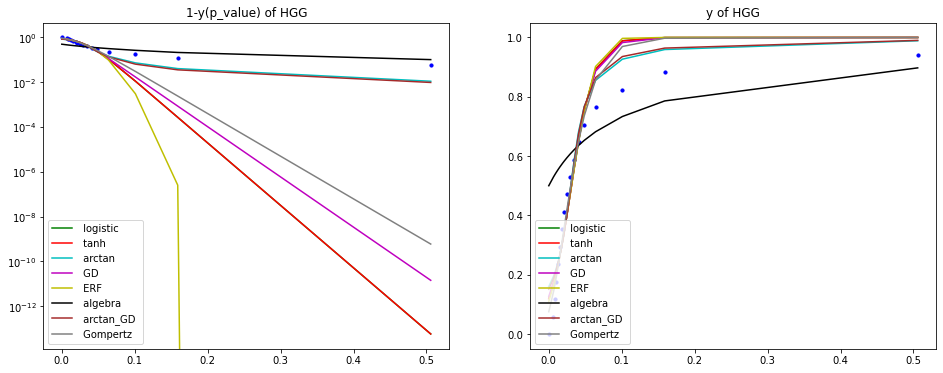

items in each bin:  [22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 21, 21, 21, 21, 21, 21]
For  SF  :
curve_fit parameter on  logistic :  [16.79185488  0.27640844]
curve_fit parameter on  tanh :  [16.79186681  0.13820354]
curve_fit parameter on  arctan :  [16.58755174  0.28110225]
curve_fit parameter on  GD :  [16.76027443  0.11250491]
curve_fit parameter on  ERF :  [16.8348424   0.11759671]
curve_fit parameter on  algebra :  [16.22846345  0.17588546]
curve_fit parameter on  arctan_GD :  [16.6394843   0.51983606 -0.65400195]
curve_fit parameter on  Gompertz :  [   2.23932466 -216.20515385]


C:\Users\SHIQIJ~1\AppData\Local\Temp/ipykernel_3572/217763432.py:24: RuntimeWarning: divide by zero encountered in power
  m = (1+x/((1+abs(x)**k)**(1/k)))/2
C:\Users\SHIQIJ~1\AppData\Local\Temp/ipykernel_3572/217763432.py:24: RuntimeWarning: invalid value encountered in true_divide
  m = (1+x/((1+abs(x)**k)**(1/k)))/2
D:\anaconda\anaconda\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
C:\Users\SHIQIJ~1\AppData\Local\Temp/ipykernel_3572/217763432.py:32: RuntimeWarning: overflow encountered in power
  m = np.e**(-np.e**(b-c*x))
D:\anaconda\anaconda\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


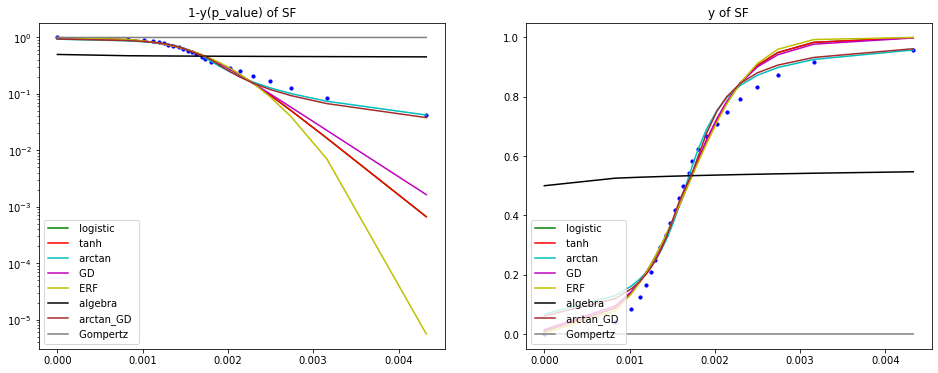

items in each bin:  [22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 21, 21, 21, 21, 21]
For  SFDD  :
curve_fit parameter on  logistic :  [3.4082614  0.75581373]
curve_fit parameter on  tanh :  [3.40828864 0.37789671]
curve_fit parameter on  arctan :  [3.2659468  0.76797201]
curve_fit parameter on  GD :  [3.38859118 0.30687103]
curve_fit parameter on  ERF :  [3.43371869 0.32263756]
curve_fit parameter on  algebra :  [3.04744587 0.26573061]
curve_fit parameter on  arctan_GD :  [3.27744878 0.58899298 0.26128142]
curve_fit parameter on  Gompertz :  [1.38283136 0.52562195]


C:\Users\SHIQIJ~1\AppData\Local\Temp/ipykernel_3572/217763432.py:24: RuntimeWarning: divide by zero encountered in power
  m = (1+x/((1+abs(x)**k)**(1/k)))/2
C:\Users\SHIQIJ~1\AppData\Local\Temp/ipykernel_3572/217763432.py:24: RuntimeWarning: invalid value encountered in true_divide
  m = (1+x/((1+abs(x)**k)**(1/k)))/2
D:\anaconda\anaconda\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


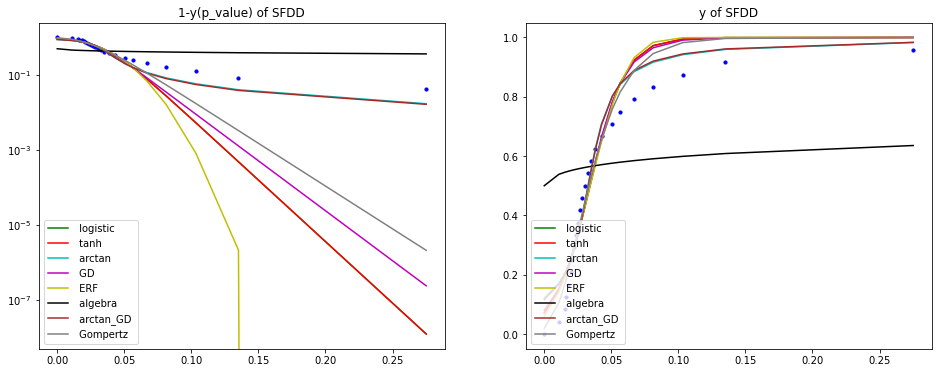

items in each bin:  [22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 21, 21, 21, 21, 21, 21]
For  Sticky  :
curve_fit parameter on  logistic :  [16.46235147  0.35083191]
curve_fit parameter on  tanh :  [16.46235195  0.17541595]
curve_fit parameter on  arctan :  [16.41017984  0.33783537]
curve_fit parameter on  GD :  [16.45484251  0.14198537]
curve_fit parameter on  ERF :  [16.47295291  0.15034713]
curve_fit parameter on  algebra :  [16.12565126  0.16777392]
curve_fit parameter on  arctan_GD :  [16.41351149  0.78676389 -0.95985973]
curve_fit parameter on  Gompertz :  [   2.23961252 -564.11149835]


C:\Users\SHIQIJ~1\AppData\Local\Temp/ipykernel_3572/217763432.py:24: RuntimeWarning: divide by zero encountered in power
  m = (1+x/((1+abs(x)**k)**(1/k)))/2
C:\Users\SHIQIJ~1\AppData\Local\Temp/ipykernel_3572/217763432.py:24: RuntimeWarning: invalid value encountered in true_divide
  m = (1+x/((1+abs(x)**k)**(1/k)))/2
D:\anaconda\anaconda\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
C:\Users\SHIQIJ~1\AppData\Local\Temp/ipykernel_3572/217763432.py:32: RuntimeWarning: overflow encountered in power
  m = np.e**(-np.e**(b-c*x))
D:\anaconda\anaconda\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


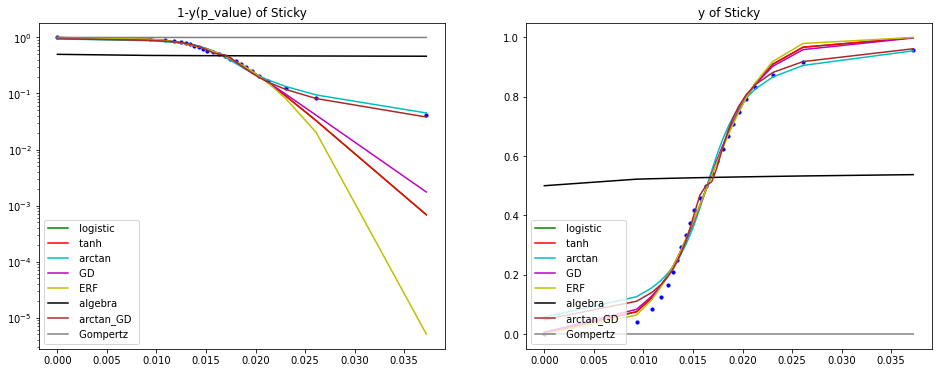

In [53]:
for i in range(len(classes[:-1])):
    data_i = data_distance(data(df_RN,classes[:-1][i]))
    sigmoids_for_class(data_i, classes[:-1][i], factors_RN[i], functions, colors,binning=True)

#### SC

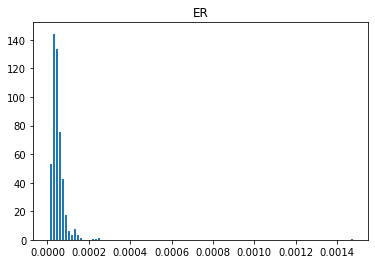

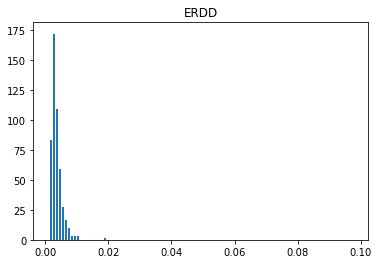

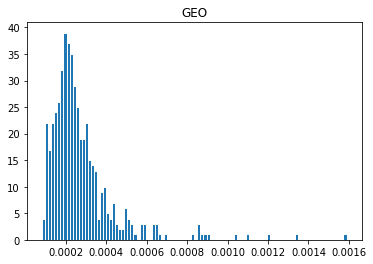

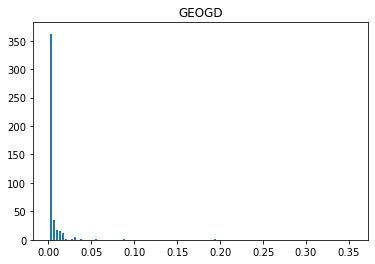

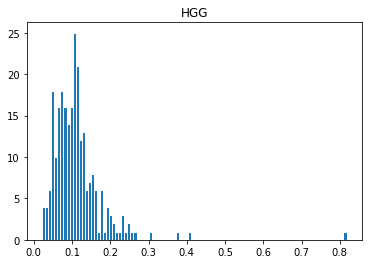

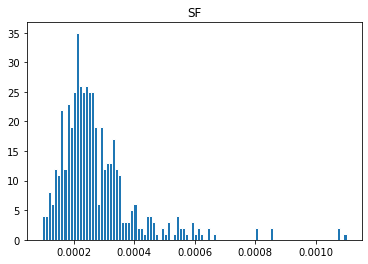

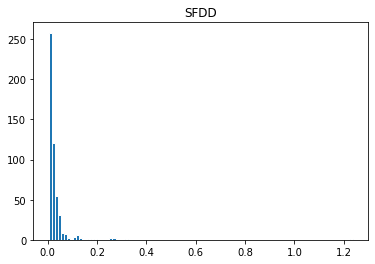

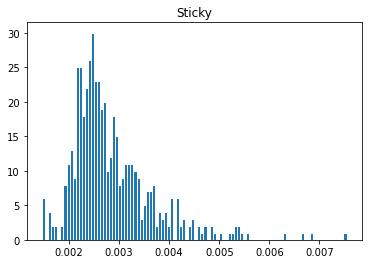

In [54]:
df_SC = data_frame("SC")
for c in classes[:-1]:
    plot_data_distance(data_distance(data(df_SC,c)), c)

In [55]:
factors_SC = [1e-4,1e-2,1e-4,1e-2,1e-2,1e-4,1e-1,1e-4]

items in each bin:  [22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 21, 21, 21, 21, 21, 21]
For  ER  :
curve_fit parameter on  logistic :  [0.41691919 7.43161318]
curve_fit parameter on  tanh :  [0.41691917 3.71580851]
curve_fit parameter on  arctan :  [0.41319442 7.36947949]
curve_fit parameter on  GD :  [0.41632331 3.02368142]
curve_fit parameter on  ERF :  [0.41781106 3.16308842]
curve_fit parameter on  algebra :  [0.40393471 0.57797086]
curve_fit parameter on  arctan_GD :  [0.41583145 3.23616971 0.90551228]
curve_fit parameter on  Gompertz :  [1.68995251 5.0614422 ]


D:\anaconda\anaconda\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


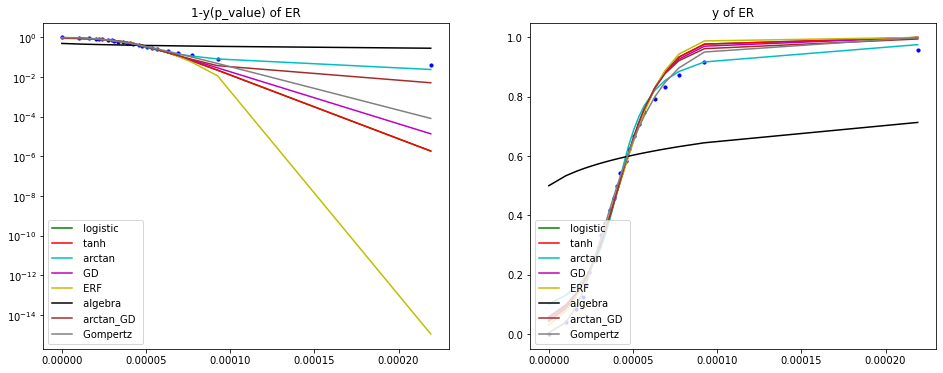

items in each bin:  [22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 21, 21, 21, 21, 21, 21]
For  ERDD  :
curve_fit parameter on  logistic :  [ 0.31096318 11.88347021]
curve_fit parameter on  tanh :  [0.31096324 5.9417274 ]
curve_fit parameter on  arctan :  [ 0.3063435  11.82990314]
curve_fit parameter on  GD :  [0.31027074 4.82894629]
curve_fit parameter on  ERF :  [0.31185329 5.0710298 ]
curve_fit parameter on  algebra :  [0.29497015 0.68449186]
curve_fit parameter on  arctan_GD :  [0.30923953 5.56710812 0.80832581]
curve_fit parameter on  Gompertz :  [2.15062463 8.26461024]


D:\anaconda\anaconda\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


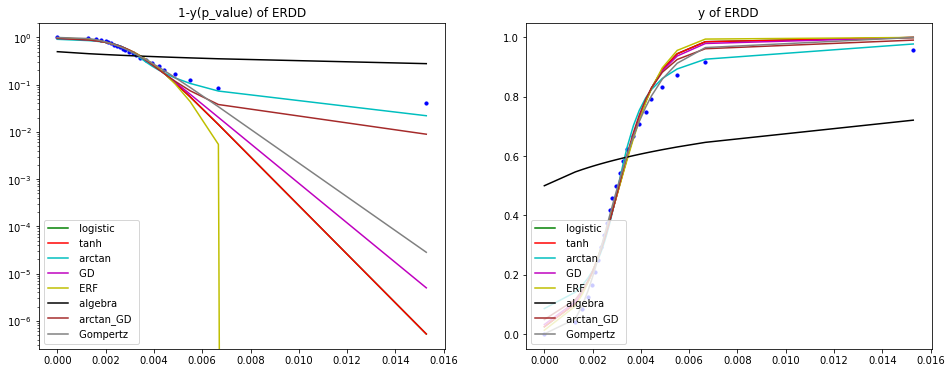

items in each bin:  [22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 21, 21, 21, 21, 21, 21]
For  GEO  :
curve_fit parameter on  logistic :  [2.41362436 1.54539986]
curve_fit parameter on  tanh :  [2.41362351 0.77270129]
curve_fit parameter on  arctan :  [2.38115961 1.53913589]
curve_fit parameter on  GD :  [2.40898062 0.62789409]
curve_fit parameter on  ERF :  [2.41963707 0.65932243]
curve_fit parameter on  algebra :  [2.29448841 0.25610993]
curve_fit parameter on  arctan_GD :  [2.4002305  0.7474222  0.76823464]
curve_fit parameter on  Gompertz :  [2.15295453 1.06438069]


C:\Users\SHIQIJ~1\AppData\Local\Temp/ipykernel_3572/217763432.py:24: RuntimeWarning: divide by zero encountered in power
  m = (1+x/((1+abs(x)**k)**(1/k)))/2
C:\Users\SHIQIJ~1\AppData\Local\Temp/ipykernel_3572/217763432.py:24: RuntimeWarning: invalid value encountered in true_divide
  m = (1+x/((1+abs(x)**k)**(1/k)))/2
D:\anaconda\anaconda\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


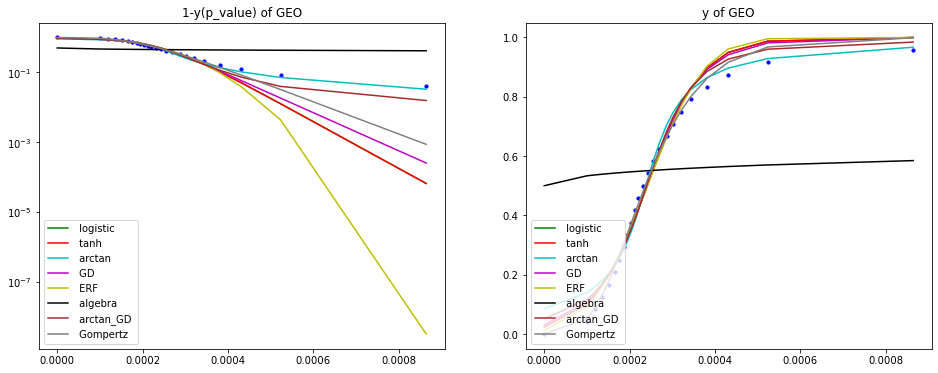

items in each bin:  [22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 21, 21, 21, 21, 21, 21]
For  GEOGD  :
curve_fit parameter on  logistic :  [ 0.15825463 10.02632027]
curve_fit parameter on  tanh :  [0.15825507 5.01313343]
curve_fit parameter on  arctan :  [0.14642646 9.68358635]
curve_fit parameter on  GD :  [0.1570234  4.02722524]
curve_fit parameter on  ERF :  [0.15977762 4.33854731]
curve_fit parameter on  algebra :  [0.11146322 1.3621781 ]
curve_fit parameter on  arctan_GD :  [0.14656677 8.75808246 0.10032003]
curve_fit parameter on  Gompertz :  [0.70944547 7.13919613]


D:\anaconda\anaconda\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


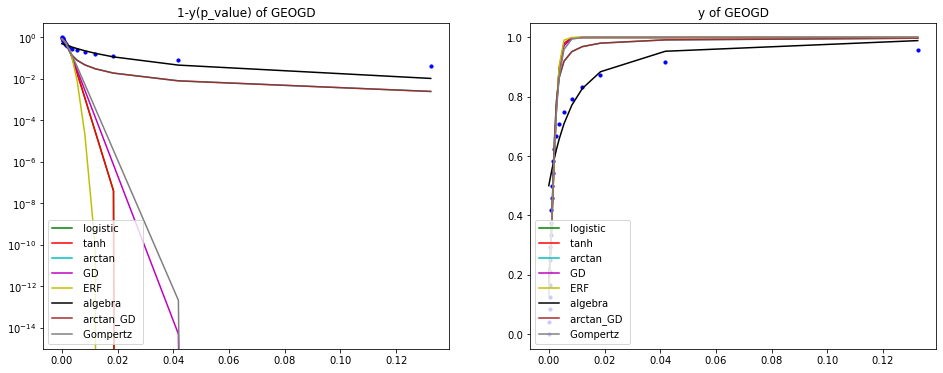

items in each bin:  [16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 15, 15, 15, 15, 15]
For  HGG  :
curve_fit parameter on  logistic :  [10.35940348  0.33636483]
curve_fit parameter on  tanh :  [10.35940358  0.16818242]
curve_fit parameter on  arctan :  [10.33469797  0.33852857]
curve_fit parameter on  GD :  [10.35472441  0.13703328]
curve_fit parameter on  ERF :  [10.36903912  0.14285623]
curve_fit parameter on  algebra :  [10.37037986  0.20121898]
curve_fit parameter on  arctan_GD :  [10.30518289  0.62500225 -0.64948862]
curve_fit parameter on  Gompertz :  [1.91157443 0.22472284]


C:\Users\SHIQIJ~1\AppData\Local\Temp/ipykernel_3572/217763432.py:24: RuntimeWarning: divide by zero encountered in power
  m = (1+x/((1+abs(x)**k)**(1/k)))/2
C:\Users\SHIQIJ~1\AppData\Local\Temp/ipykernel_3572/217763432.py:24: RuntimeWarning: invalid value encountered in true_divide
  m = (1+x/((1+abs(x)**k)**(1/k)))/2
D:\anaconda\anaconda\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


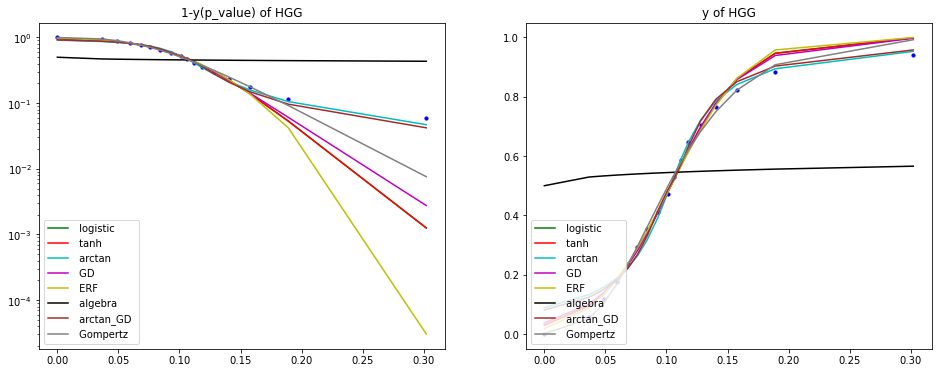

items in each bin:  [22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 21, 21, 21, 21, 21, 21]
For  SF  :
curve_fit parameter on  logistic :  [2.52073581 1.79715854]
curve_fit parameter on  tanh :  [2.5207355  0.89857993]
curve_fit parameter on  arctan :  [2.49432779 1.79361213]
curve_fit parameter on  GD :  [2.51695282 0.72984926]
curve_fit parameter on  ERF :  [2.52531976 0.76785665]
curve_fit parameter on  algebra :  [2.43252872 0.23907943]
curve_fit parameter on  arctan_GD :  [2.51031063 0.86387043 0.77441891]
curve_fit parameter on  Gompertz :  [2.71228793 1.241141  ]


C:\Users\SHIQIJ~1\AppData\Local\Temp/ipykernel_3572/217763432.py:24: RuntimeWarning: divide by zero encountered in power
  m = (1+x/((1+abs(x)**k)**(1/k)))/2
C:\Users\SHIQIJ~1\AppData\Local\Temp/ipykernel_3572/217763432.py:24: RuntimeWarning: invalid value encountered in true_divide
  m = (1+x/((1+abs(x)**k)**(1/k)))/2
D:\anaconda\anaconda\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


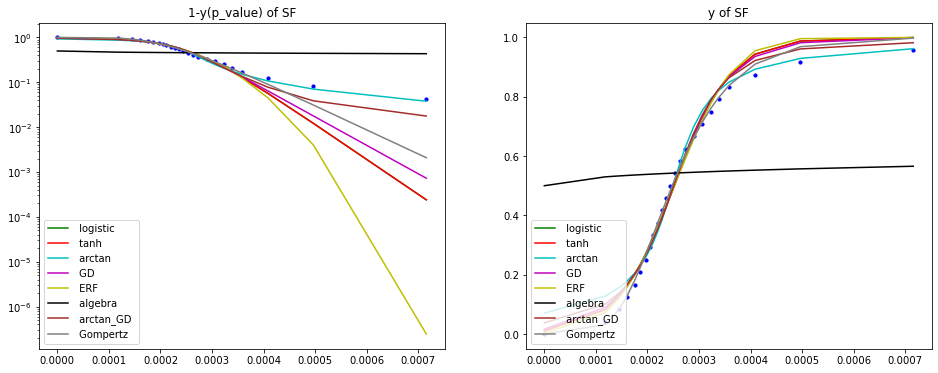

items in each bin:  [22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 21, 21, 21, 21, 21]
For  SFDD  :
curve_fit parameter on  logistic :  [ 0.17958358 13.28404471]
curve_fit parameter on  tanh :  [0.17958364 6.6420154 ]
curve_fit parameter on  arctan :  [ 0.17220263 13.20785311]
curve_fit parameter on  GD :  [0.17855058 5.38630189]
curve_fit parameter on  ERF :  [0.18105552 5.66614374]
curve_fit parameter on  algebra :  [ 0.1533102  27.02406311]
curve_fit parameter on  arctan_GD :  [0.17386203 8.45612065 0.45477836]
curve_fit parameter on  Gompertz :  [1.27110676 9.42971071]


D:\anaconda\anaconda\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


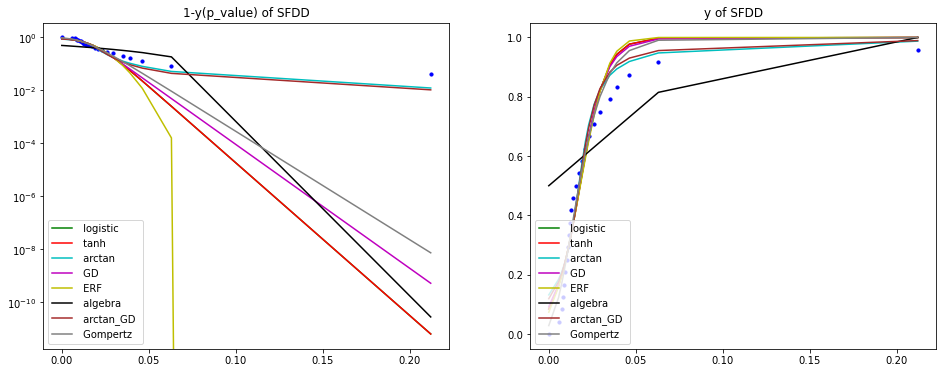

items in each bin:  [22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 21, 21, 21, 21, 21, 21]
For  Sticky  :
curve_fit parameter on  logistic :  [27.12603904  0.24237502]
curve_fit parameter on  tanh :  [27.12604774  0.12118715]
curve_fit parameter on  arctan :  [26.85340167  0.24168572]
curve_fit parameter on  GD :  [27.08589751  0.09841898]
curve_fit parameter on  ERF :  [27.17834812  0.10337734]
curve_fit parameter on  algebra :  [26.19243701  0.15376666]
curve_fit parameter on  arctan_GD :  [27.0305665   0.55866721 -0.9563138 ]
curve_fit parameter on  Gompertz :  [ 2.23982185e+00 -5.02226170e+05]


C:\Users\SHIQIJ~1\AppData\Local\Temp/ipykernel_3572/217763432.py:24: RuntimeWarning: divide by zero encountered in power
  m = (1+x/((1+abs(x)**k)**(1/k)))/2
C:\Users\SHIQIJ~1\AppData\Local\Temp/ipykernel_3572/217763432.py:24: RuntimeWarning: invalid value encountered in true_divide
  m = (1+x/((1+abs(x)**k)**(1/k)))/2
D:\anaconda\anaconda\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
C:\Users\SHIQIJ~1\AppData\Local\Temp/ipykernel_3572/217763432.py:32: RuntimeWarning: overflow encountered in power
  m = np.e**(-np.e**(b-c*x))
D:\anaconda\anaconda\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


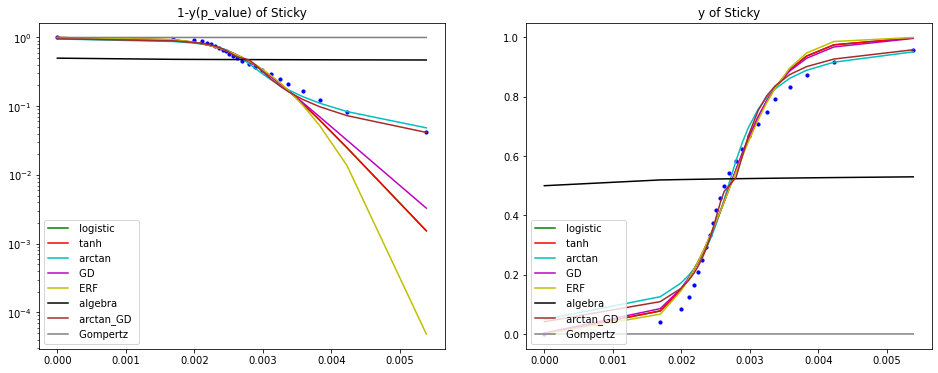

In [56]:
for i in range(len(classes[:-1])):
    data_i = data_distance(data(df_SC,classes[:-1][i]))
    sigmoids_for_class(data_i, classes[:-1][i], factors_SC[i], functions, colors,binning=True)

#### SP

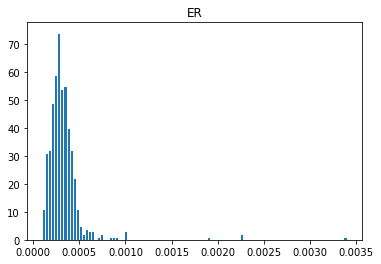

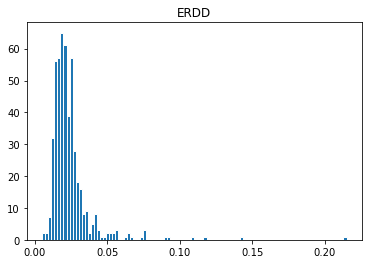

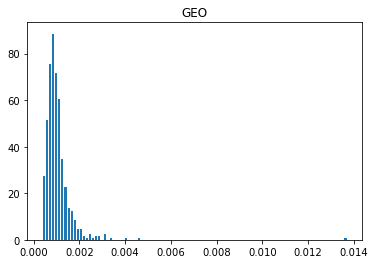

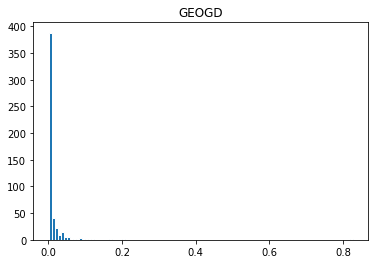

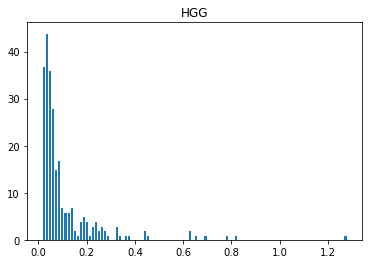

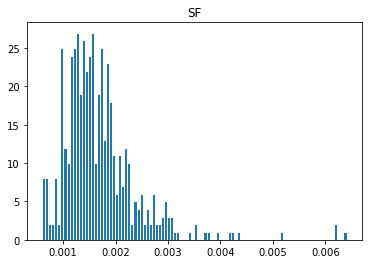

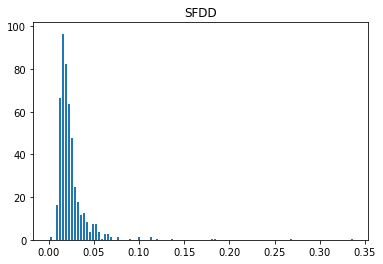

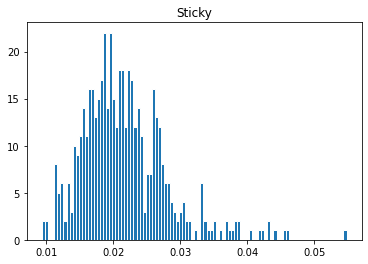

In [57]:
df_SP = data_frame("SP")
for c in classes[:-1]:
    plot_data_distance(data_distance(data(df_SP,c)), c)

In [58]:
factors_SP = [1e-4,1e-2,1e-3,1e-2,1e-1,1e-4,1e-2,1e-3]

items in each bin:  [22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 21, 21, 21, 21, 21, 21]
For  ER  :
curve_fit parameter on  logistic :  [3.00016877 1.49305033]
curve_fit parameter on  tanh :  [3.00016867 0.74652511]
curve_fit parameter on  arctan :  [2.98797732 1.49205644]
curve_fit parameter on  GD :  [2.99828357 0.60827601]
curve_fit parameter on  ERF :  [3.00268459 0.63457887]
curve_fit parameter on  algebra :  [2.92079936 0.23500248]
curve_fit parameter on  arctan_GD :  [2.99828262 0.6083028  0.99993667]
curve_fit parameter on  Gompertz :  [2.63853155 1.0203476 ]


C:\Users\SHIQIJ~1\AppData\Local\Temp/ipykernel_3572/217763432.py:24: RuntimeWarning: divide by zero encountered in power
  m = (1+x/((1+abs(x)**k)**(1/k)))/2
C:\Users\SHIQIJ~1\AppData\Local\Temp/ipykernel_3572/217763432.py:24: RuntimeWarning: invalid value encountered in true_divide
  m = (1+x/((1+abs(x)**k)**(1/k)))/2
D:\anaconda\anaconda\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


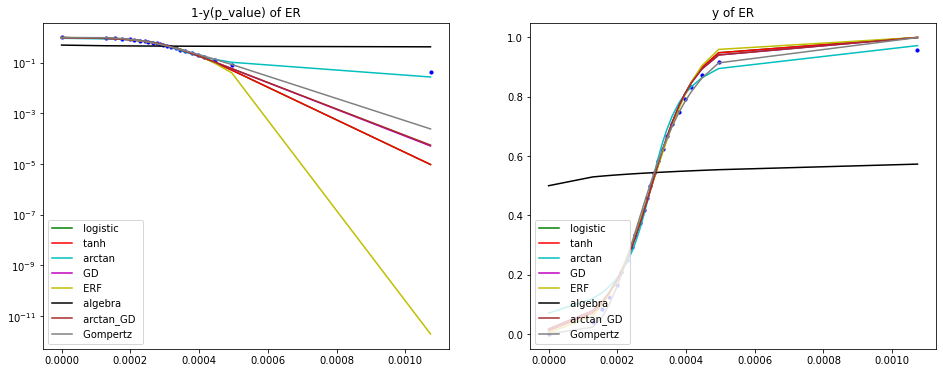

items in each bin:  [22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 21, 21, 21, 21, 21, 21]
For  ERDD  :
curve_fit parameter on  logistic :  [2.12539927 2.1623592 ]
curve_fit parameter on  tanh :  [2.12539898 1.08118101]
curve_fit parameter on  arctan :  [2.11158841 2.09467855]
curve_fit parameter on  GD :  [2.12359203 0.87518981]
curve_fit parameter on  ERF :  [2.12782383 0.92716322]
curve_fit parameter on  algebra :  [2.05421846 0.25038481]
curve_fit parameter on  arctan_GD :  [2.12067533 0.99299995 0.82246938]
curve_fit parameter on  Gompertz :  [2.73502063 1.48414264]


C:\Users\SHIQIJ~1\AppData\Local\Temp/ipykernel_3572/217763432.py:24: RuntimeWarning: divide by zero encountered in power
  m = (1+x/((1+abs(x)**k)**(1/k)))/2
C:\Users\SHIQIJ~1\AppData\Local\Temp/ipykernel_3572/217763432.py:24: RuntimeWarning: invalid value encountered in true_divide
  m = (1+x/((1+abs(x)**k)**(1/k)))/2
D:\anaconda\anaconda\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


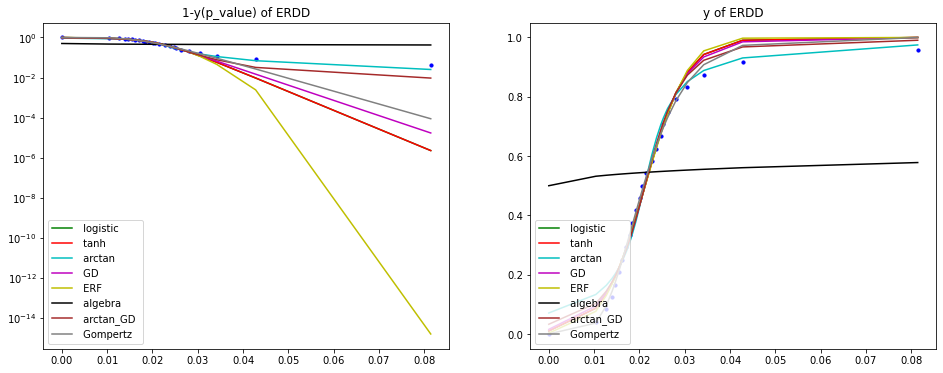

items in each bin:  [22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 21, 21, 21, 21, 21, 21]
For  GEO  :
curve_fit parameter on  logistic :  [0.93778413 4.67779862]
curve_fit parameter on  tanh :  [0.93778415 2.33889907]
curve_fit parameter on  arctan :  [0.93044317 4.64514021]
curve_fit parameter on  GD :  [0.93666014 1.90059956]
curve_fit parameter on  ERF :  [0.93931075 1.99617307]
curve_fit parameter on  algebra :  [0.91513805 0.3115037 ]
curve_fit parameter on  arctan_GD :  [0.93469747 2.22314971 0.78945149]
curve_fit parameter on  Gompertz :  [2.5887019  3.20508223]


C:\Users\SHIQIJ~1\AppData\Local\Temp/ipykernel_3572/217763432.py:24: RuntimeWarning: divide by zero encountered in power
  m = (1+x/((1+abs(x)**k)**(1/k)))/2
C:\Users\SHIQIJ~1\AppData\Local\Temp/ipykernel_3572/217763432.py:24: RuntimeWarning: invalid value encountered in true_divide
  m = (1+x/((1+abs(x)**k)**(1/k)))/2
D:\anaconda\anaconda\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


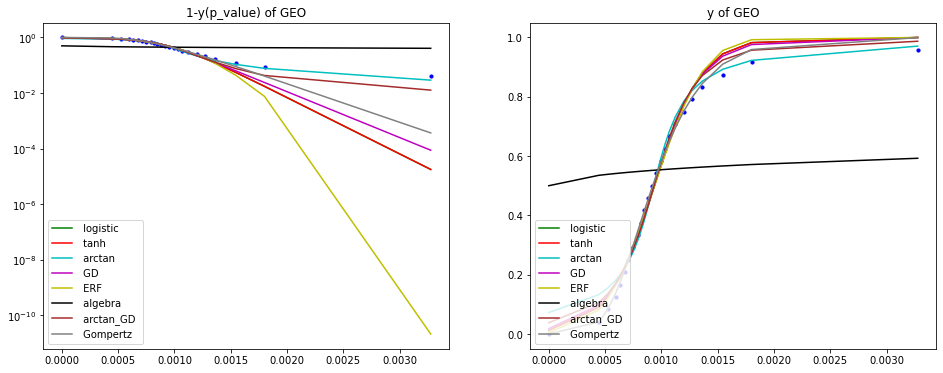

items in each bin:  [22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 21, 21, 21, 21, 21, 21]
For  GEOGD  :
curve_fit parameter on  logistic :  [0.40466471 4.44162628]
curve_fit parameter on  tanh :  [0.40466566 2.22080168]
curve_fit parameter on  arctan :  [0.37836505 4.33649844]
curve_fit parameter on  GD :  [0.40174002 1.78757137]
curve_fit parameter on  ERF :  [0.40808041 1.9200777 ]
curve_fit parameter on  algebra :  [0.29025734 0.65370955]
curve_fit parameter on  arctan_GD :  [0.37926381 3.70552373 0.1560899 ]
curve_fit parameter on  Gompertz :  [0.86630558 3.19380111]


D:\anaconda\anaconda\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


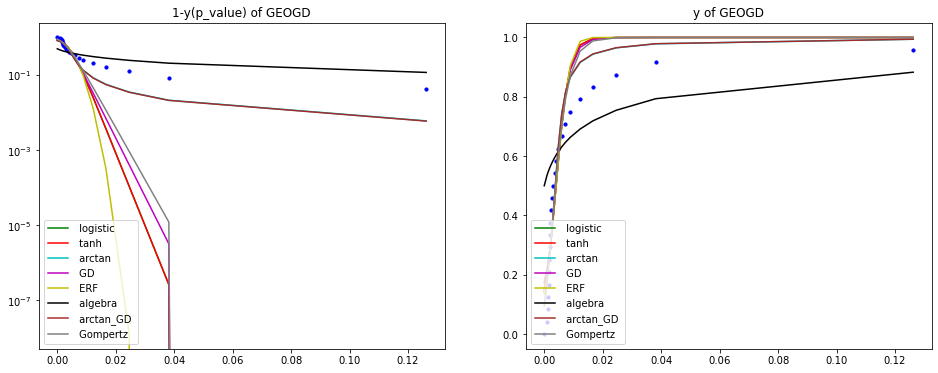

items in each bin:  [16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 15, 15, 15, 15, 15]
For  HGG  :
curve_fit parameter on  logistic :  [0.66574906 3.29871463]
curve_fit parameter on  tanh :  [0.66575178 1.64933899]
curve_fit parameter on  arctan :  [0.6381119  3.22903585]
curve_fit parameter on  GD :  [0.66276922 1.32954263]
curve_fit parameter on  ERF :  [0.66924661 1.42379959]
curve_fit parameter on  algebra :  [0.56908164 0.46736581]
curve_fit parameter on  arctan_GD :  [0.64175719 2.33223775 0.32697759]
curve_fit parameter on  Gompertz :  [1.08914079 2.24237965]


D:\anaconda\anaconda\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


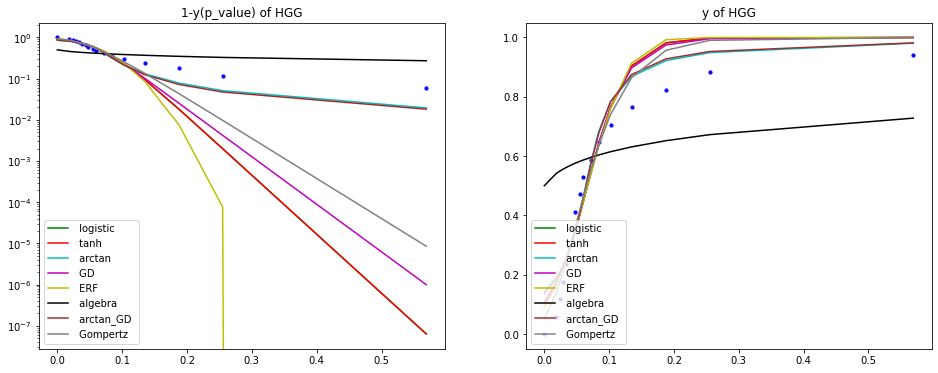

items in each bin:  [22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 21, 21, 21, 21, 21, 21]
For  SF  :
curve_fit parameter on  logistic :  [15.87911872  0.29075904]
curve_fit parameter on  tanh :  [15.87911941  0.14537953]
curve_fit parameter on  arctan :  [15.78328337  0.28555805]
curve_fit parameter on  GD :  [15.86497917  0.11796107]
curve_fit parameter on  ERF :  [15.89900078  0.12419188]
curve_fit parameter on  algebra :  [15.33809358  0.17753814]
curve_fit parameter on  arctan_GD :  [15.83484438  0.63572539 -0.89390637]
curve_fit parameter on  Gompertz :  [2.76730873 0.20075142]


C:\Users\SHIQIJ~1\AppData\Local\Temp/ipykernel_3572/217763432.py:24: RuntimeWarning: divide by zero encountered in power
  m = (1+x/((1+abs(x)**k)**(1/k)))/2
C:\Users\SHIQIJ~1\AppData\Local\Temp/ipykernel_3572/217763432.py:24: RuntimeWarning: invalid value encountered in true_divide
  m = (1+x/((1+abs(x)**k)**(1/k)))/2
D:\anaconda\anaconda\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
C:\Users\SHIQIJ~1\AppData\Local\Temp/ipykernel_3572/217763432.py:32: RuntimeWarning: overflow encountered in power
  m = np.e**(-np.e**(b-c*x))


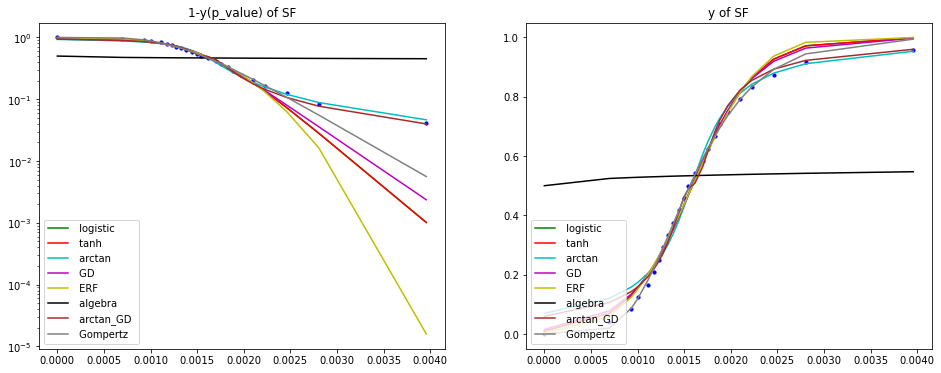

items in each bin:  [22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 21, 21, 21, 21, 21]
For  SFDD  :
curve_fit parameter on  logistic :  [2.0546834  1.78630905]
curve_fit parameter on  tanh :  [2.05468113 0.89315964]
curve_fit parameter on  arctan :  [2.0227669 1.7629814]
curve_fit parameter on  GD :  [2.05020686 0.72383784]
curve_fit parameter on  ERF :  [2.06076406 0.76411549]
curve_fit parameter on  algebra :  [1.9456502  0.27117919]
curve_fit parameter on  arctan_GD :  [2.03341781 1.01934106 0.5675674 ]
curve_fit parameter on  Gompertz :  [2.12051969 1.23197485]


C:\Users\SHIQIJ~1\AppData\Local\Temp/ipykernel_3572/217763432.py:24: RuntimeWarning: divide by zero encountered in power
  m = (1+x/((1+abs(x)**k)**(1/k)))/2
C:\Users\SHIQIJ~1\AppData\Local\Temp/ipykernel_3572/217763432.py:24: RuntimeWarning: invalid value encountered in true_divide
  m = (1+x/((1+abs(x)**k)**(1/k)))/2
D:\anaconda\anaconda\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


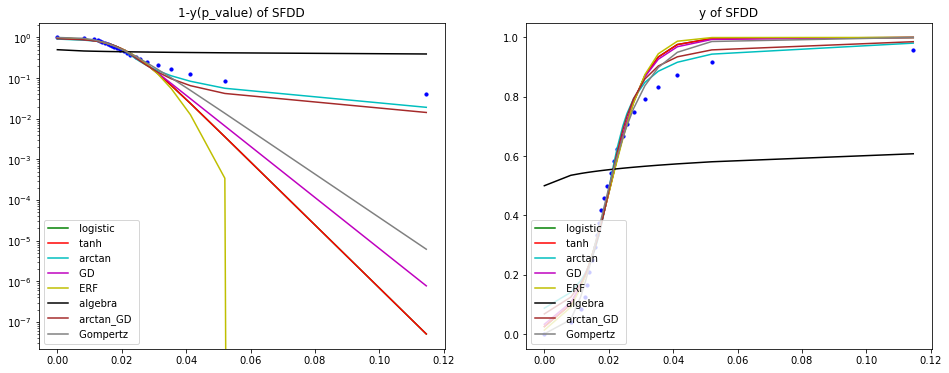

items in each bin:  [22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 21, 21, 21, 21, 21, 21]
For  Sticky  :
curve_fit parameter on  logistic :  [20.97228351  0.28070382]
curve_fit parameter on  tanh :  [20.97228498  0.1403519 ]
curve_fit parameter on  arctan :  [20.885055    0.27786676]
curve_fit parameter on  GD :  [20.95880913  0.11402431]
curve_fit parameter on  ERF :  [20.98955835  0.11981724]
curve_fit parameter on  algebra :  [20.67584929  0.16150934]
curve_fit parameter on  arctan_GD :  [20.9104278   0.58675619 -0.8206425 ]
curve_fit parameter on  Gompertz :  [ 2.23981017e+00 -3.15708406e+03]


C:\Users\SHIQIJ~1\AppData\Local\Temp/ipykernel_3572/217763432.py:24: RuntimeWarning: divide by zero encountered in power
  m = (1+x/((1+abs(x)**k)**(1/k)))/2
C:\Users\SHIQIJ~1\AppData\Local\Temp/ipykernel_3572/217763432.py:24: RuntimeWarning: invalid value encountered in true_divide
  m = (1+x/((1+abs(x)**k)**(1/k)))/2
D:\anaconda\anaconda\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
C:\Users\SHIQIJ~1\AppData\Local\Temp/ipykernel_3572/217763432.py:32: RuntimeWarning: overflow encountered in power
  m = np.e**(-np.e**(b-c*x))
D:\anaconda\anaconda\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


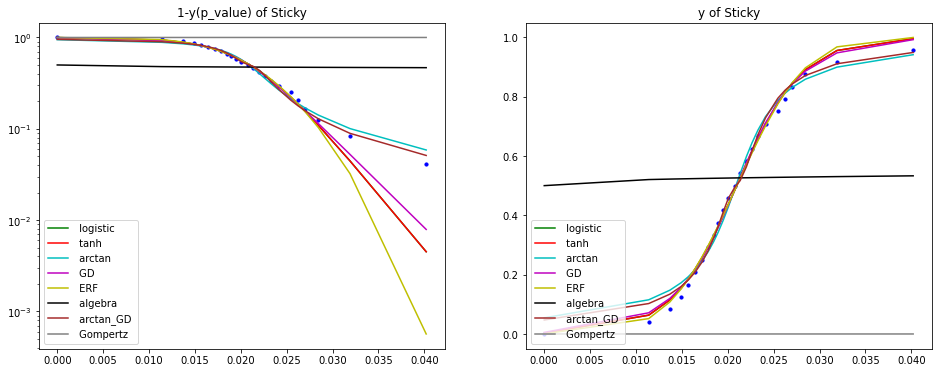

In [59]:
for i in range(len(classes[:-1])):
    data_i = data_distance(data(df_SP,classes[:-1][i]))
    sigmoids_for_class(data_i, classes[:-1][i], factors_SP[i], functions, colors,binning=True)